### $\color{green}{\text{Processing and Explore Data}}$
- > Objectives of this notebook
      - > 1 Explore and visualize the data


#### Author: mandar.tabib@sintef.no , Computational Science and Engineering,SINTEF Digital.


## Imports

In [1]:
# In case of reloading functions
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
current_dir = os.getcwd()    # Get the current directory. 
sys.path.append(current_dir) # Append to path 
fn2=os.path.join(current_dir,'..','SourceCode')
sys.path.append(fn2)         # Add the path to the folder containing imports.py


import imports_kpn as kpn


## Load Dataset



In [3]:
# Data path for pre-processed data
datapath ="../Data/Coefficient/"

# Data path for modeled data
modelpathbase = "../Data/Coefficient/"



## Reading files

Model files are time series generated by the Fortran Model

##### Data time series

In [4]:
# Data from measurement data
A = kpn.np.load(datapath + 'A.npy') #Features for the momentum
MomentumRes = kpn.np.load(datapath + 'MomentumRes.npy') #label for the momentum

B = kpn.np.load(datapath + 'B.npy') #Features for the pressure
PPERes = kpn.np.load(datapath + 'PPERes.npy') #label for the pressure



In [5]:
print ("A",type(A) , A.shape) 

print ("MomentumRes",type(MomentumRes) , MomentumRes.shape)

print ("B",type(B) , B.shape) 

print ("PPERes",type(PPERes) , PPERes.shape)

A <class 'numpy.ndarray'> (100, 3, 18)
MomentumRes <class 'numpy.ndarray'> (100, 18)
B <class 'numpy.ndarray'> (100, 3, 10)
PPERes <class 'numpy.ndarray'> (100, 10)


In [6]:
import optuna as opt

In [7]:
ensemble=False
if ensemble:
  dirFile='../Models/Ensemble_LSTM_Case102_1_Short_validation_Optuna' #Note: see validation ratio chosen in split time-series below.
  dirFile_data='../Data/Processed_training_test'
  dirFile_result='../Results'
else:
  dirFile='../Models/LSTM_HAM'
  kpn.create_directory_if_not_exists(dirFile)
  dirFile_data='../Data/Processed_training_test'
  kpn.create_directory_if_not_exists(dirFile_data)
  dirFile_result='../Results'
  kpn.create_directory_if_not_exists(dirFile_result)  
filename_4_scalingfunction = dirFile + "/Scaling.save"

Directory '../Models/LSTM_HAM' already exists.
Directory '../Data/Processed_training_test' already exists.
Directory '../Results' already exists.


lookback=3
xtrain,ytrain=kpn.create_training_data_lstm_4drilling1(kpn.pd.DataFrame(norm_train_features_fortran_measurement), lookback,kpn.pd.DataFrame(label_train_measurement_fortran))
print(xtrain.shape)
print(ytrain.shape)

In [8]:
#Split of training and validation data.
xtrain,xtest=kpn.split_timeseries_3D(A,nfrac=0.8)

print(xtrain.shape,xtest.shape)

ytrain,ytest=kpn.split_timeseries_3D(MomentumRes,nfrac=0.8)

print(ytrain.shape,ytest.shape)

norm_train_features,norm_test_features,normalizer_fit=kpn.scale_3D_ANN(xtrain,xtest,filename_4_scalingfunction)

#Save scaling features from training data to scale test dataset later. 

#Check LSTM model input shape and output shape.

(80, 3, 18) (20, 3, 18)
(80, 18) (20, 18)
<class 'numpy.ndarray'>
[0.02422759 0.08800888 0.0889863  0.01120622 0.10530383 0.10555164
 0.08162845 0.08895714 0.05606949 0.16218144 0.159802   0.17987692
 0.12546327 0.13054435 0.19814998 0.18000914 0.11347911 0.09490874]
[-0.00322502 -0.08796854 -0.08688427 -0.00991322 -0.10777654 -0.10292603
 -0.09389302 -0.08816302 -0.2004358  -0.20231574 -0.19883923 -0.00678605
 -0.13591613 -0.14396183 -0.18836993 -0.17954804 -0.14992536 -0.08334308]
saved joblib for scaling function as %s  ../Models/LSTM_HAM/Scaling.save


In [9]:
norm_train_features.min(axis=2).mean()

-0.9118155952602413

In [10]:
norm_train_features.max(axis=2).mean()

0.9213283226683778

In [11]:
norm_train_features.max(axis=2).max()

1.0000000000000004

In [12]:
type(norm_train_features)

numpy.ndarray

In [13]:
norm_train_features

array([[[-0.7933493 , -0.9996264 , -0.19998967, ..., -0.39111784,
         -0.02747047, -0.7125751 ],
        [-0.79319726, -0.99981367, -0.1990084 , ..., -0.39162064,
         -0.02732535, -0.71141771],
        [-0.7930451 , -1.        , -0.19802696, ..., -0.39212261,
         -0.02717865, -0.71025846]],

       [[-0.70504415, -0.97469848,  0.29300897, ..., -0.52553775,
          0.25772352, -0.07463221],
        [-0.70484919, -0.97441253,  0.29396087, ..., -0.52557597,
          0.25868381, -0.07359647],
        [-0.70465418, -0.97412566,  0.29491247, ..., -0.5256134 ,
          0.25964523, -0.07256303]],

       [[-0.60741174, -0.72496836,  0.71526991, ..., -0.48506116,
          0.7720859 ,  0.07699373],
        [-0.60722729, -0.72427392,  0.7159736 , ..., -0.48494552,
          0.77294875,  0.07653224],
        [-0.60704294, -0.72357879,  0.7166766 , ..., -0.48483007,
          0.77381   ,  0.07606813]],

       ...,

       [[ 0.86434359, -0.43999003, -0.28651002, ..., -0.5155482

In [14]:
# Use partial to fix the additional arguments
from functools import partial
wrapped_objective = partial(kpn.objective,xtrain=norm_train_features, ytrain=ytrain)

study = opt.create_study(direction="minimize", sampler=opt.samplers.TPESampler(), pruner=opt.pruners.HyperbandPruner())
#study.optimize(kpn.objective(xtrain,ytrain), n_trials=20)

study.optimize(wrapped_objective, n_trials=5)
#pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
#complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

kpn.show_result(study)

[I 2024-07-07 19:56:15,601] A new study created in memory with name: no-name-4d9f442d-c0f8-4118-921e-28b4ed2e2b83


LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 5s 153ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 2/200
7/7 [==============================] - 0s 10ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 3/200
7/7 [==============================] - 0s 10ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 5.3273e-04 - val_mse: 5.3273e-04
Epoch 4/200
7/7 [==============================] - 0s 9ms/step - loss: 7.1411e-04 - mse: 7.1411e-04 - val_loss: 2.8550e-04 - val_mse: 2.8550e-04
Epoch 5/200
7/7 [==============================] - 0s 10ms/step - loss: 4.2728e-04 - mse: 4.2728e-04 - val_loss: 1.1492e-04 - val_mse: 1.1492e-04
Epoch 6/200
7/7 [==============================] - 0s 10ms/step - loss: 3.3017e-04 - mse: 3.3017e-04 - val_loss: 9.9852e-05 - val_mse: 9.9852e-05
Epoch 7/200
7/7 [==============================] - 0s 10ms/step - loss: 2.8188e-04 - mse: 2.8188e-04 - val_loss: 6.9

[I 2024-07-07 19:56:35,734] Trial 0 finished with value: 2.2528434783453122e-05 and parameters: {'n_layers': 3, 'n_units_l0': 94, 'n_units_l1': 40, 'n_units_l2': 65}. Best is trial 0 with value: 2.2528434783453122e-05.


mse: 0.00%
LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 5s 134ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 2/200
7/7 [==============================] - 0s 9ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 7.9483e-04 - val_mse: 7.9483e-04
Epoch 3/200
7/7 [==============================] - 0s 10ms/step - loss: 6.6104e-04 - mse: 6.6104e-04 - val_loss: 4.4871e-04 - val_mse: 4.4871e-04
Epoch 4/200
7/7 [==============================] - 0s 9ms/step - loss: 4.2351e-04 - mse: 4.2351e-04 - val_loss: 3.2154e-04 - val_mse: 3.2154e-04
Epoch 5/200
7/7 [==============================] - 0s 8ms/step - loss: 3.1995e-04 - mse: 3.1995e-04 - val_loss: 2.5479e-04 - val_mse: 2.5479e-04
Epoch 6/200
7/7 [==============================] - 0s 10ms/step - loss: 2.8305e-04 - mse: 2.8305e-04 - val_loss: 2.0357e-04 - val_mse: 2.0357e-04
Epoch 7/200
7/7 [==============================] - 0s 8ms/step - loss: 2.5808e-04 - mse: 2.

[I 2024-07-07 19:56:52,433] Trial 1 finished with value: 3.831242793239653e-05 and parameters: {'n_layers': 2, 'n_units_l0': 131, 'n_units_l1': 30}. Best is trial 0 with value: 2.2528434783453122e-05.


mse: 0.00%
LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 2s 70ms/step - loss: 0.0237 - mse: 0.0237 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 2/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0094 - val_mse: 0.0094
Epoch 3/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 4/200
7/7 [==============================] - 0s 5ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 7/200
7/7 [==============================] - 0s 6ms/step - loss: 7.9944e-04 - mse: 7.9944e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 8/200
7/7 [============

[I 2024-07-07 19:57:03,265] Trial 2 finished with value: 0.0003023750614374876 and parameters: {'n_layers': 1, 'n_units_l0': 62}. Best is trial 0 with value: 2.2528434783453122e-05.


mse: 0.01%
LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 2s 71ms/step - loss: 0.0079 - mse: 0.0079 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 3/200
7/7 [==============================] - 0s 4ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 8.1279e-04 - mse: 8.1279e-04 - val_loss: 9.0262e-04 - val_mse: 9.0262e-04
Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 5.5436e-04 - mse: 5.5436e-04 - val_loss: 7.1720e-04 - val_mse: 7.1720e-04
Epoch 6/200
7/7 [==============================] - 0s 6ms/step - loss: 4.2605e-04 - mse: 4.2605e-04 - val_loss: 5.5573e-04 - val_mse: 5.5573e-04
Epoch 7/200
7/7 [==============================] - 0s 7ms/step - loss: 3.6563e-04 - mse: 3.6563e-04 - val_loss: 4.2769

[I 2024-07-07 19:57:14,020] Trial 3 finished with value: 0.00016470305854454637 and parameters: {'n_layers': 1, 'n_units_l0': 97}. Best is trial 0 with value: 2.2528434783453122e-05.


mse: 0.00%
LSTM models folder already exists
200 10 epochs
Epoch 1/200
7/7 [==============================] - 4s 108ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 4.8278e-04 - val_mse: 4.8278e-04
Epoch 3/200
7/7 [==============================] - 0s 7ms/step - loss: 4.9488e-04 - mse: 4.9488e-04 - val_loss: 4.1576e-04 - val_mse: 4.1576e-04
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 3.9954e-04 - mse: 3.9954e-04 - val_loss: 3.1569e-04 - val_mse: 3.1569e-04
Epoch 5/200
7/7 [==============================] - 0s 8ms/step - loss: 3.1283e-04 - mse: 3.1283e-04 - val_loss: 1.9825e-04 - val_mse: 1.9825e-04
Epoch 6/200
7/7 [==============================] - 0s 7ms/step - loss: 2.7164e-04 - mse: 2.7164e-04 - val_loss: 1.3954e-04 - val_mse: 1.3954e-04
Epoch 7/200
7/7 [==============================] - 0s 7ms/step - loss: 2.4727e-04 - mse: 2.47

[I 2024-07-07 19:57:27,759] Trial 4 finished with value: 1.9314551536808722e-05 and parameters: {'n_layers': 2, 'n_units_l0': 26, 'n_units_l1': 113}. Best is trial 4 with value: 1.9314551536808722e-05.


mse: 0.00%
Study statistics: 
  Number of finished trials:  5
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  1.9314551536808722e-05
  Params: 
    n_layers: 2
    n_units_l0: 26
    n_units_l1: 113


In [15]:
kpn.show_result(study)

Study statistics: 
  Number of finished trials:  5
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  1.9314551536808722e-05
  Params: 
    n_layers: 2
    n_units_l0: 26
    n_units_l1: 113


In [16]:
dict_para=study.best_params

In [17]:
with open(dirFile+'/best_parameter.pkl', 'wb') as fp:
    kpn.pickle.dump(dict_para,fp)
    print(f'dictionary saved successfully to file : {dirFile+"/best_parameter.pkl"}')

dictionary saved successfully to file : ../Models/LSTM_HAM/best_parameter.pkl


In [18]:
model,loss,val_loss=kpn.create_model1(dict_para,xtrain=norm_train_features, ytrain=ytrain)  #norm_train_features, ytrain=ytrain

Epoch 1/200
7/7 [==============================] - 4s 113ms/step - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0038 - val_mse: 0.0038

Epoch 00001: val_loss improved from inf to 0.00378, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 2/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0027 - val_mse: 0.0027

Epoch 00002: val_loss improved from 0.00378 to 0.00266, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 3/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0018 - val_mse: 0.0018

Epoch 00003: val_loss improved from 0.00266 to 0.00179, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0012 - val_mse: 0.0012

Epoch 00004: val_loss improved from 0.00179 to 0.00120, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 5/200
7/7 [==============================] - 0s 6ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 8.6344e-04 - val_mse: 8.6344e-04

Epoch 00005: val_loss improved from 0.00120 to 0.00086, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 6/200
7/7 [==============================] - 0s 4ms/step - loss: 8.3900e-04 - mse: 8.3900e-04 - val_loss: 6.9612e-04 - val_mse: 6.9612e-04

Epoch 00006: val_loss improved from 0.00086 to 0.00070, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 7/200
7/7 [==============================] - 0s 7ms/step - loss: 6.0072e-04 - mse: 6.0072e-04 - val_loss: 5.5205e-04 - val_mse: 5.5205e-04

Epoch 00007: val_loss improved from 0.00070 to 0.00055, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 8/200
7/7 [==============================] - 0s 9ms/step - loss: 4.6556e-04 - mse: 4.6556e-04 - val_loss: 4.4462e-04 - val_mse: 4.4462e-04

Epoch 00008: val_loss improved from 0.00055 to 0.00044, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 9/200
7/7 [==============================] - 0s 7ms/step - loss: 3.8198e-04 - mse: 3.8198e-04 - val_loss: 3.6776e-04 - val_mse: 3.6776e-04

Epoch 00009: val_loss improved from 0.00044 to 0.00037, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 10/200
7/7 [==============================] - 0s 8ms/step - loss: 3.3682e-04 - mse: 3.3682e-04 - val_loss: 3.3072e-04 - val_mse: 3.3072e-04

Epoch 00010: val_loss improved from 0.00037 to 0.00033, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 11/200
7/7 [==============================] - 0s 7ms/step - loss: 3.0533e-04 - mse: 3.0533e-04 - val_loss: 3.0280e-04 - val_mse: 3.0280e-04

Epoch 00011: val_loss improved from 0.00033 to 0.00030, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 12/200
7/7 [==============================] - 0s 9ms/step - loss: 2.8555e-04 - mse: 2.8555e-04 - val_loss: 2.8040e-04 - val_mse: 2.8040e-04

Epoch 00012: val_loss improved from 0.00030 to 0.00028, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 13/200
7/7 [==============================] - 0s 7ms/step - loss: 2.7381e-04 - mse: 2.7381e-04 - val_loss: 2.5573e-04 - val_mse: 2.5573e-04

Epoch 00013: val_loss improved from 0.00028 to 0.00026, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 14/200
7/7 [==============================] - 0s 8ms/step - loss: 2.5622e-04 - mse: 2.5622e-04 - val_loss: 2.6606e-04 - val_mse: 2.6606e-04

Epoch 00014: val_loss did not improve from 0.00026
Epoch 15/200
7/7 [==============================] - 0s 8ms/step - loss: 2.4527e-04 - mse: 2.4527e-04 - val_loss: 2.4200e-04 - val_mse: 2.4200e-04

Epoch 00015: val_loss improved from 0.00026 to 0.00024, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 16/200
7/7 [==============================] - 0s 7ms/step - loss: 2.4086e-04 - mse: 2.4086e-04 - val_loss: 2.2300e-04 - val_mse: 2.2300e-04

Epoch 00016: val_loss improved from 0.00024 to 0.00022, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 17/200
7/7 [==============================] - 0s 8ms/step - loss: 2.2424e-04 - mse: 2.2424e-04 - val_loss: 2.1229e-04 - val_mse: 2.1229e-04

Epoch 00017: val_loss improved from 0.00022 to 0.00021, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 18/200
7/7 [==============================] - 0s 10ms/step - loss: 2.1691e-04 - mse: 2.1691e-04 - val_loss: 1.9608e-04 - val_mse: 1.9608e-04

Epoch 00018: val_loss improved from 0.00021 to 0.00020, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 19/200
7/7 [==============================] - 0s 8ms/step - loss: 2.1171e-04 - mse: 2.1171e-04 - val_loss: 1.8545e-04 - val_mse: 1.8545e-04

Epoch 00019: val_loss improved from 0.00020 to 0.00019, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 20/200
7/7 [==============================] - 0s 8ms/step - loss: 2.0716e-04 - mse: 2.0716e-04 - val_loss: 1.9715e-04 - val_mse: 1.9715e-04

Epoch 00020: val_loss did not improve from 0.00019
Epoch 21/200
7/7 [==============================] - 0s 9ms/step - loss: 1.9840e-04 - mse: 1.9840e-04 - val_loss: 1.7832e-04 - val_mse: 1.7832e-04

Epoch 00021: val_loss improved from 0.00019 to 0.00018, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 22/200
7/7 [==============================] - 0s 9ms/step - loss: 1.9272e-04 - mse: 1.9272e-04 - val_loss: 1.6420e-04 - val_mse: 1.6420e-04

Epoch 00022: val_loss improved from 0.00018 to 0.00016, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 23/200
7/7 [==============================] - 0s 7ms/step - loss: 1.8901e-04 - mse: 1.8901e-04 - val_loss: 1.5596e-04 - val_mse: 1.5596e-04

Epoch 00023: val_loss improved from 0.00016 to 0.00016, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 24/200
7/7 [==============================] - 0s 7ms/step - loss: 1.9314e-04 - mse: 1.9314e-04 - val_loss: 1.3964e-04 - val_mse: 1.3964e-04

Epoch 00024: val_loss improved from 0.00016 to 0.00014, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 25/200
7/7 [==============================] - 0s 8ms/step - loss: 1.8218e-04 - mse: 1.8218e-04 - val_loss: 1.5913e-04 - val_mse: 1.5913e-04

Epoch 00025: val_loss did not improve from 0.00014
Epoch 26/200
7/7 [==============================] - 0s 9ms/step - loss: 1.7085e-04 - mse: 1.7085e-04 - val_loss: 1.6841e-04 - val_mse: 1.6841e-04

Epoch 00026: val_loss did not improve from 0.00014
Epoch 27/200
7/7 [==============================] - 0s 5ms/step - loss: 1.6994e-04 - mse: 1.6994e-04 - val_loss: 1.5528e-04 - val_mse: 1.5528e-04

Epoch 00027: val_loss did not improve from 0.00014
Epoch 28/200
7/7 [==============================] - 0s 5ms/step - loss: 1.6721e-04 - mse: 1.6721e-04 - val_loss: 1.5177e-04 - val_mse: 1.5177e-04

Epoch 00028: val_loss did not improve from 0.00014
Epoch 29/200
7/7 [==============================] - 0s 7ms/step - loss: 1.6136e-04 - mse: 1.6136e-04 - val_loss: 1.4142e-04 - val_mse: 1.4142e-04

Epoch 00029: val_loss did not improve from 0.00014
Epoch 30/2

INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 31/200
7/7 [==============================] - 0s 7ms/step - loss: 1.5736e-04 - mse: 1.5736e-04 - val_loss: 1.3190e-04 - val_mse: 1.3190e-04

Epoch 00031: val_loss did not improve from 0.00013
Epoch 32/200
7/7 [==============================] - 0s 7ms/step - loss: 1.4872e-04 - mse: 1.4872e-04 - val_loss: 1.2017e-04 - val_mse: 1.2017e-04

Epoch 00032: val_loss improved from 0.00013 to 0.00012, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 33/200
7/7 [==============================] - 0s 5ms/step - loss: 1.5546e-04 - mse: 1.5546e-04 - val_loss: 1.3138e-04 - val_mse: 1.3138e-04

Epoch 00033: val_loss did not improve from 0.00012
Epoch 34/200
7/7 [==============================] - 0s 6ms/step - loss: 1.4247e-04 - mse: 1.4247e-04 - val_loss: 1.4695e-04 - val_mse: 1.4695e-04

Epoch 00034: val_loss did not improve from 0.00012
Epoch 35/200
7/7 [==============================] - 0s 7ms/step - loss: 1.3954e-04 - mse: 1.3954e-04 - val_loss: 1.3303e-04 - val_mse: 1.3303e-04

Epoch 00035: val_loss did not improve from 0.00012
Epoch 36/200
7/7 [==============================] - 0s 7ms/step - loss: 1.3724e-04 - mse: 1.3724e-04 - val_loss: 1.1880e-04 - val_mse: 1.1880e-04

Epoch 00036: val_loss improved from 0.00012 to 0.00012, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\

INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 37/200
7/7 [==============================] - 0s 9ms/step - loss: 1.3520e-04 - mse: 1.3520e-04 - val_loss: 1.2009e-04 - val_mse: 1.2009e-04

Epoch 00037: val_loss did not improve from 0.00012
Epoch 38/200
7/7 [==============================] - 0s 8ms/step - loss: 1.2973e-04 - mse: 1.2973e-04 - val_loss: 1.1801e-04 - val_mse: 1.1801e-04

Epoch 00038: val_loss improved from 0.00012 to 0.00012, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 39/200
7/7 [==============================] - 0s 9ms/step - loss: 1.3062e-04 - mse: 1.3062e-04 - val_loss: 1.1836e-04 - val_mse: 1.1836e-04

Epoch 00039: val_loss did not improve from 0.00012
Epoch 40/200
7/7 [==============================] - 0s 8ms/step - loss: 1.2581e-04 - mse: 1.2581e-04 - val_loss: 1.0635e-04 - val_mse: 1.0635e-04

Epoch 00040: val_loss improved from 0.00012 to 0.00011, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 41/200
7/7 [==============================] - 0s 11ms/step - loss: 1.2353e-04 - mse: 1.2353e-04 - val_loss: 1.0565e-04 - val_mse: 1.0565e-04

Epoch 00041: val_loss improved from 0.00011 to 0.00011, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 42/200
7/7 [==============================] - 0s 7ms/step - loss: 1.1979e-04 - mse: 1.1979e-04 - val_loss: 1.1051e-04 - val_mse: 1.1051e-04

Epoch 00042: val_loss did not improve from 0.00011
Epoch 43/200
7/7 [==============================] - 0s 8ms/step - loss: 1.2032e-04 - mse: 1.2032e-04 - val_loss: 1.0690e-04 - val_mse: 1.0690e-04

Epoch 00043: val_loss did not improve from 0.00011
Epoch 44/200
7/7 [==============================] - 0s 7ms/step - loss: 1.1325e-04 - mse: 1.1325e-04 - val_loss: 1.1307e-04 - val_mse: 1.1307e-04

Epoch 00044: val_loss did not improve from 0.00011
Epoch 45/200
7/7 [==============================] - 0s 8ms/step - loss: 1.1215e-04 - mse: 1.1215e-04 - val_loss: 1.0326e-04 - val_mse: 1.0326e-04

Epoch 00045: val_loss improved from 0.00011 to 0.00010, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\

INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 46/200
7/7 [==============================] - 0s 7ms/step - loss: 1.0840e-04 - mse: 1.0840e-04 - val_loss: 1.0372e-04 - val_mse: 1.0372e-04

Epoch 00046: val_loss did not improve from 0.00010
Epoch 47/200
7/7 [==============================] - 0s 8ms/step - loss: 1.1330e-04 - mse: 1.1330e-04 - val_loss: 1.0221e-04 - val_mse: 1.0221e-04

Epoch 00047: val_loss improved from 0.00010 to 0.00010, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 48/200
7/7 [==============================] - 0s 5ms/step - loss: 1.1709e-04 - mse: 1.1709e-04 - val_loss: 1.2291e-04 - val_mse: 1.2291e-04

Epoch 00048: val_loss did not improve from 0.00010
Epoch 49/200
7/7 [==============================] - 0s 7ms/step - loss: 1.0567e-04 - mse: 1.0567e-04 - val_loss: 1.0185e-04 - val_mse: 1.0185e-04

Epoch 00049: val_loss improved from 0.00010 to 0.00010, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 50/200
7/7 [==============================] - 0s 5ms/step - loss: 9.8141e-05 - mse: 9.8141e-05 - val_loss: 1.0547e-04 - val_mse: 1.0547e-04

Epoch 00050: val_loss did not improve from 0.00010
Epoch 51/200
7/7 [==============================] - 0s 6ms/step - loss: 9.8272e-05 - mse: 9.8272e-05 - val_loss: 1.0928e-04 - val_mse: 1.0928e-04

Epoch 00051: val_loss did not improve from 0.00010
Epoch 52/200
7/7 [==============================] - 0s 6ms/step - loss: 9.9038e-05 - mse: 9.9038e-05 - val_loss: 1.0765e-04 - val_mse: 1.0765e-04

Epoch 00052: val_loss did not improve from 0.00010
Epoch 53/200
7/7 [==============================] - 0s 6ms/step - loss: 9.0133e-05 - mse: 9.0133e-05 - val_loss: 9.7743e-05 - val_mse: 9.7743e-05

Epoch 00053: val_loss improved from 0.00010 to 0.00010, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\

INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 54/200
7/7 [==============================] - 0s 8ms/step - loss: 8.9505e-05 - mse: 8.9505e-05 - val_loss: 1.0579e-04 - val_mse: 1.0579e-04

Epoch 00054: val_loss did not improve from 0.00010
Epoch 55/200
7/7 [==============================] - 0s 5ms/step - loss: 8.4208e-05 - mse: 8.4208e-05 - val_loss: 1.0865e-04 - val_mse: 1.0865e-04

Epoch 00055: val_loss did not improve from 0.00010
Epoch 56/200
7/7 [==============================] - 0s 6ms/step - loss: 8.3434e-05 - mse: 8.3434e-05 - val_loss: 9.6360e-05 - val_mse: 9.6360e-05

Epoch 00056: val_loss improved from 0.00010 to 0.00010, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 57/200
7/7 [==============================] - 0s 9ms/step - loss: 8.4397e-05 - mse: 8.4397e-05 - val_loss: 1.0122e-04 - val_mse: 1.0122e-04

Epoch 00057: val_loss did not improve from 0.00010
Epoch 58/200
7/7 [==============================] - 0s 7ms/step - loss: 7.8627e-05 - mse: 7.8627e-05 - val_loss: 8.8923e-05 - val_mse: 8.8923e-05

Epoch 00058: val_loss improved from 0.00010 to 0.00009, saving model to c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks
INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 59/200
7/7 [==============================] - 0s 8ms/step - loss: 7.7365e-05 - mse: 7.7365e-05 - val_loss: 9.7301e-05 - val_mse: 9.7301e-05

Epoch 00059: val_loss did not improve from 0.00009
Epoch 60/200
7/7 [==============================] - 0s 5ms/step - loss: 7.6927e-05 - mse: 7.6927e-05 - val_loss: 1.0902e-04 - val_mse: 1.0902e-04

Epoch 00060: val_loss did not improve from 0.00009
Epoch 61/200
7/7 [==============================] - 0s 6ms/step - loss: 7.3346e-05 - mse: 7.3346e-05 - val_loss: 9.0132e-05 - val_mse: 9.0132e-05

Epoch 00061: val_loss did not improve from 0.00009
Epoch 62/200
7/7 [==============================] - 0s 9ms/step - loss: 7.2976e-05 - mse: 7.2976e-05 - val_loss: 1.0251e-04 - val_mse: 1.0251e-04

Epoch 00062: val_loss did not improve from 0.00009
Epoch 63/200
7/7 [==============================] - 0s 5ms/step - loss: 7.7992e-05 - mse: 7.7992e-05 - val_loss: 1.0891e-04 - val_mse: 1.0891e-04

Epoch 00063: val_loss did not improve from 0.00009
Epoch 64/2

INFO:tensorflow:Assets written to: c:\Users\mandart\A_MANDAR_DOCUMENTS\HAM_Wind_Energy\Demonstration\Notebooks\assets


Epoch 65/200
7/7 [==============================] - 0s 9ms/step - loss: 6.9074e-05 - mse: 6.9074e-05 - val_loss: 1.1060e-04 - val_mse: 1.1060e-04

Epoch 00065: val_loss did not improve from 0.00008
Epoch 66/200
7/7 [==============================] - 0s 6ms/step - loss: 6.3598e-05 - mse: 6.3598e-05 - val_loss: 1.2015e-04 - val_mse: 1.2015e-04

Epoch 00066: val_loss did not improve from 0.00008
Epoch 67/200
7/7 [==============================] - 0s 7ms/step - loss: 6.3264e-05 - mse: 6.3264e-05 - val_loss: 9.4947e-05 - val_mse: 9.4947e-05

Epoch 00067: val_loss did not improve from 0.00008
Epoch 68/200
7/7 [==============================] - 0s 6ms/step - loss: 5.9662e-05 - mse: 5.9662e-05 - val_loss: 1.1319e-04 - val_mse: 1.1319e-04

Epoch 00068: val_loss did not improve from 0.00008
Epoch 69/200
7/7 [==============================] - 0s 8ms/step - loss: 5.7742e-05 - mse: 5.7742e-05 - val_loss: 1.1805e-04 - val_mse: 1.1805e-04

Epoch 00069: val_loss did not improve from 0.00008
Epoch 70/2

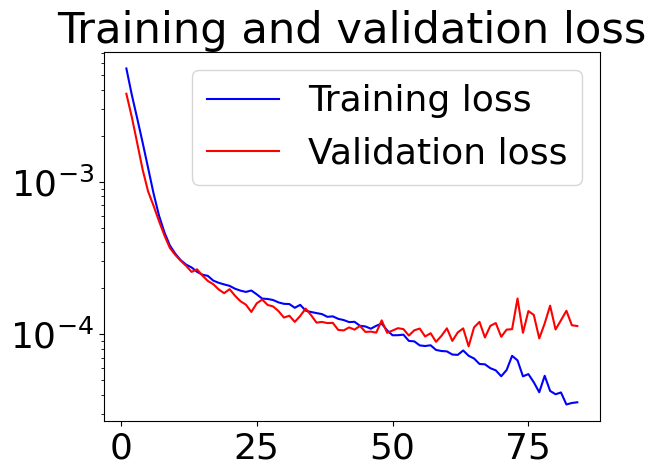

In [19]:
kpn.plt.figure()
epochs = range(1, len(loss) + 1)
kpn.plt.semilogy(epochs, loss, 'b', label='Training loss')
kpn.plt.semilogy(epochs, val_loss, 'r', label='Validation loss')
kpn.plt.title('Training and validation loss')
kpn.plt.legend()
filename = 'HAM_lstm.png'
kpn.plt.savefig(os.path.abspath(dirFile+'/'+filename), dpi = 200)
kpn.plt.show()  

In [20]:
model.save(dirFile+'/best_model.h5')

In [21]:
print('xtrain shape for fit',A.shape)
print('ytrain shape for fit',MomentumRes.shape)
scores = model.evaluate(A, MomentumRes, verbose=0)
print("%s: %.6f%%" % (model.metrics_names[1], scores[1]*100))

xtrain shape for fit (100, 3, 18)
ytrain shape for fit (100, 18)
mse: 0.256371%


In [22]:
type(ytest)

numpy.ndarray

In [26]:
xtest.shape

(20, 3, 18)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 3, 26)             4680      
_________________________________________________________________
lstm_10 (LSTM)               (None, 26)                5512      
_________________________________________________________________
dense_5 (Dense)              (None, 18)                486       
Total params: 10,678
Trainable params: 10,678
Non-trainable params: 0
_________________________________________________________________
xtest,xtrain are NOT scaled. norm_train_features,norm_test_feature ARE SCALED
ytest,ytrain are labels and NO scaling NEEDED
[0.02422759 0.08800888 0.0889863  0.01120622 0.10530383 0.10555164
 0.08162845 0.08895714 0.05606949 0.16218144 0.159802   0.17987692
 0.12546327 0.13054435 0.19814998 0.18000914 0.11347911 0.09490874]
[-0.00322502 -0.08796854 -0.08688427 -0.00991322 -0.10

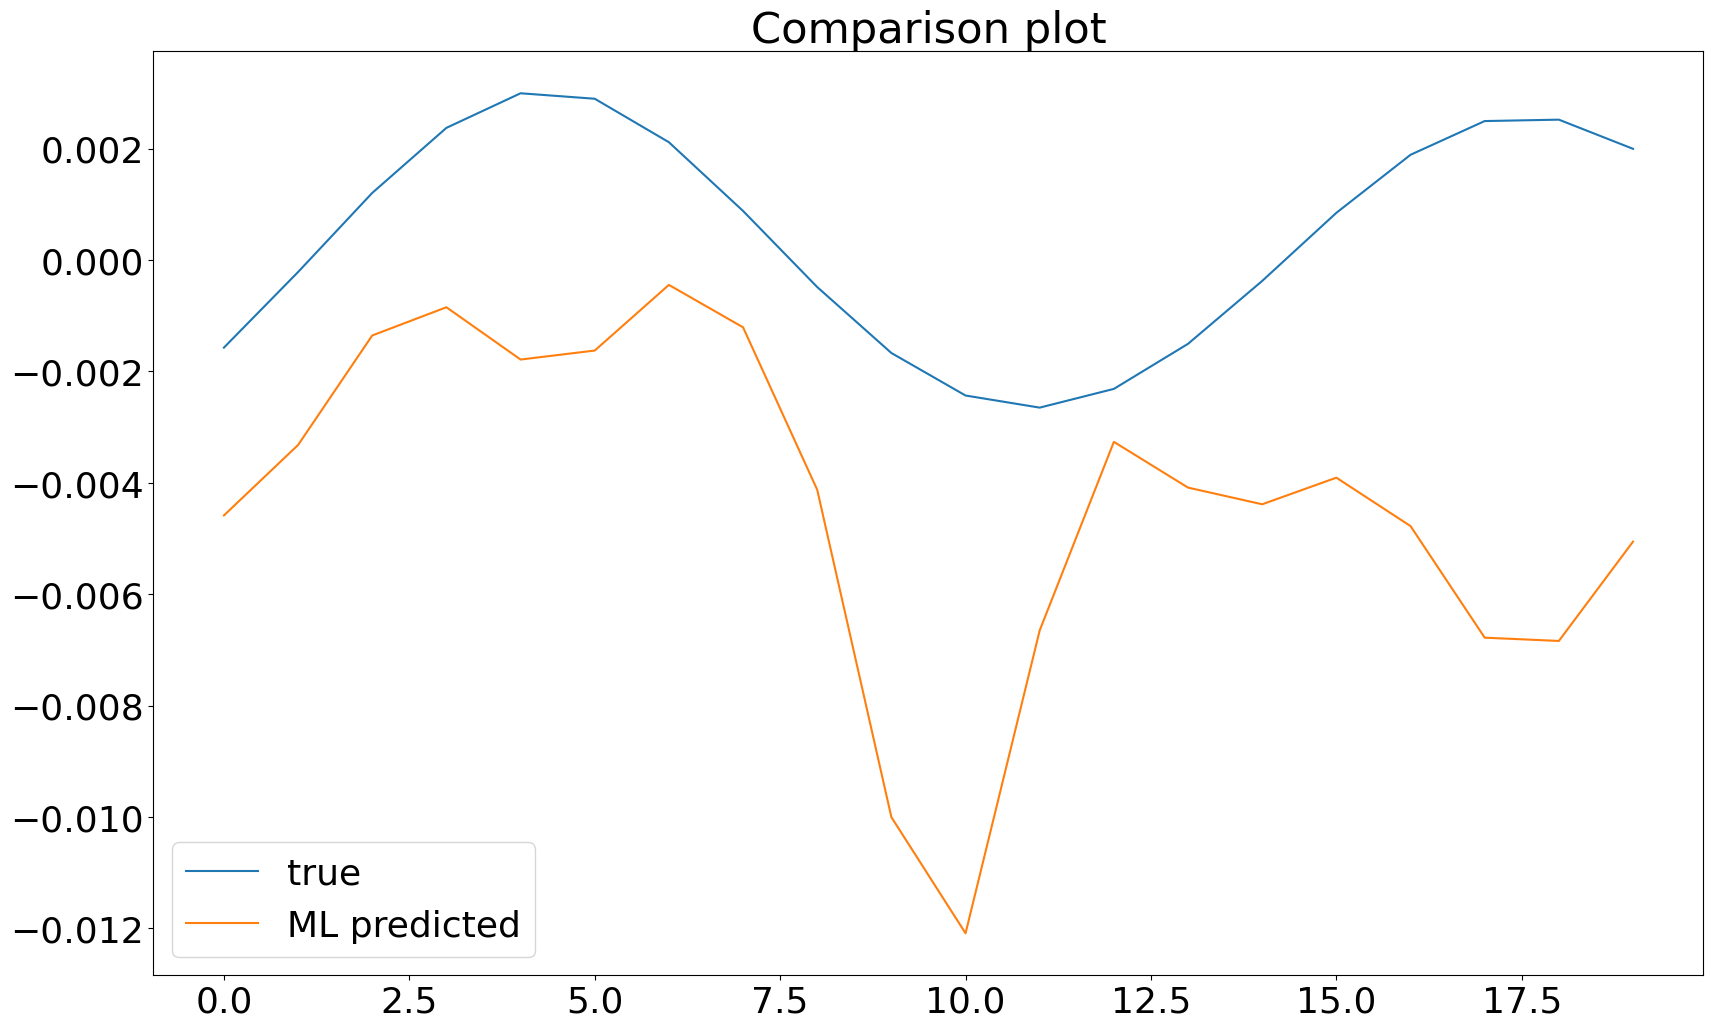

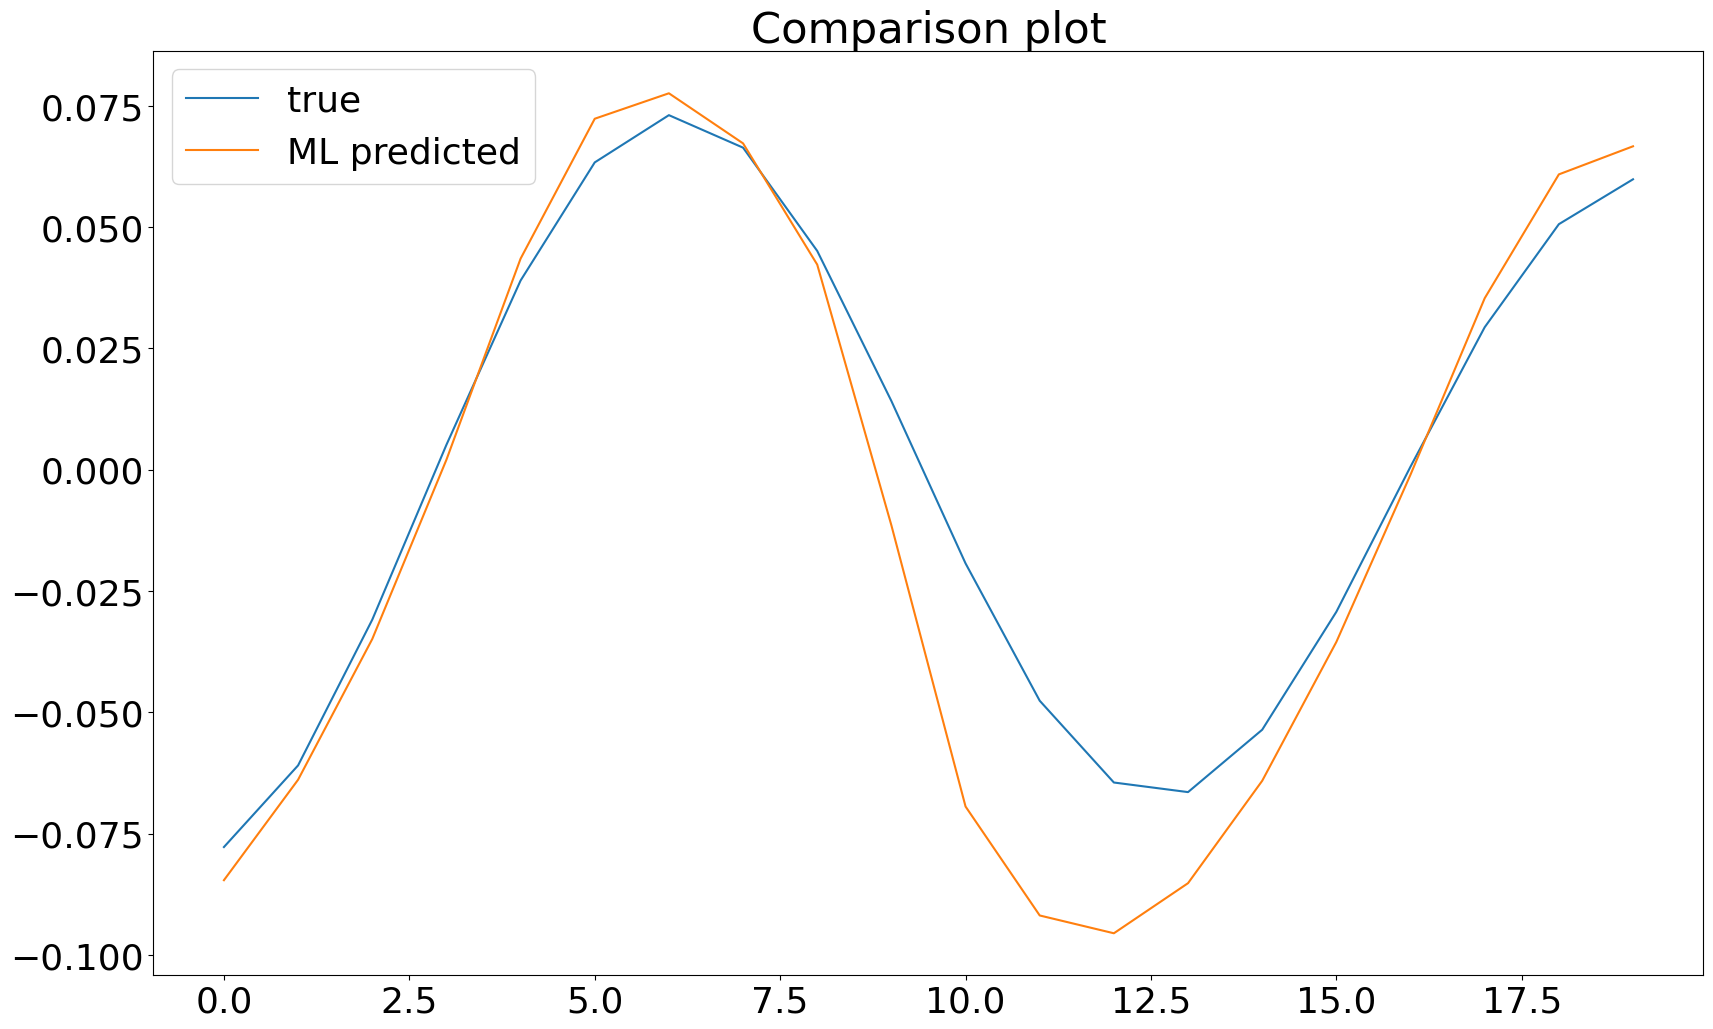

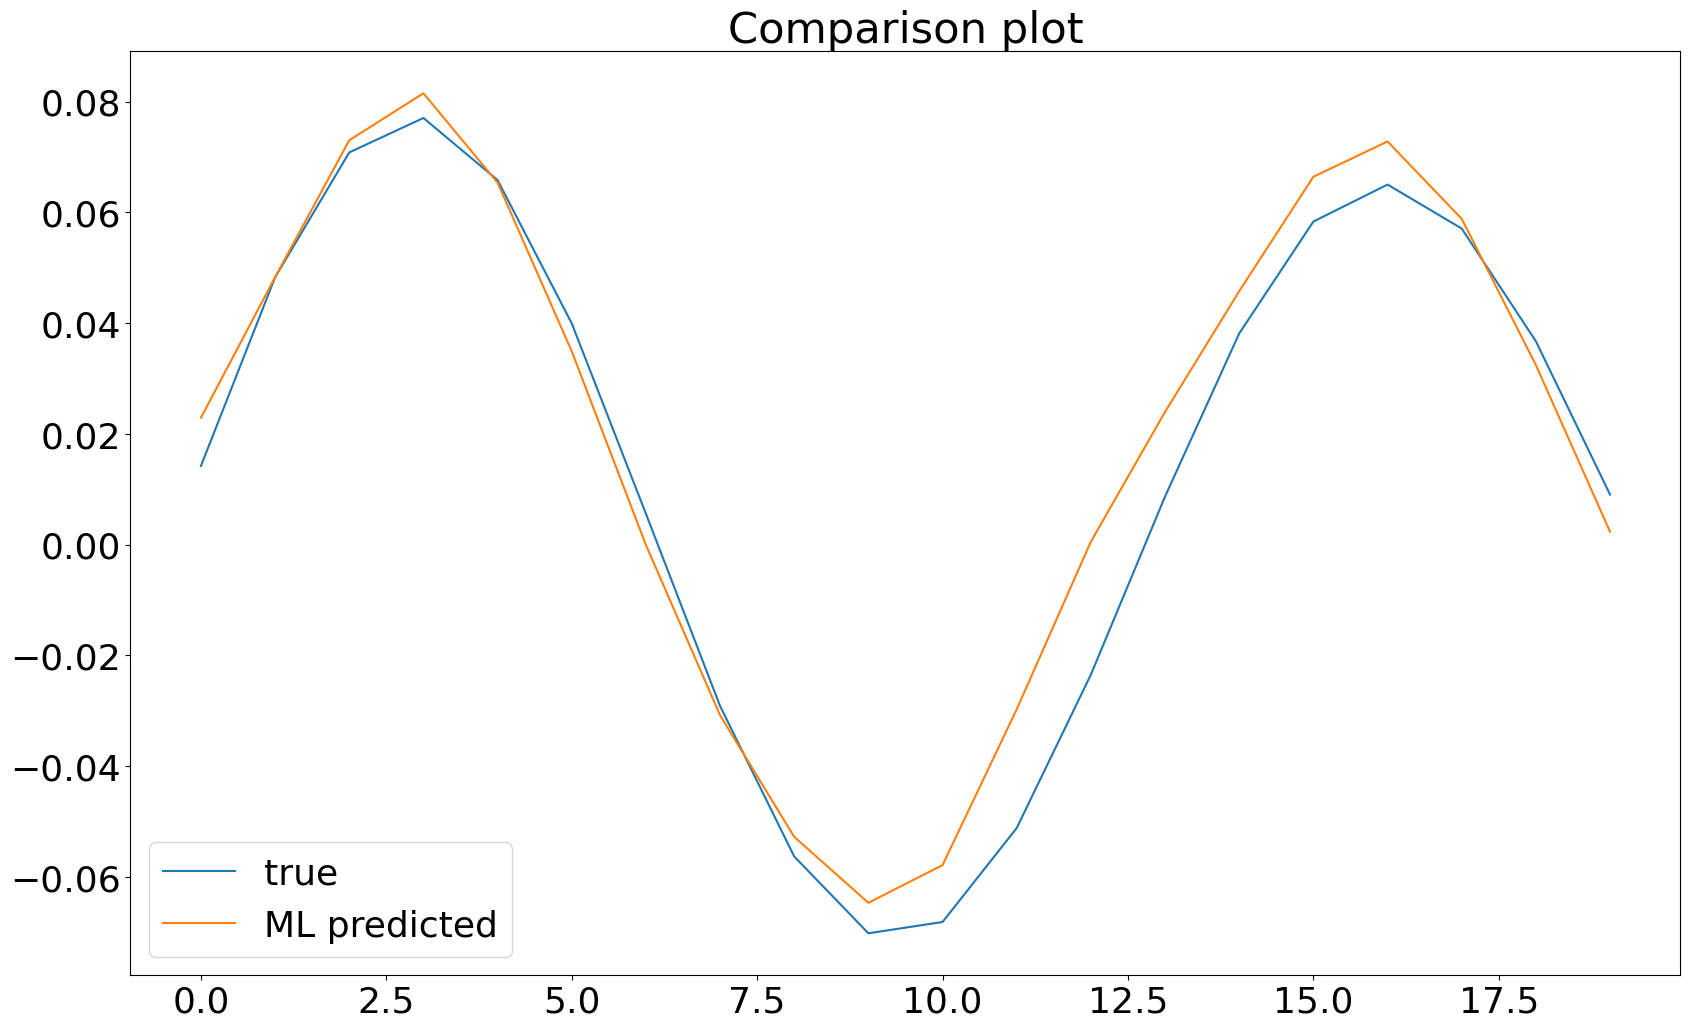

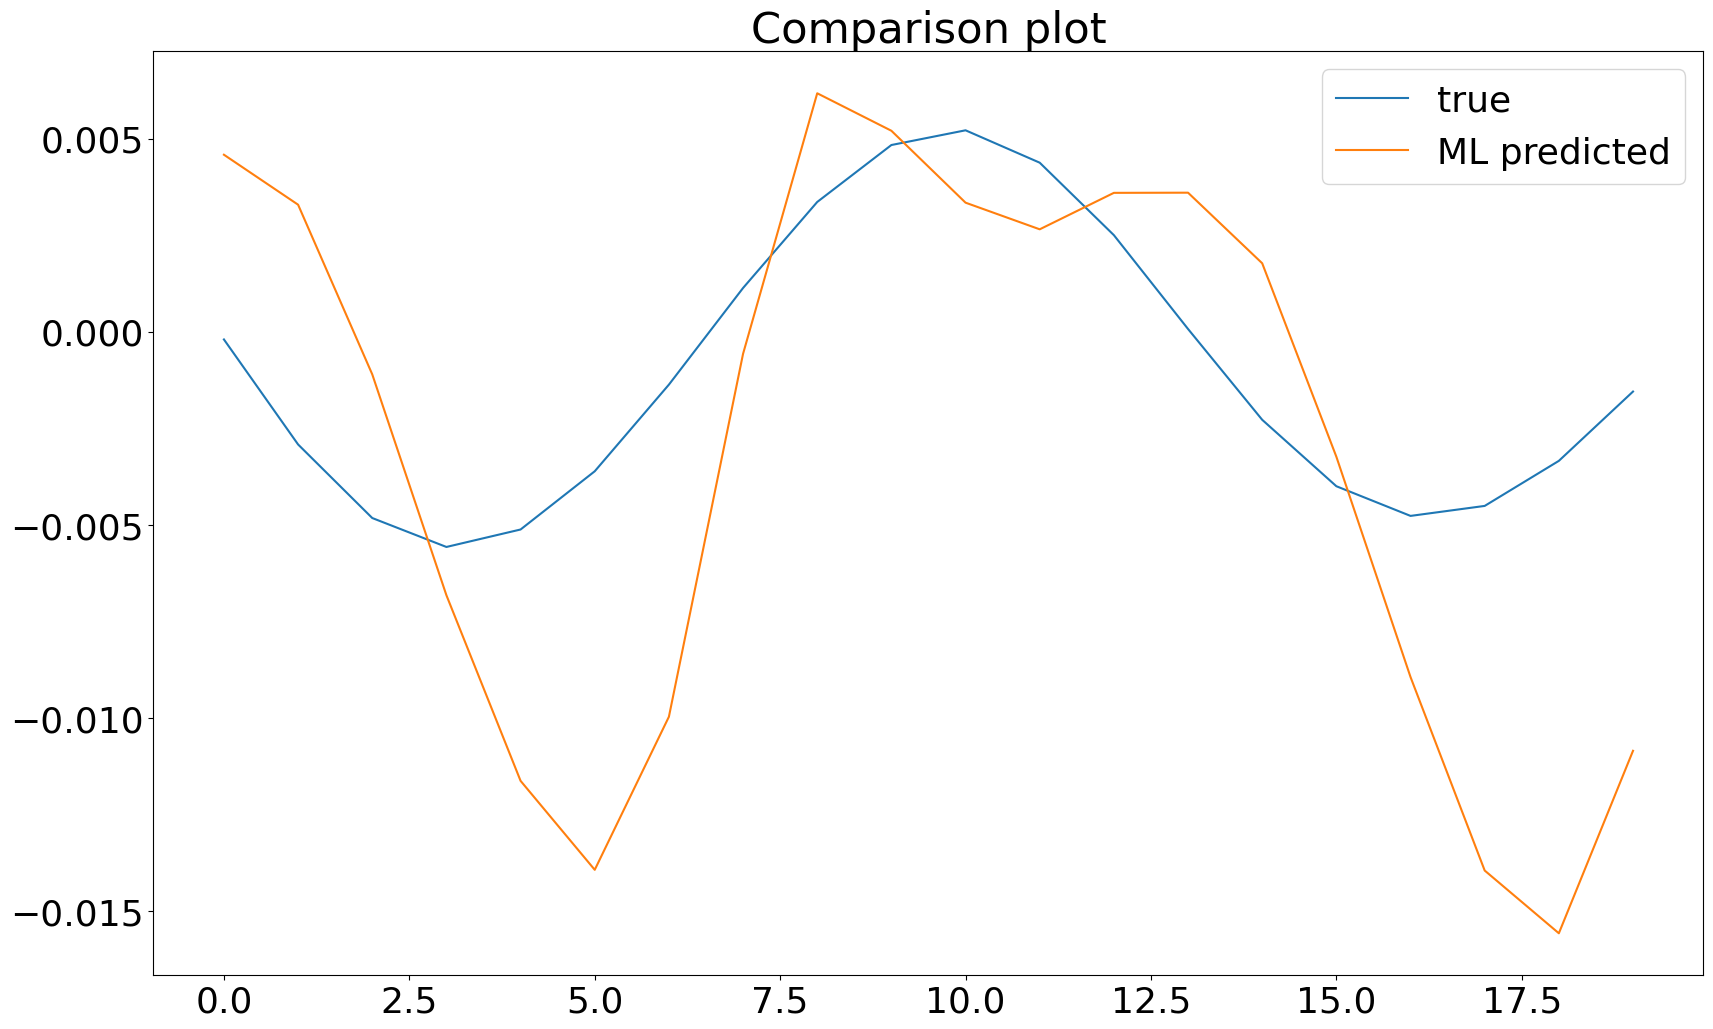

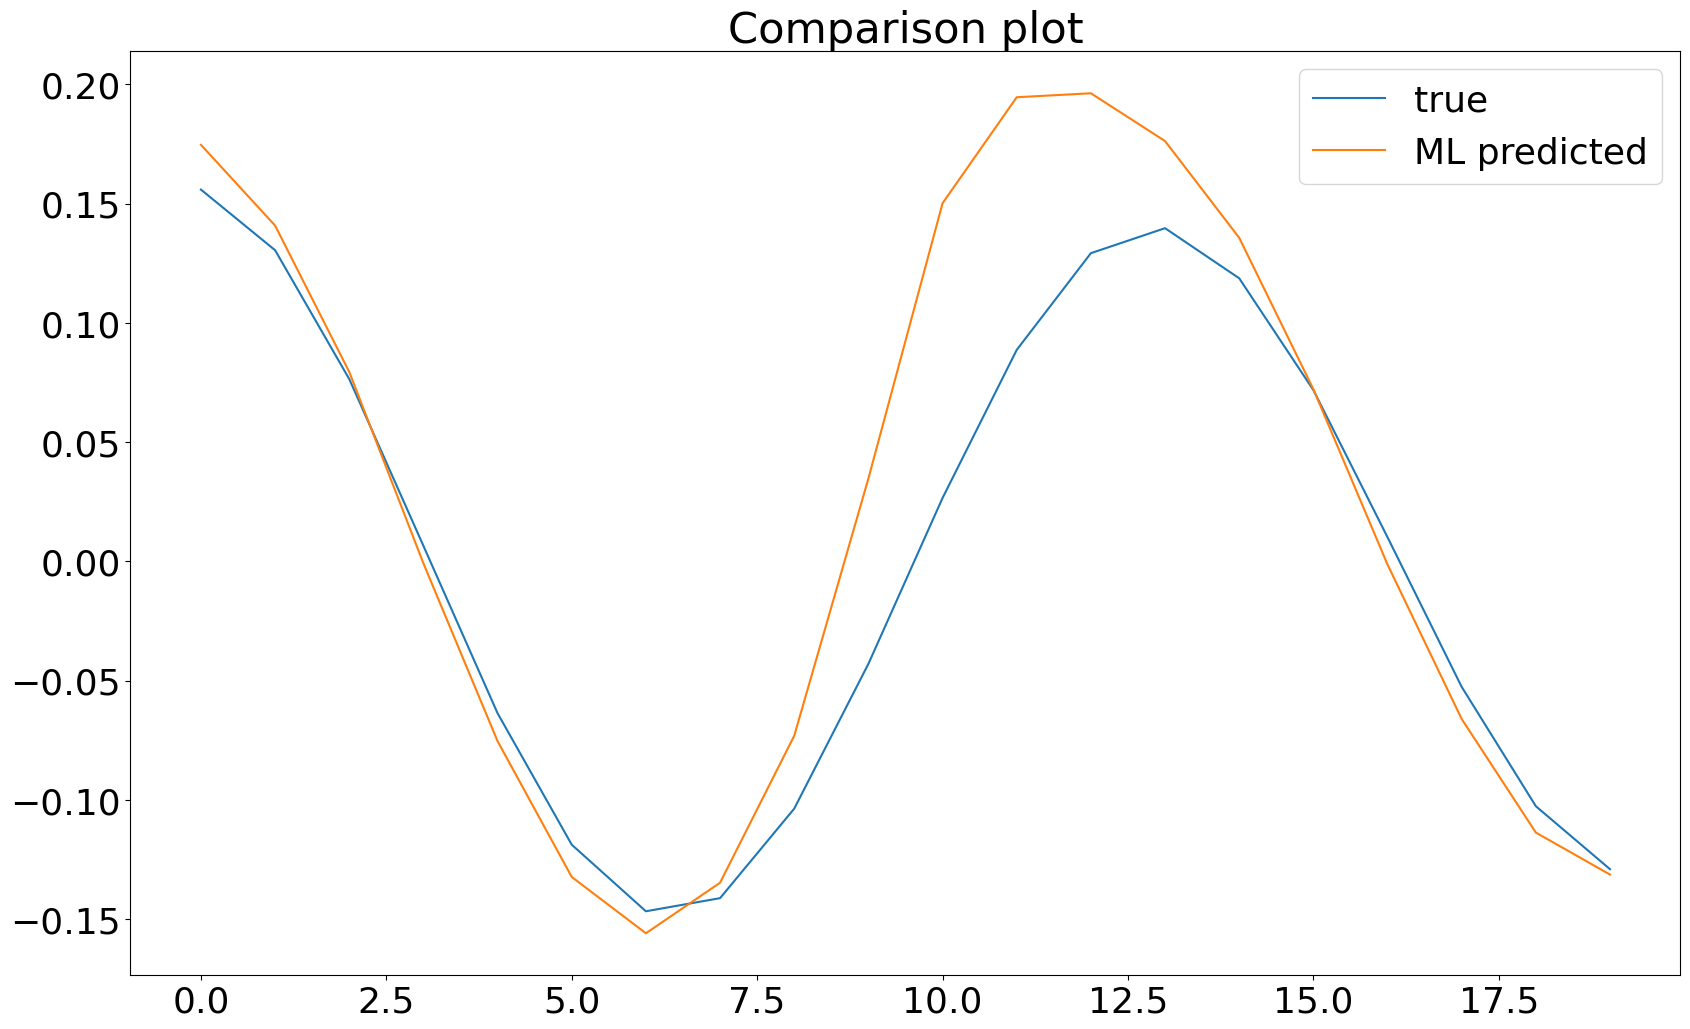

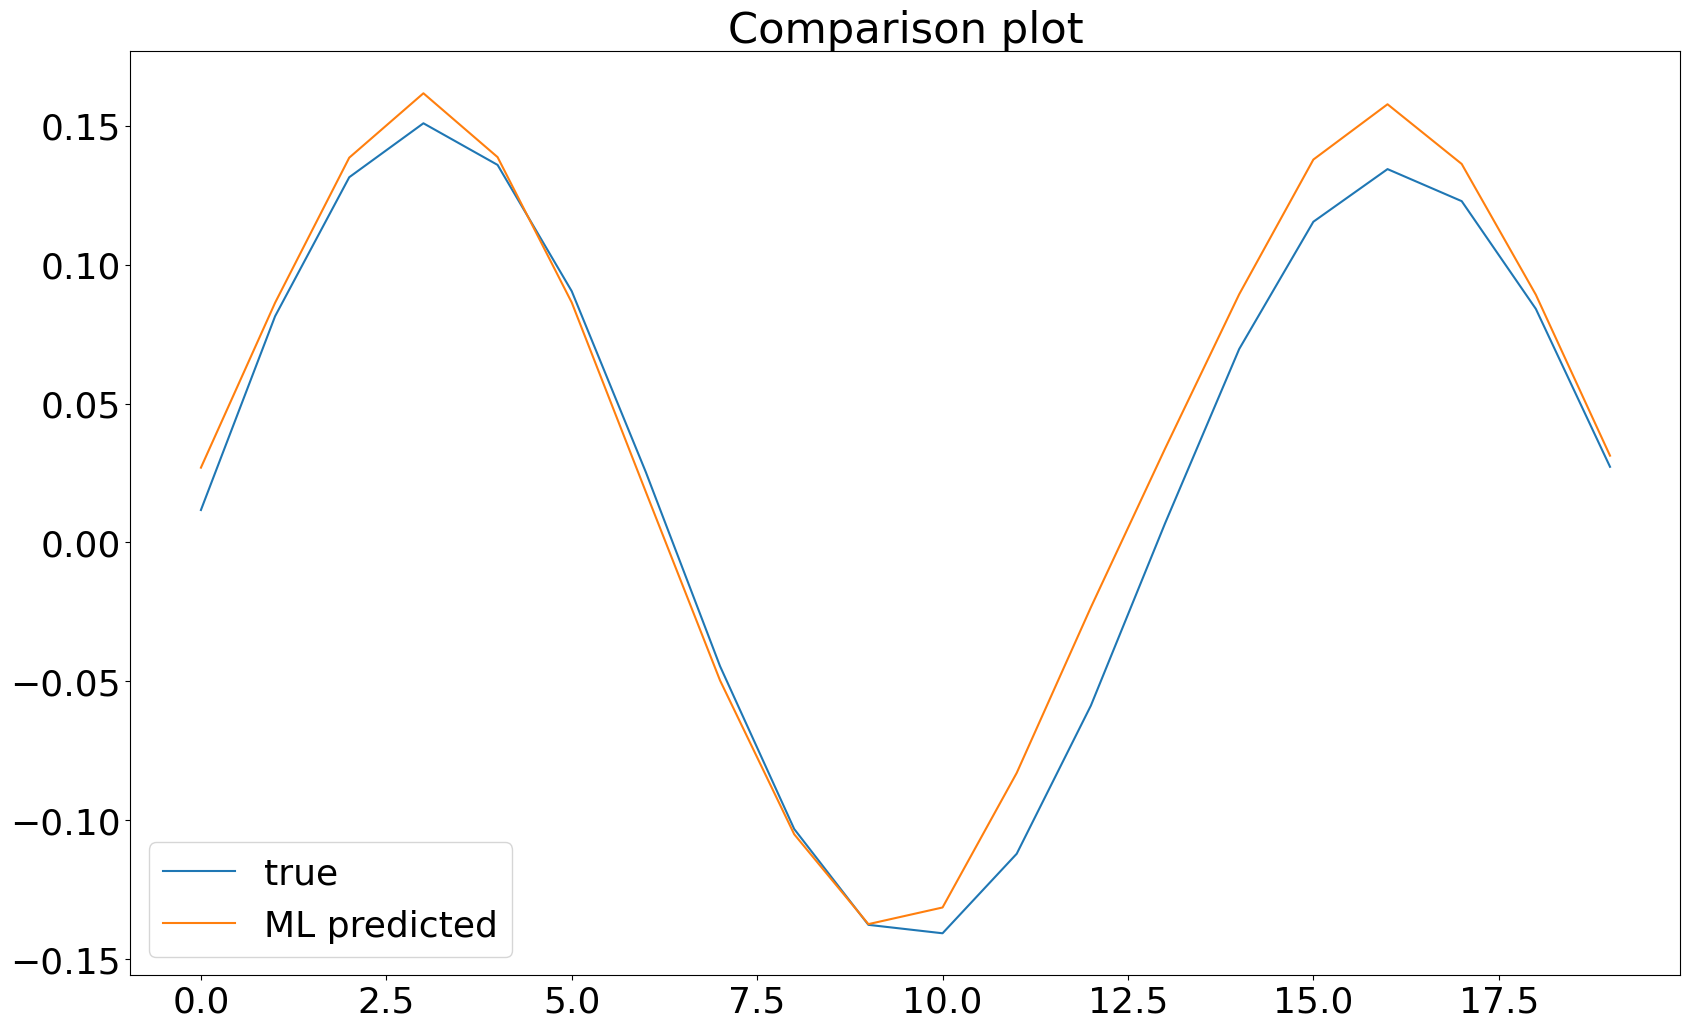

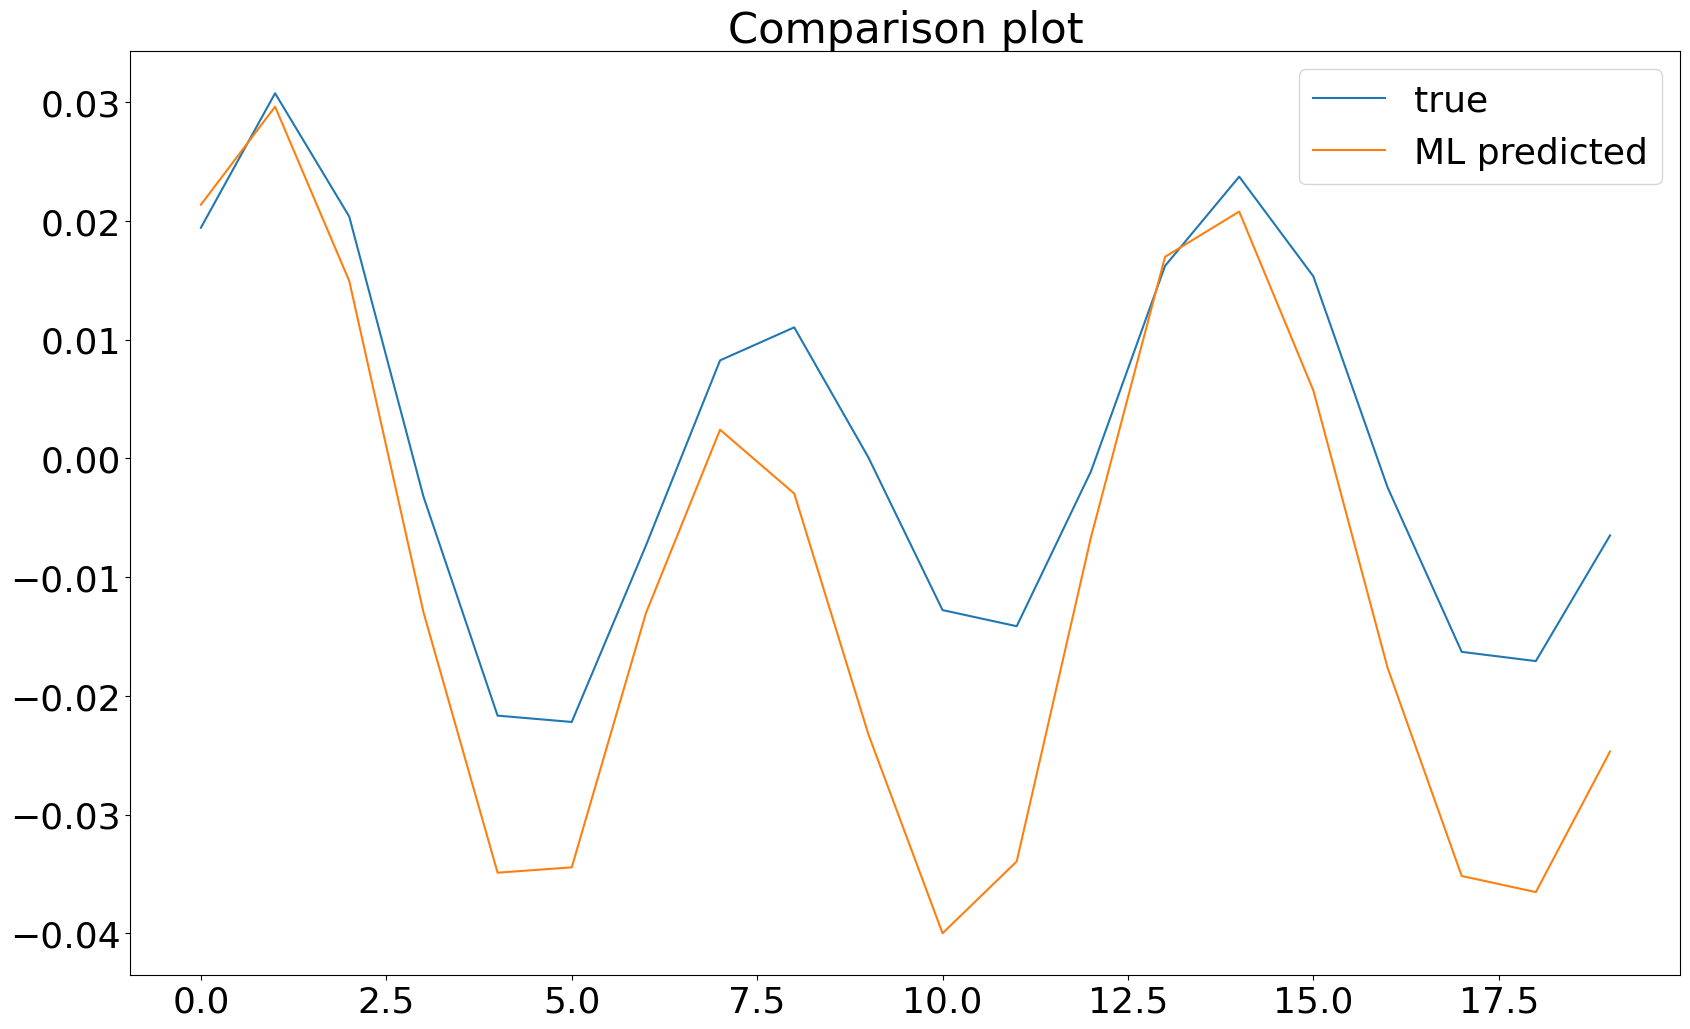

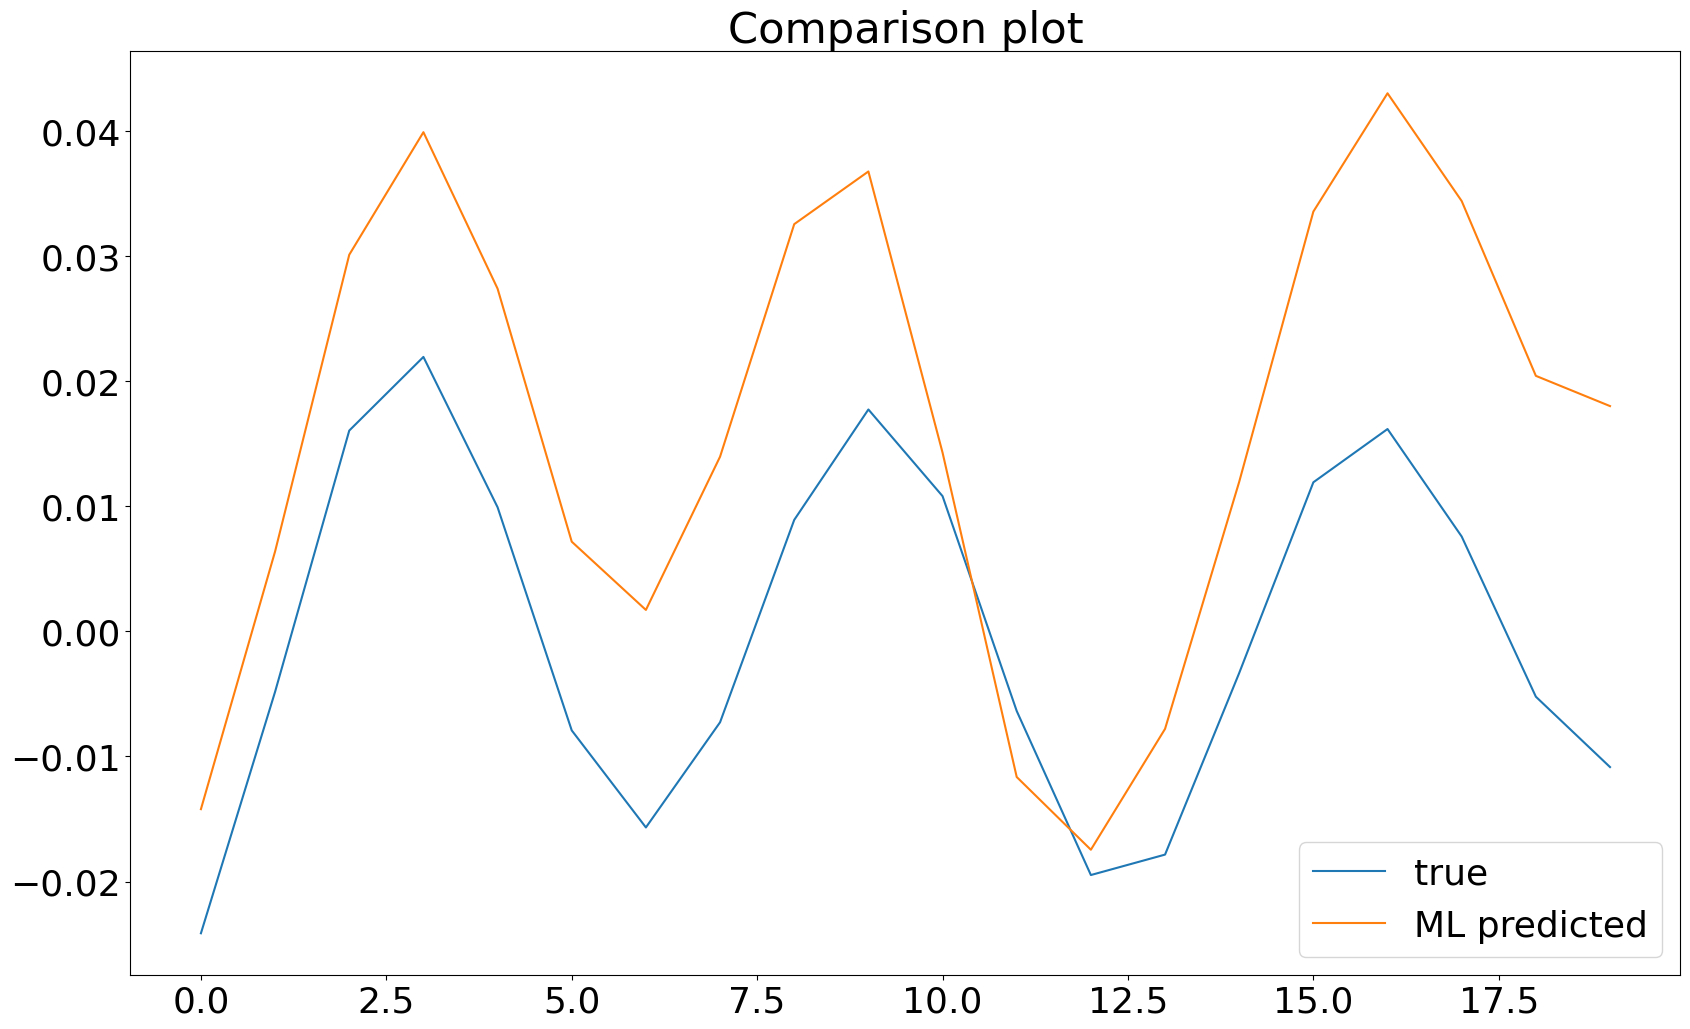

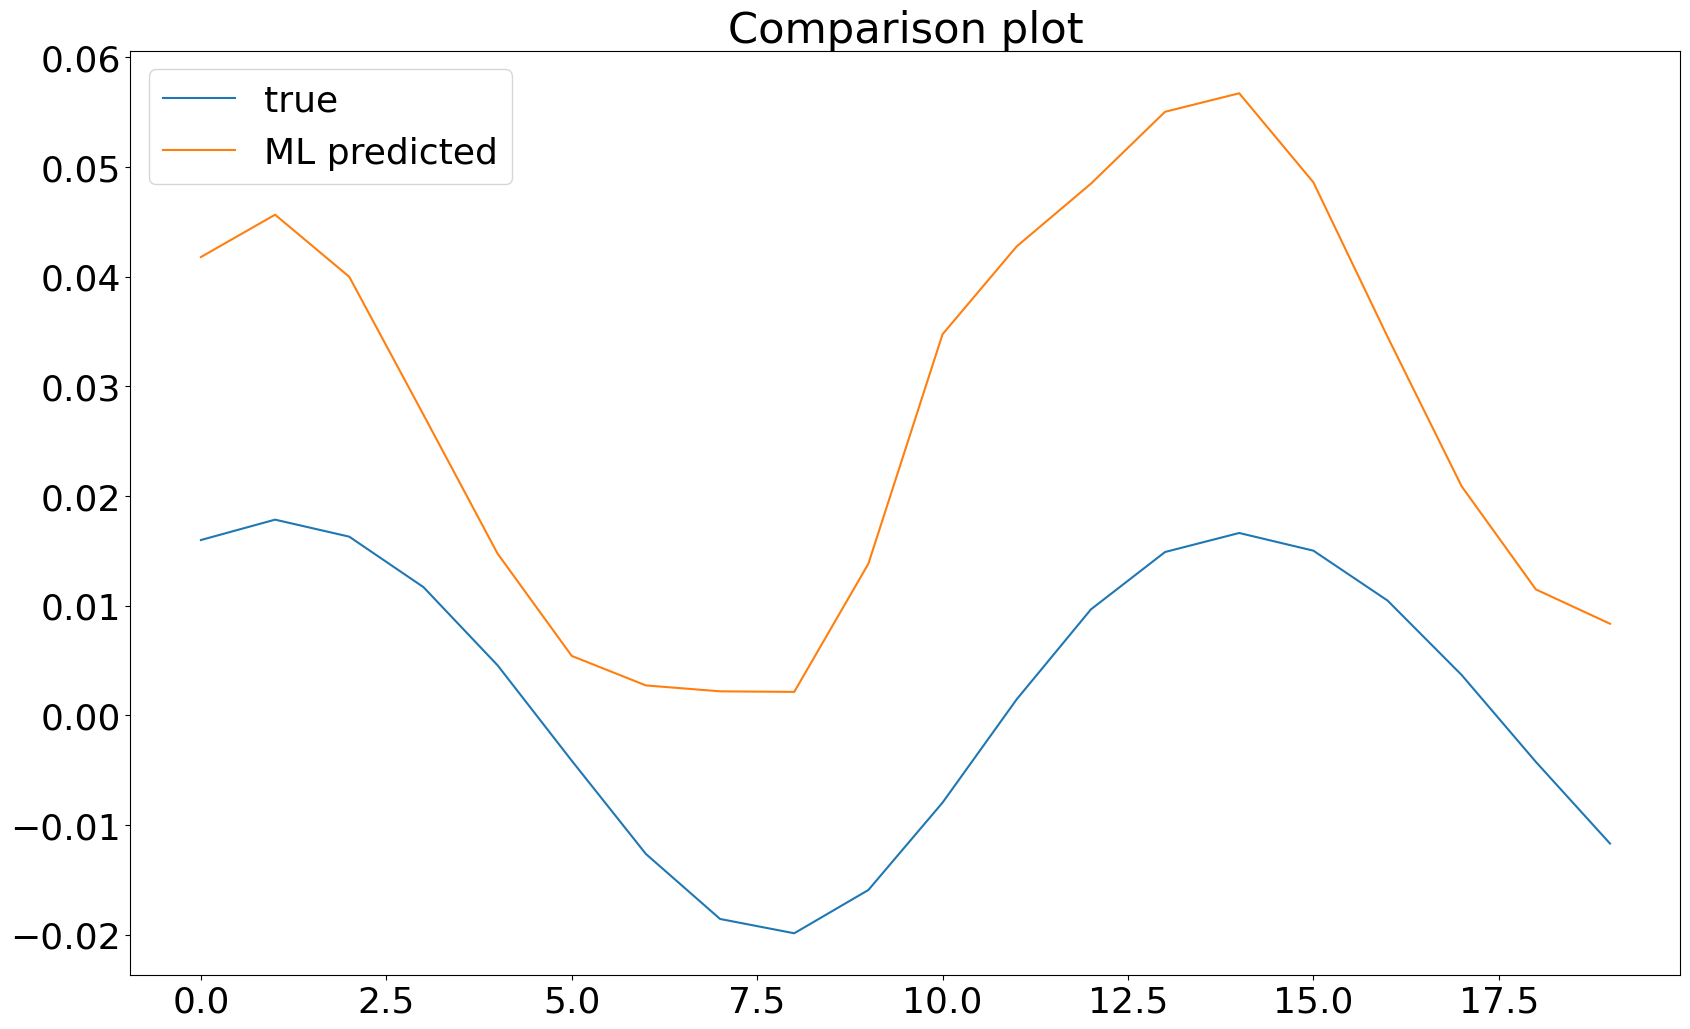

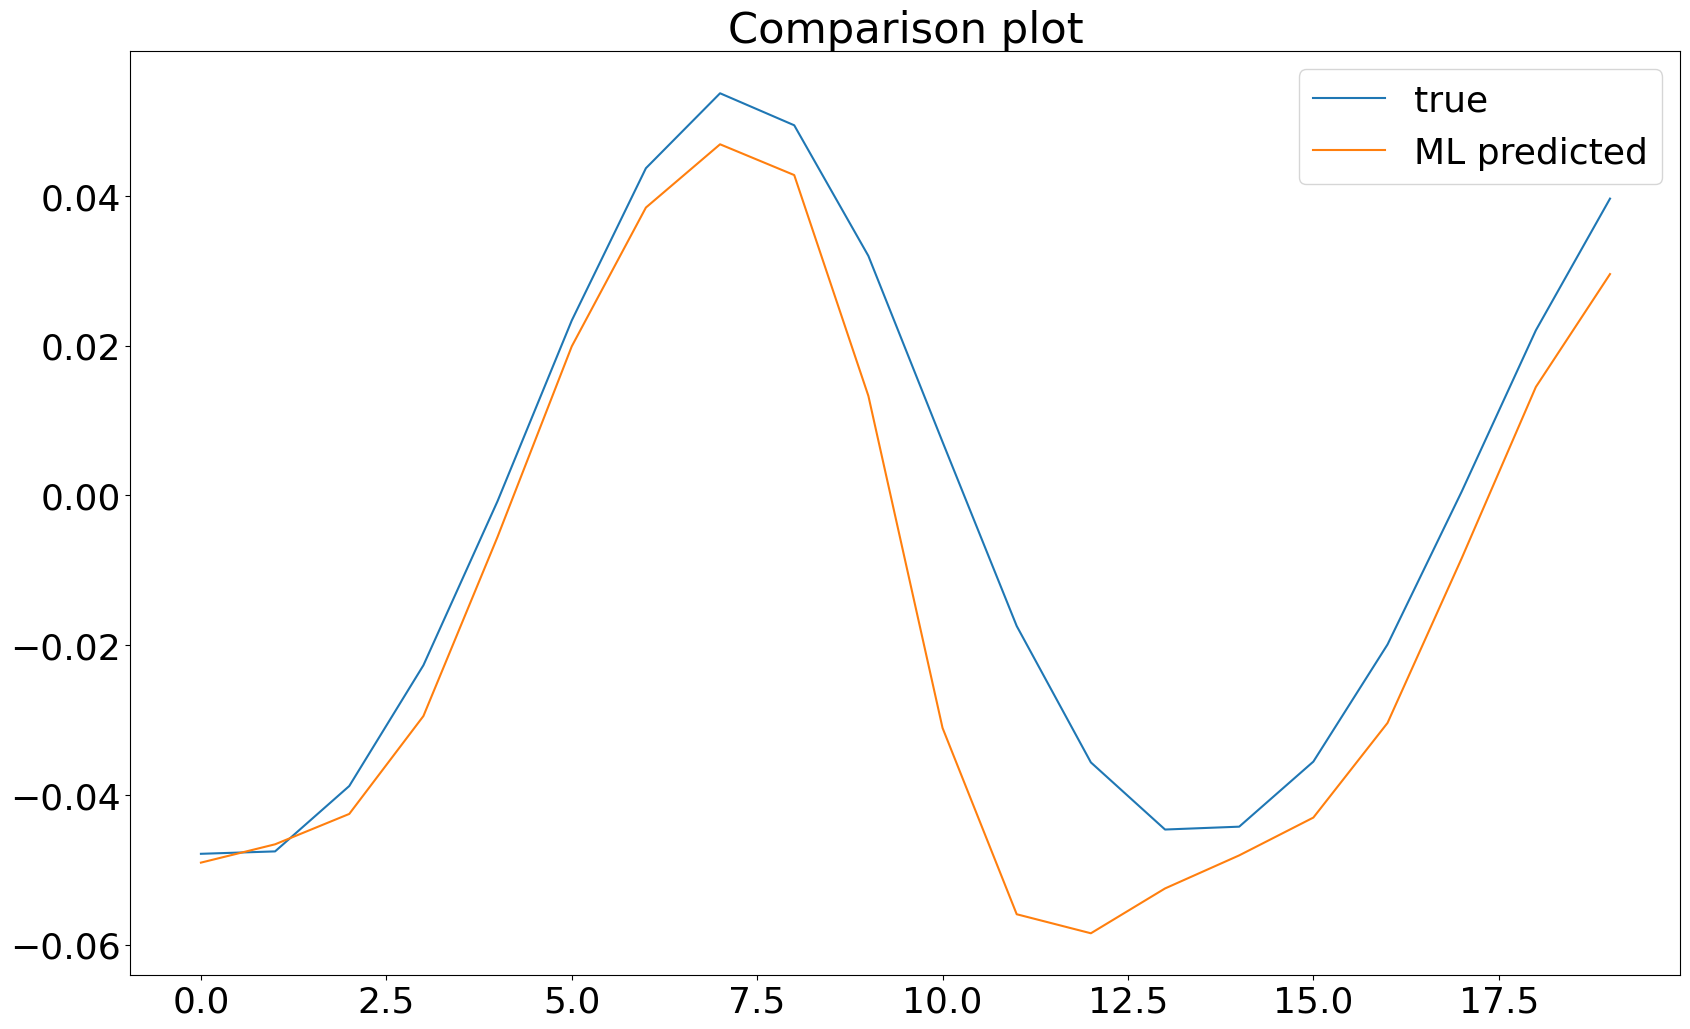

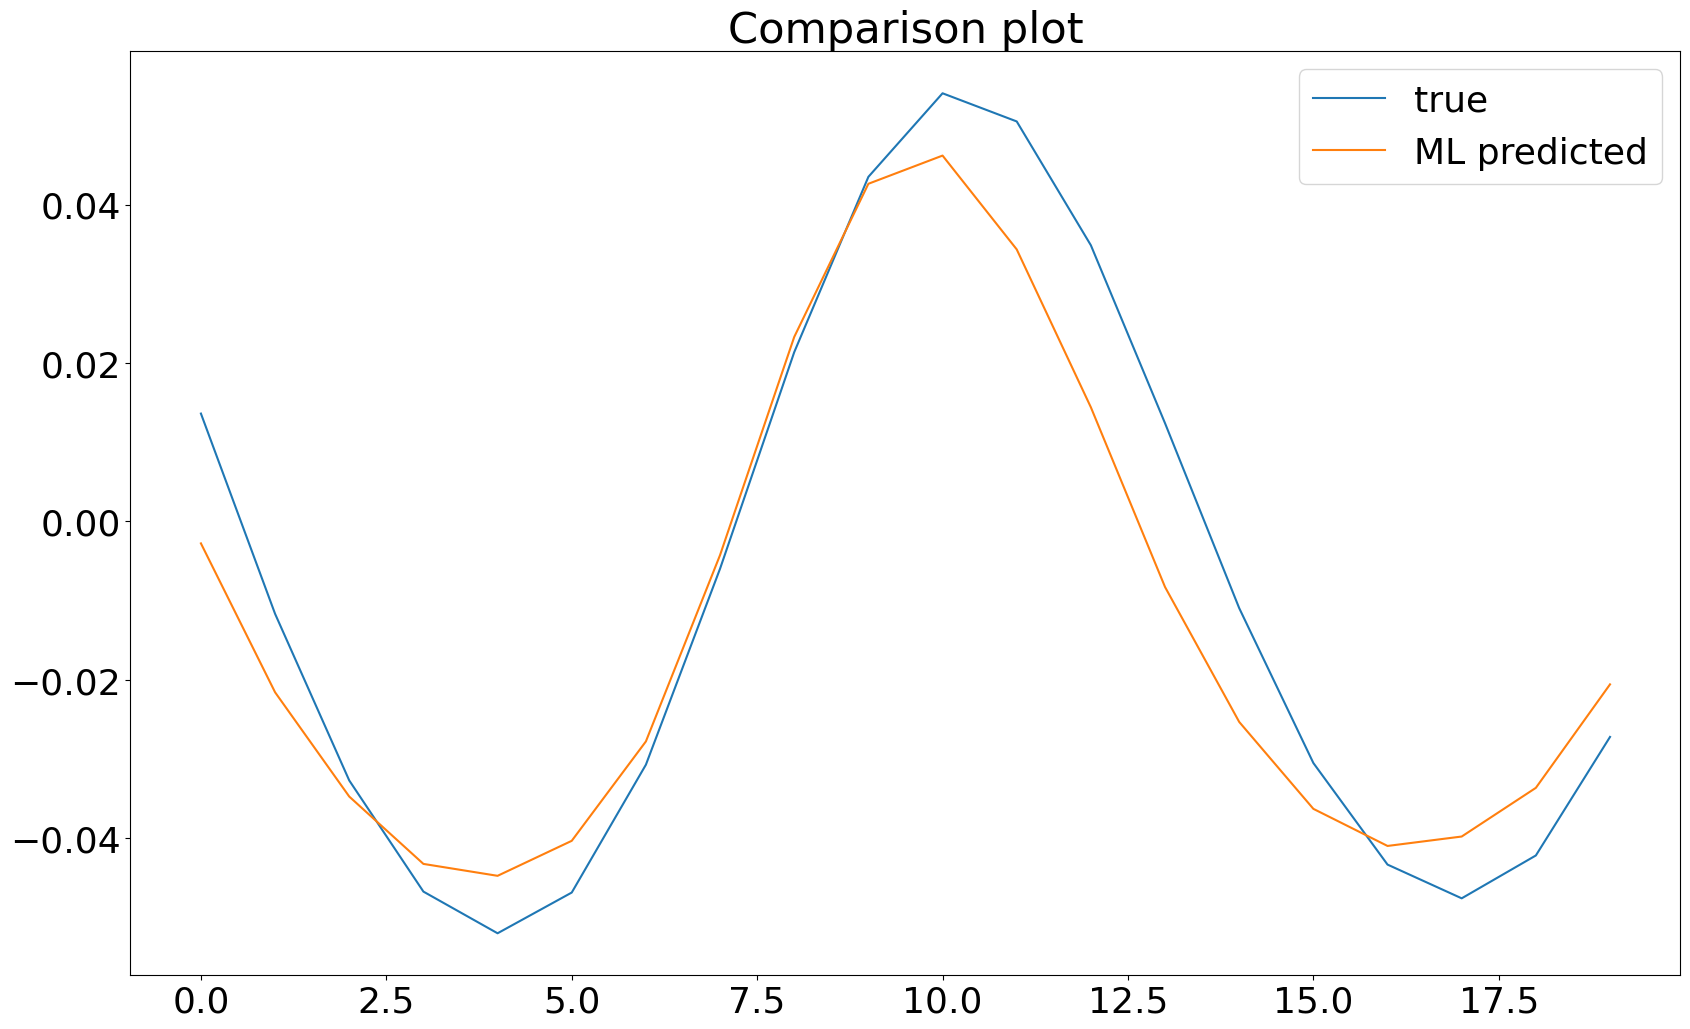

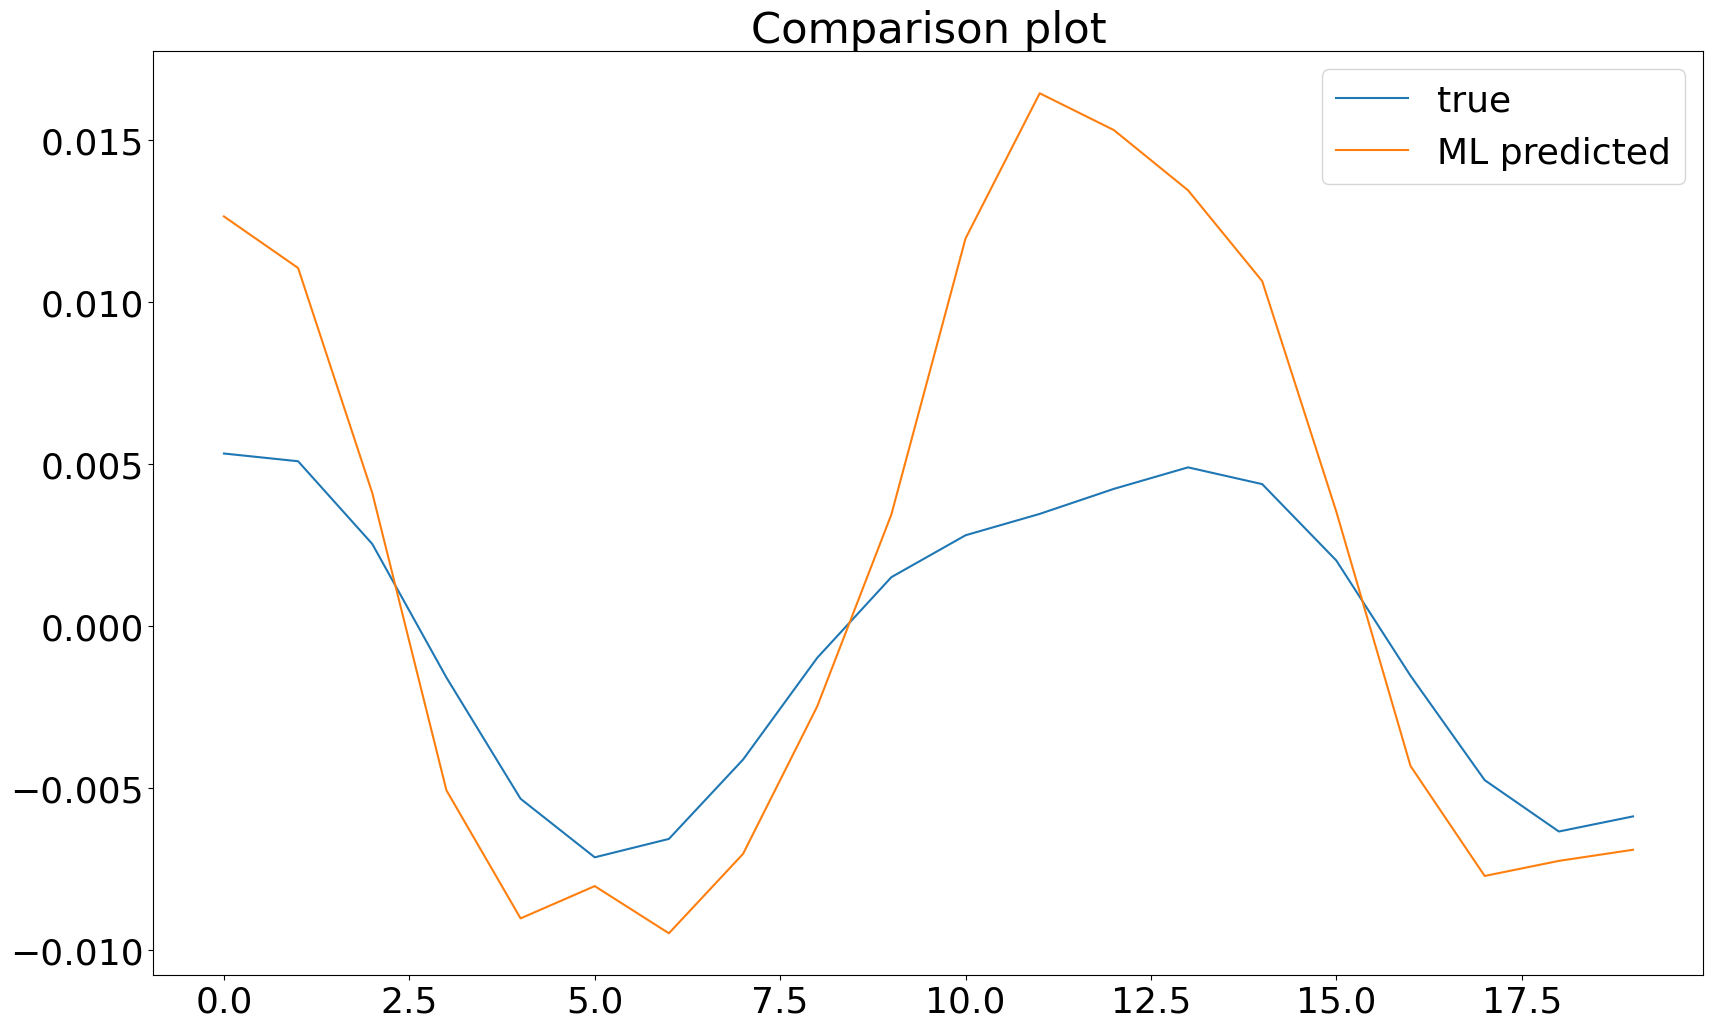

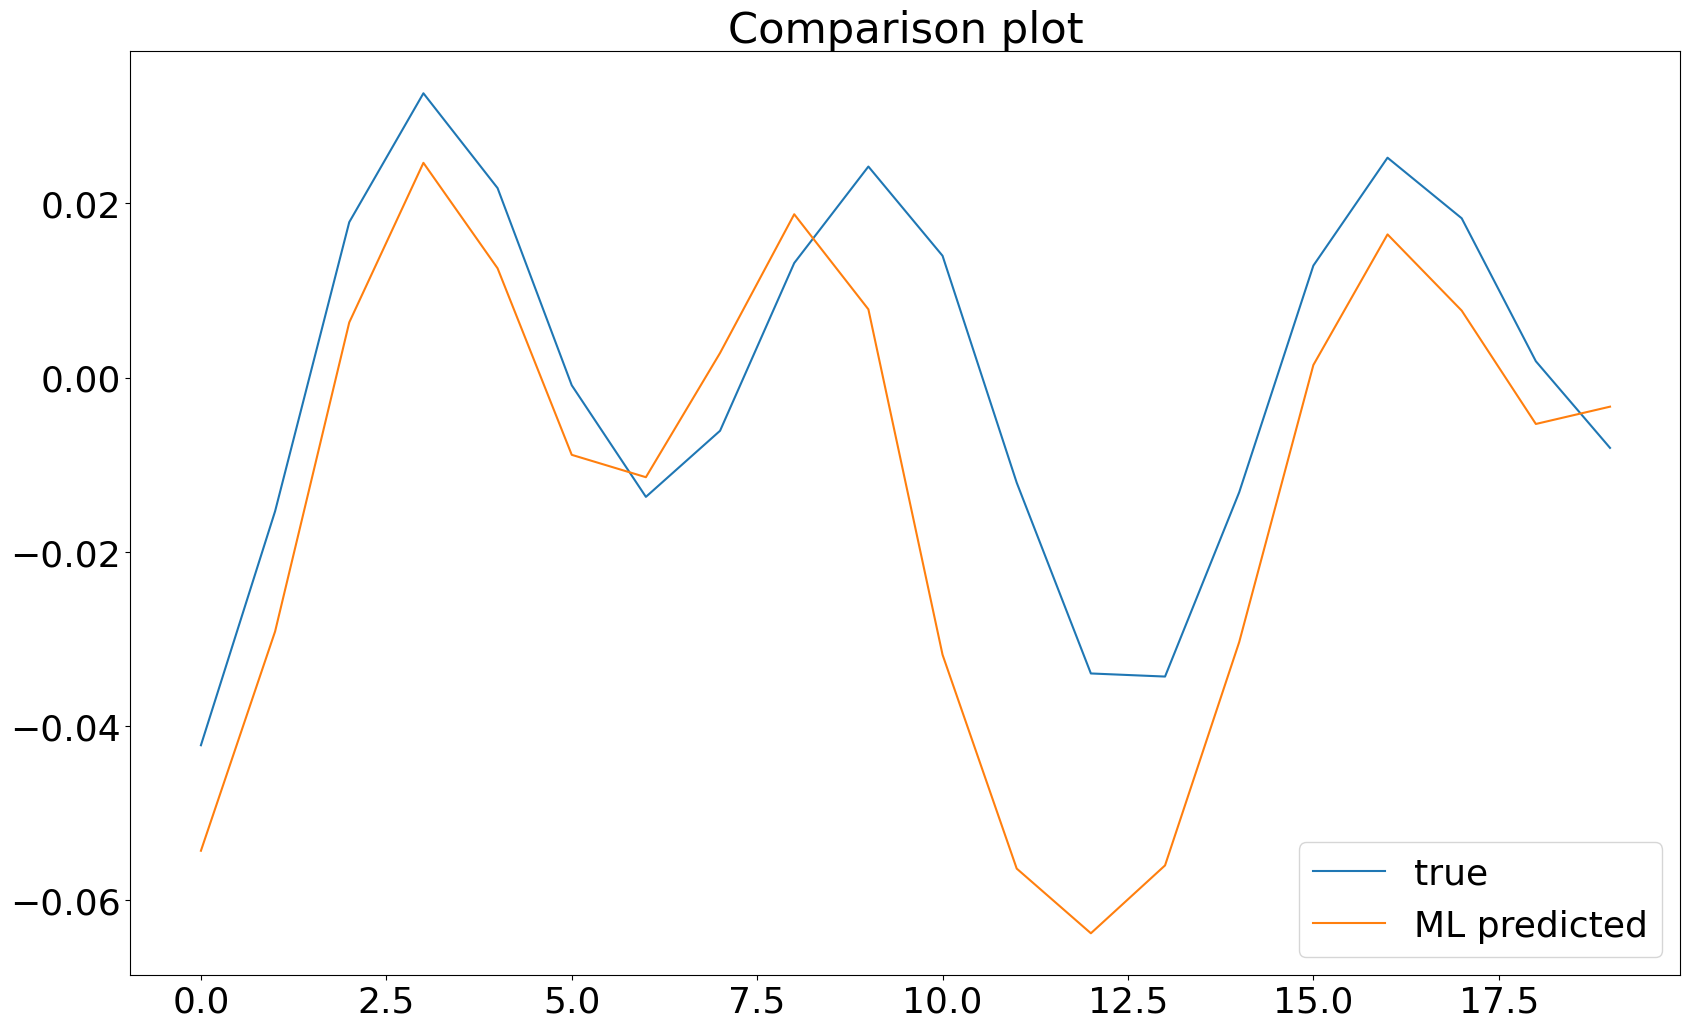

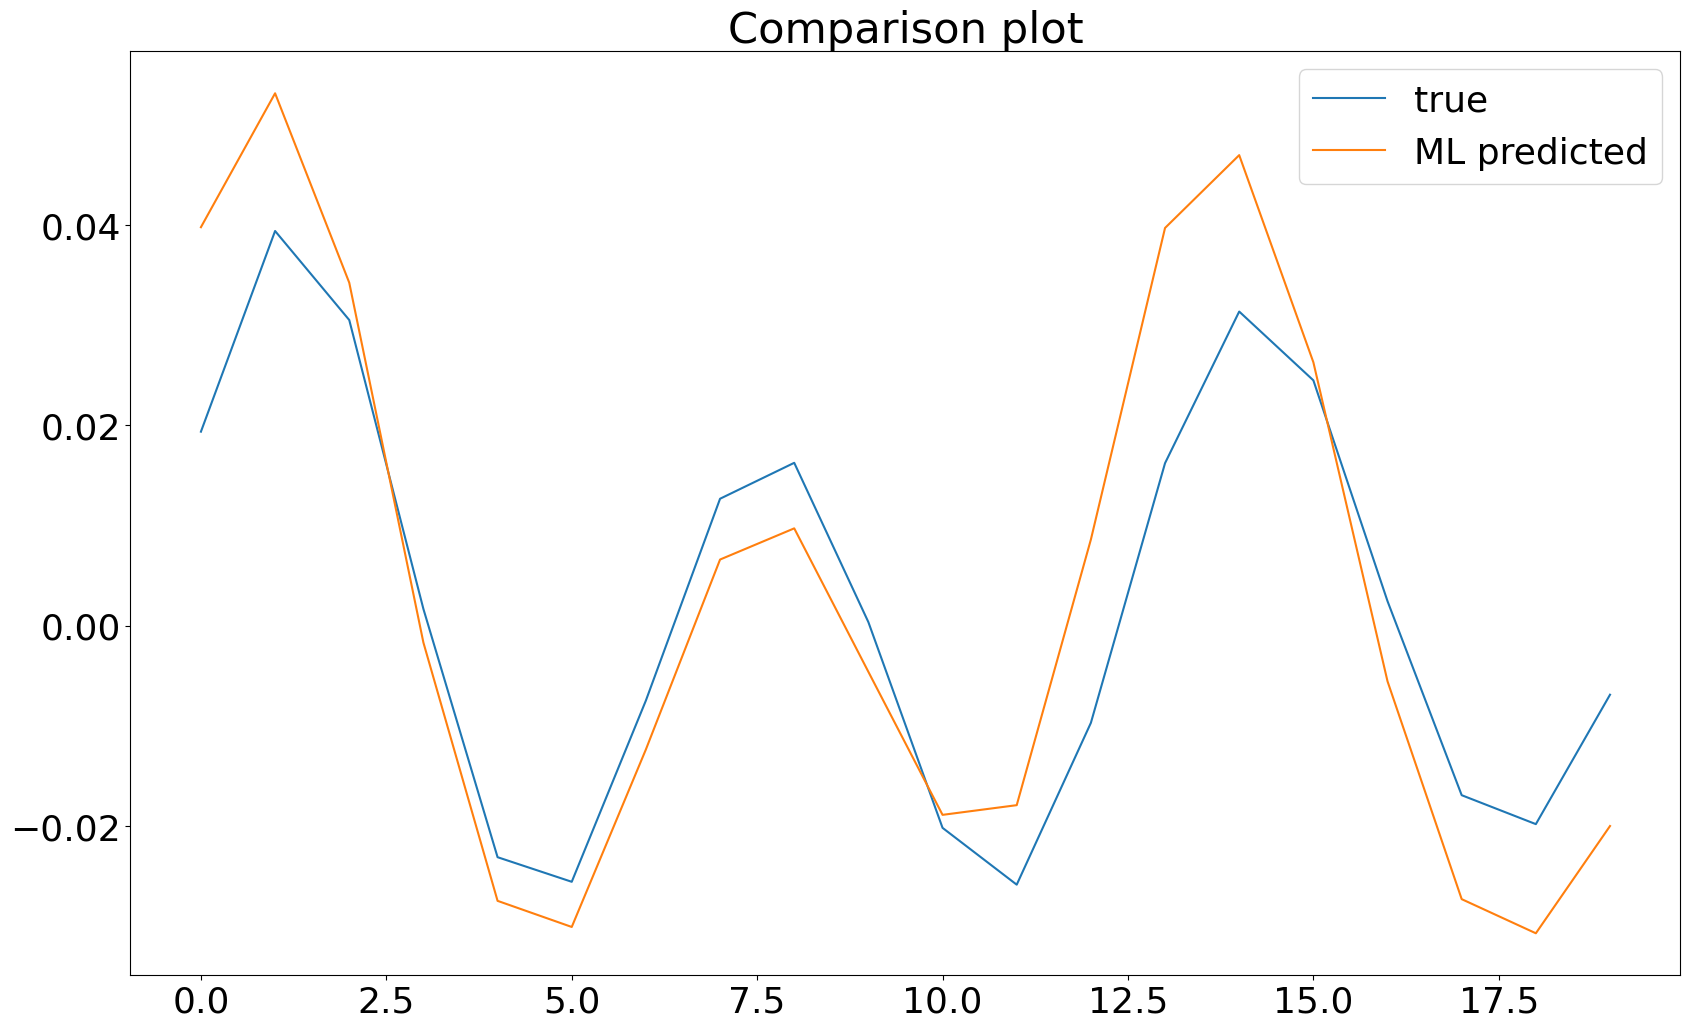

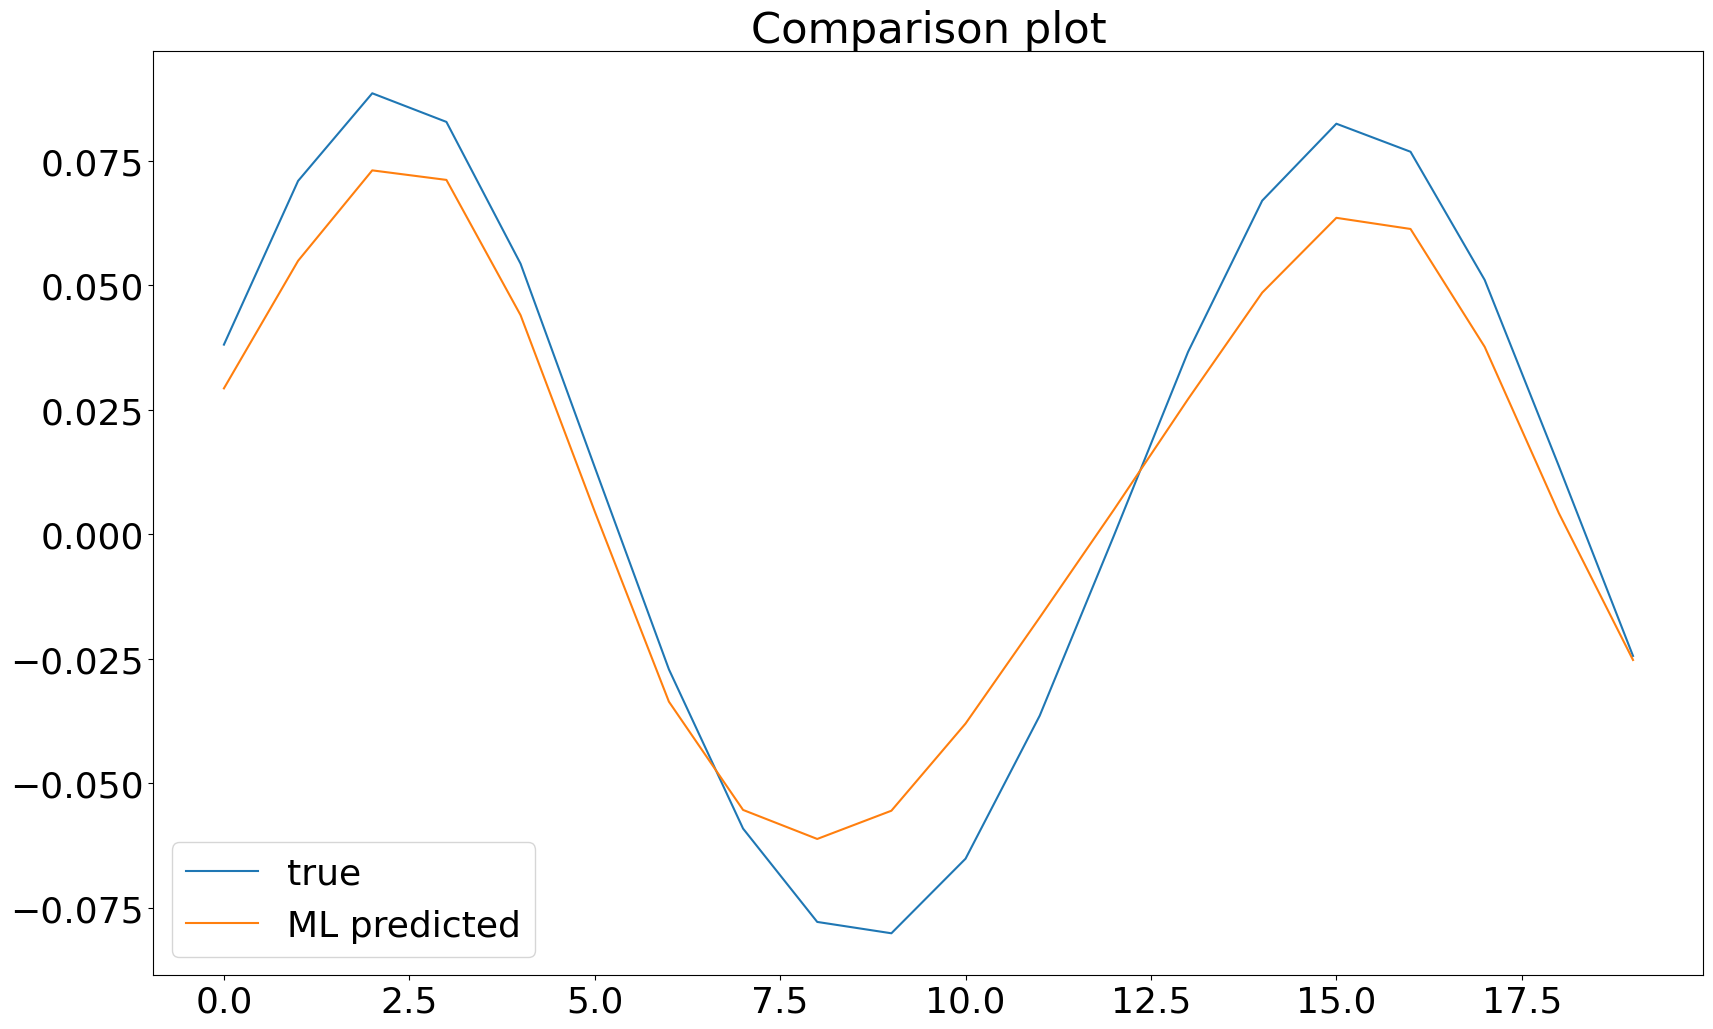

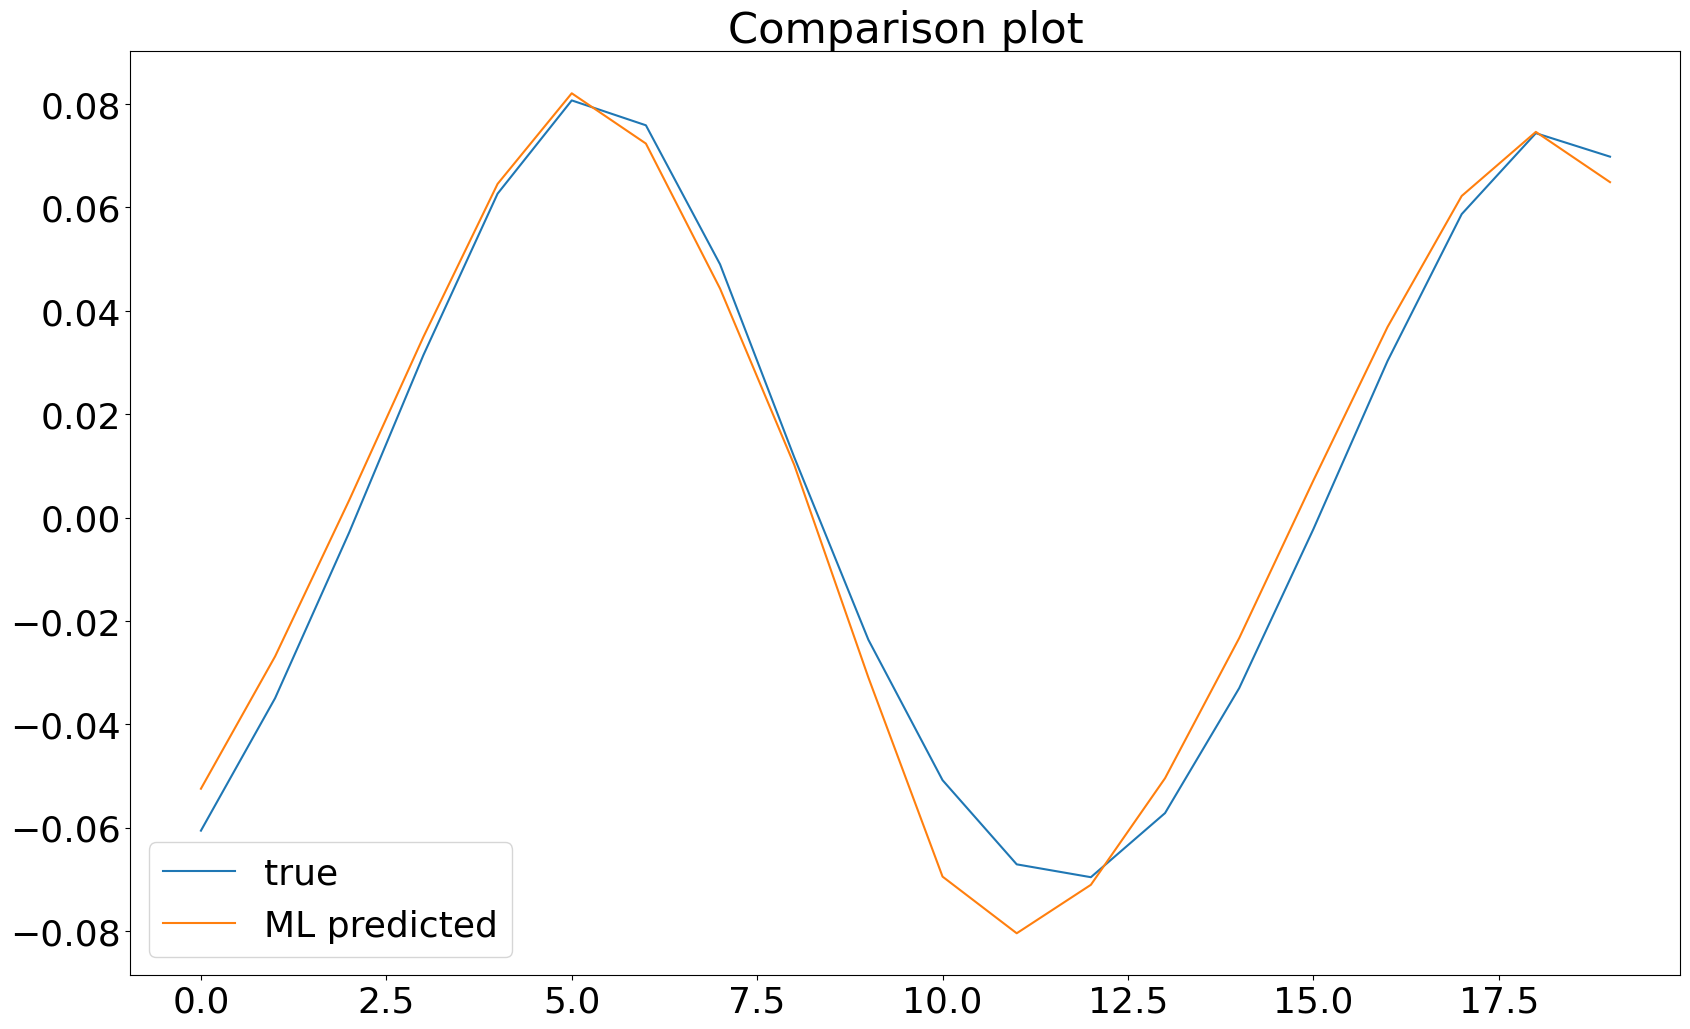

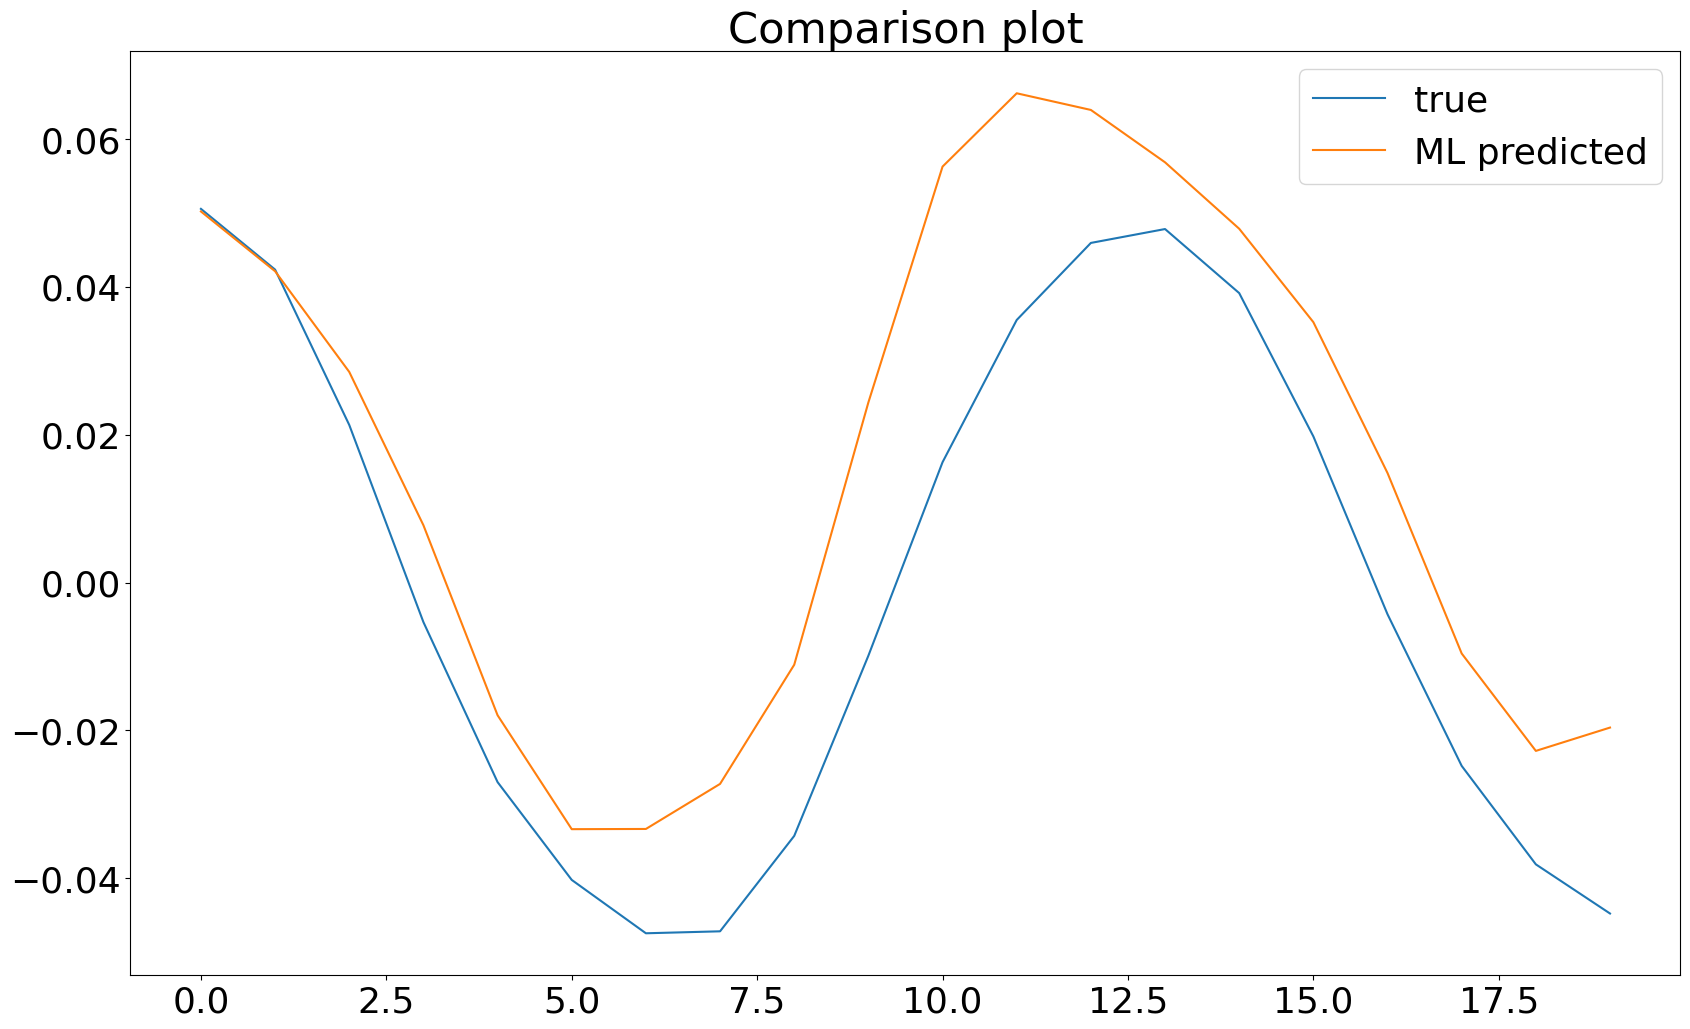

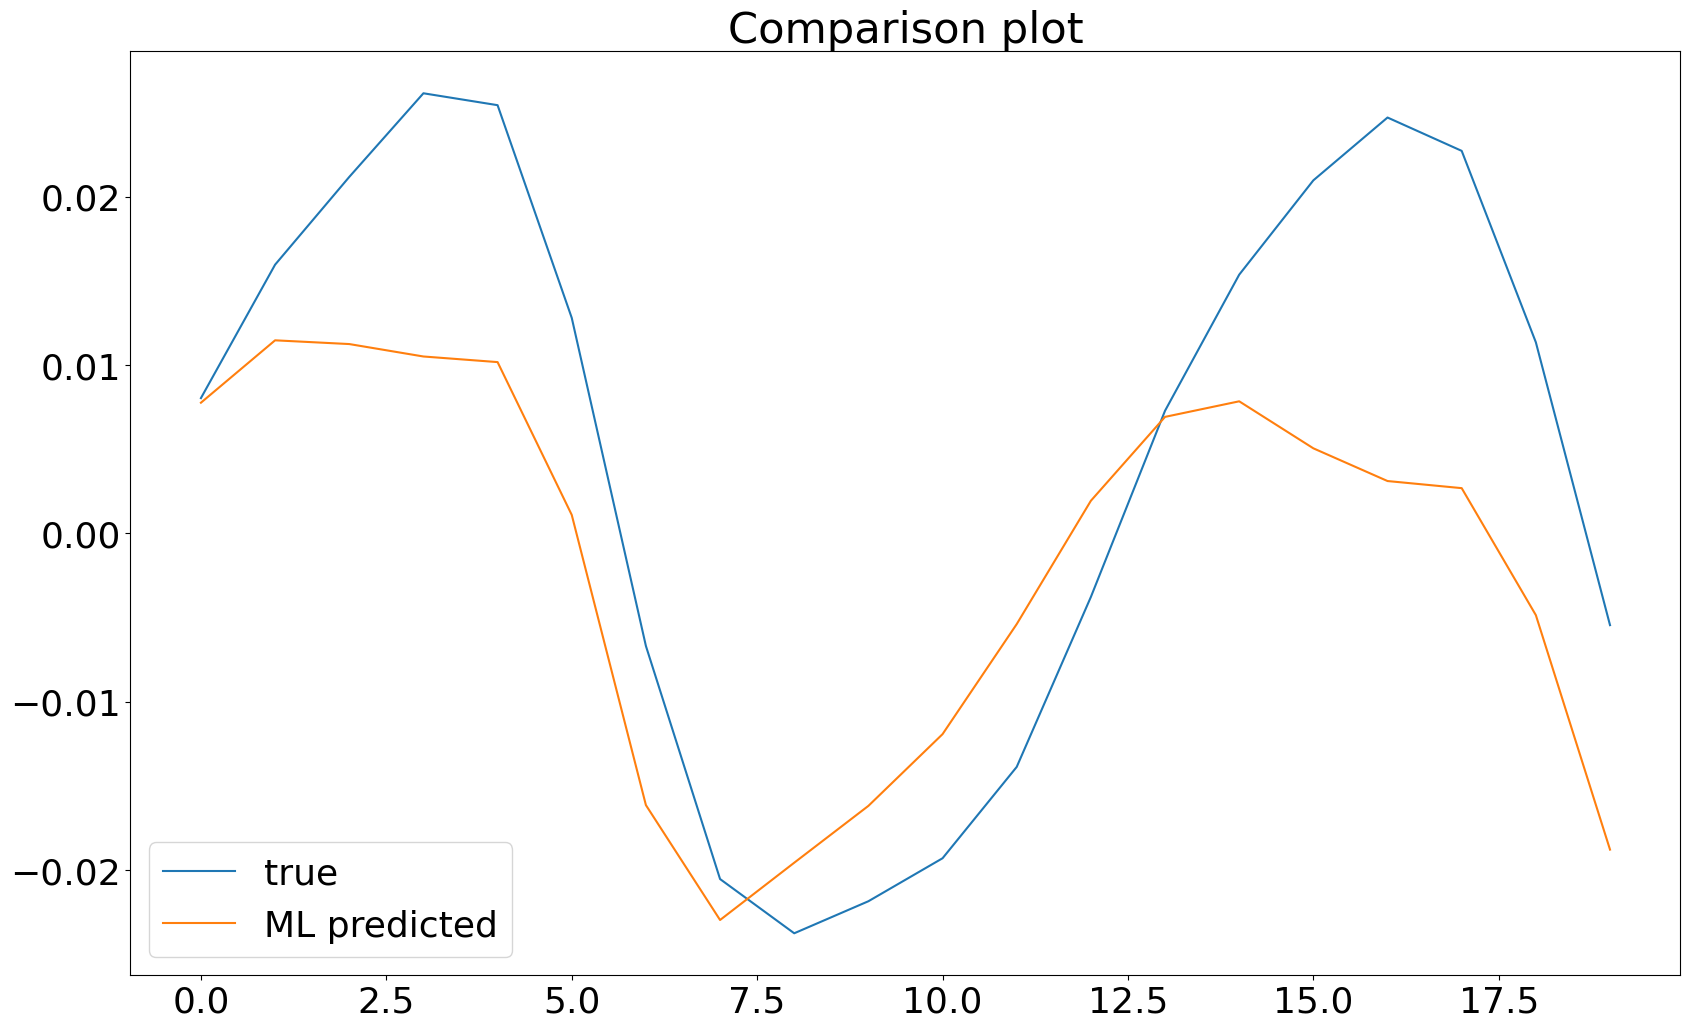

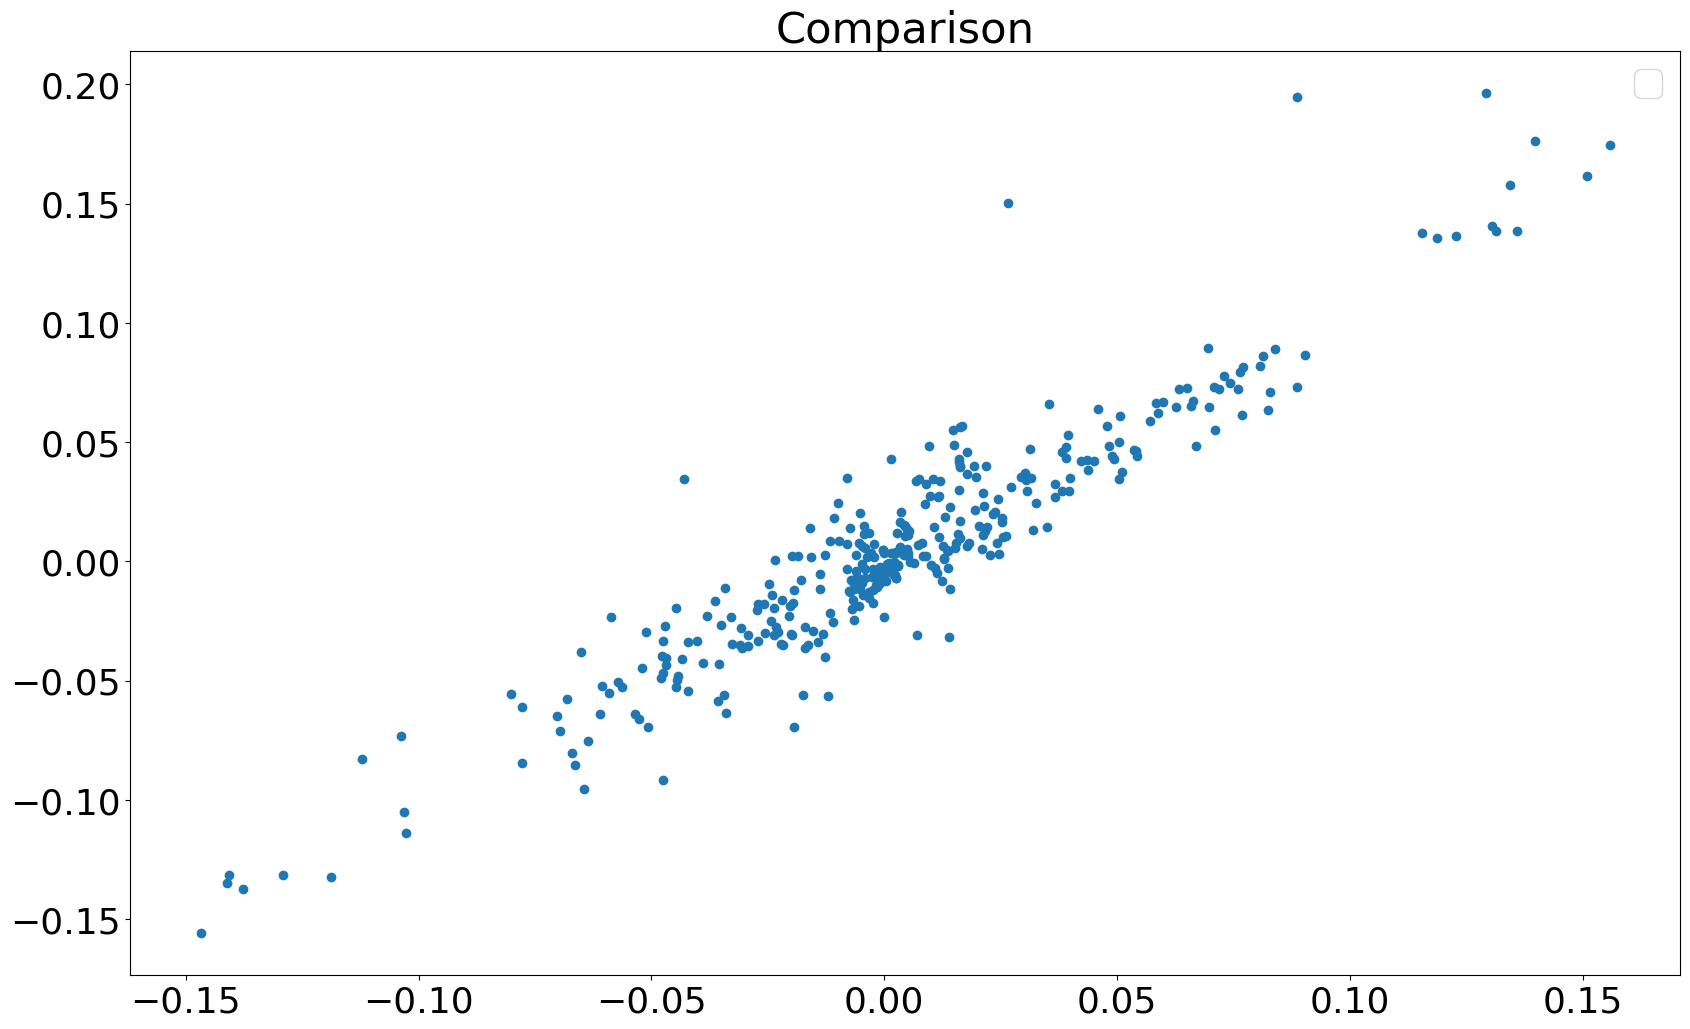

In [29]:
# Inference
#Load model
model3=kpn.tf.keras.models.load_model(dirFile+'/best_model.h5')
model3.count_params()
model3.summary()
  
#Load and scale the test dataset.  
 
print("xtest,xtrain are NOT scaled. BUT norm_train_features,norm_test_feature ARE SCALED. So we scale xtest.")
print("ytest,ytrain are labels and NO scaling is NEEDED for them.")

#xtest shape: 20 x 3 x 18 for momentum. Scaled below for demonstrating inference.
normalizer_test=kpn.joblib.load(filename_4_scalingfunction)  
norm_test_features=kpn.scale_3D_inference(xtest,normalizer_test) # data_test_features
      
# Evaluate the model on train and test data
scores = model3.evaluate(norm_test_features, ytest, verbose=0)
print("%s: %.2f%%" % (model3.metrics_names[1], scores[1]*100))

#Predict model
addcorrection=model3.predict(norm_test_features) #nOTE USED OF SCALED FEATURE AS ARGUEMENT.

#Compare with ytest
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(addcorrection,ytest)
print(f"Mean Absolute Error LSTM ensemble {mae}")
mse = mean_squared_error(addcorrection,ytest)
print(f"Mean Squared Error LSTM ensemble: {mse}")
mape = mean_absolute_percentage_error(ytest,addcorrection)
print(f"Mean Absolute Percentage Error LSTM ensemble: {mape}")

for i in range(addcorrection.shape[1]):
    kpn.plt.figure(figsize=(20,12))
    kpn.plt.plot(ytest[:,i],label='true')
    kpn.plt.plot(addcorrection[:,i],label='ML predicted')
    kpn.plt.title('Comparison plot')
    kpn.plt.legend()
    filename = f'Comparison plot_{i}.png'
    kpn.plt.savefig(os.path.abspath(dirFile_result+'/'+filename), dpi = 200)
    kpn.plt.show()  

kpn.plt.figure(figsize=(20,12))
kpn.plt.scatter(ytest,addcorrection)
kpn.plt.title('Comparison')
kpn.plt.legend()
filename = 'Comparison.png'
kpn.plt.savefig(os.path.abspath(dirFile_result+'/'+filename), dpi = 200)
kpn.plt.show()   


Mean Absolute Error LSTM ensemble 0.004035442466049363
Mean Squared Error LSTM ensemble: 4.763994933198792e-05
Mean Absolute Percentage Error LSTM ensemble: 0.8179128769030102


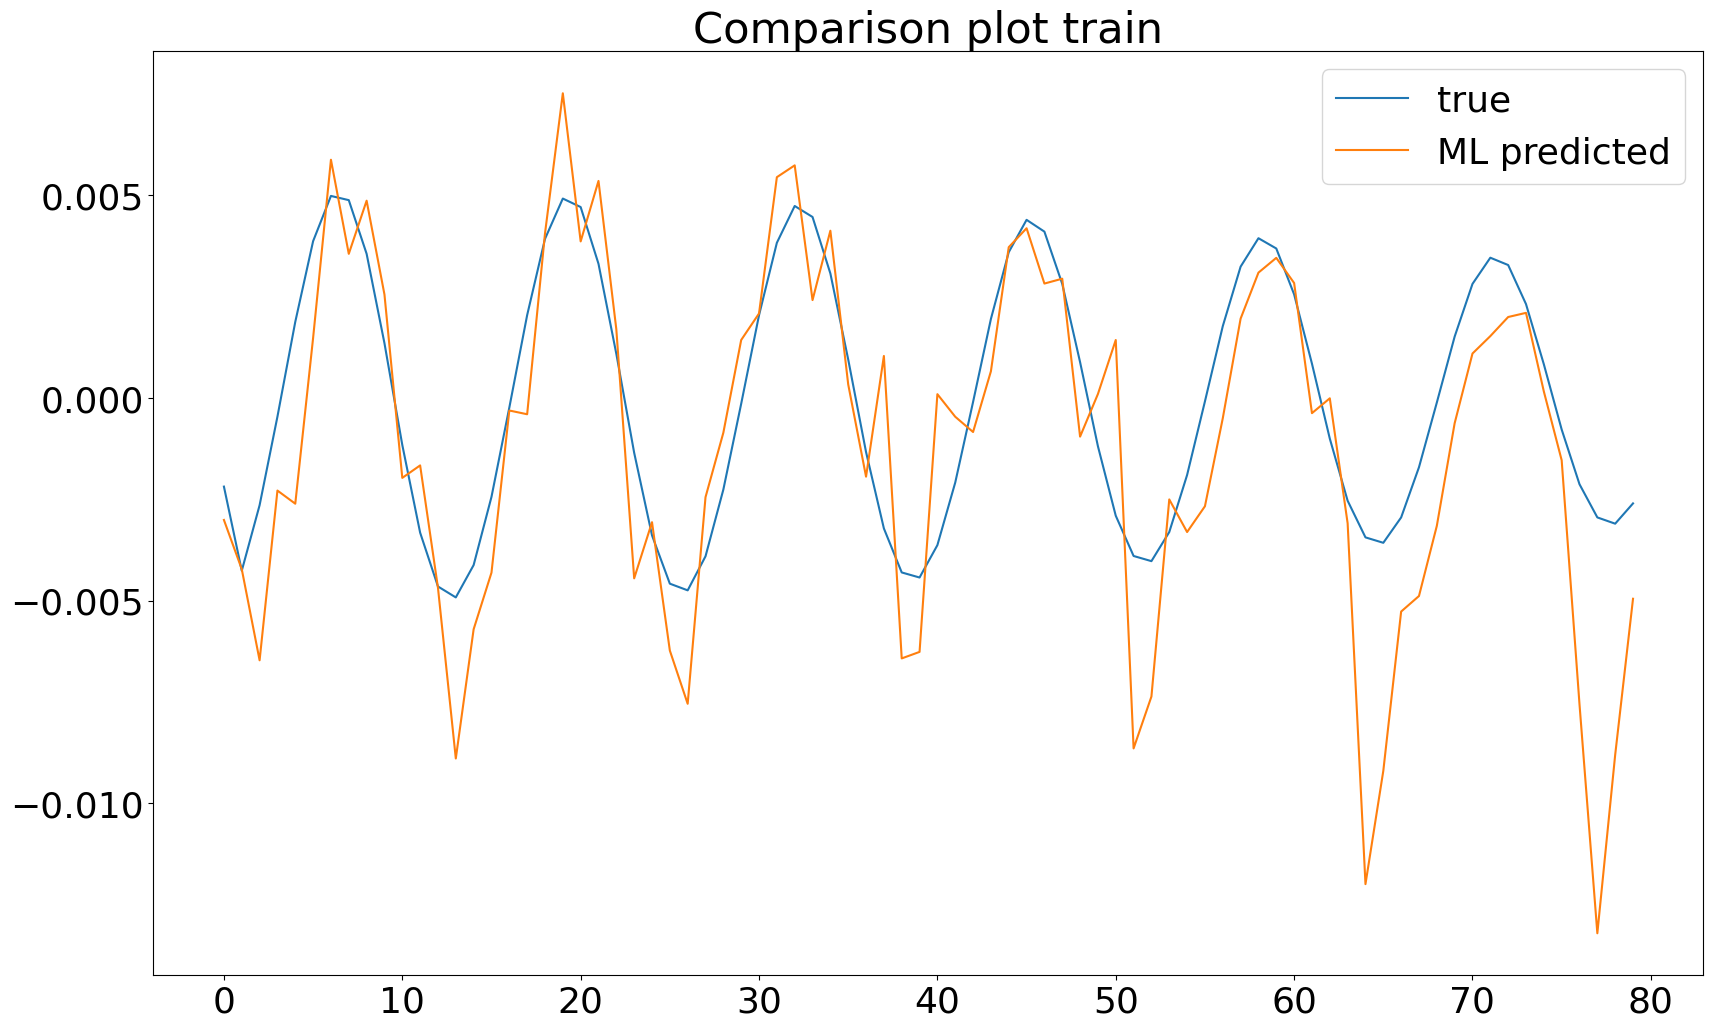

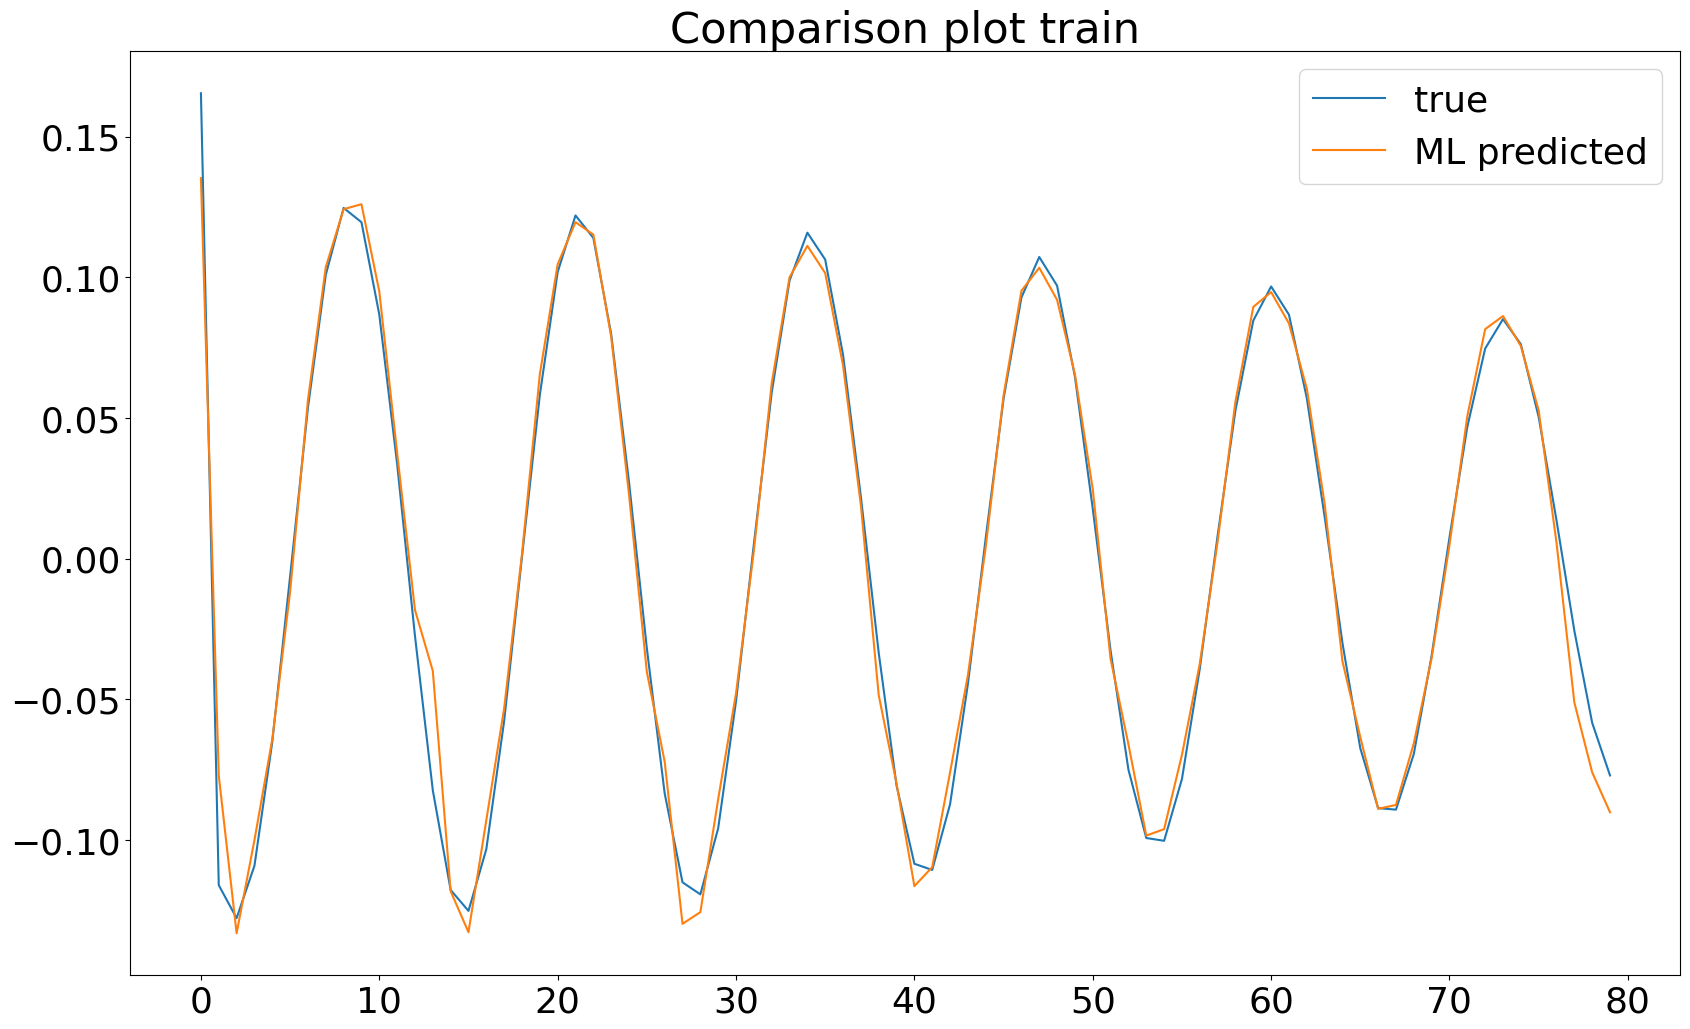

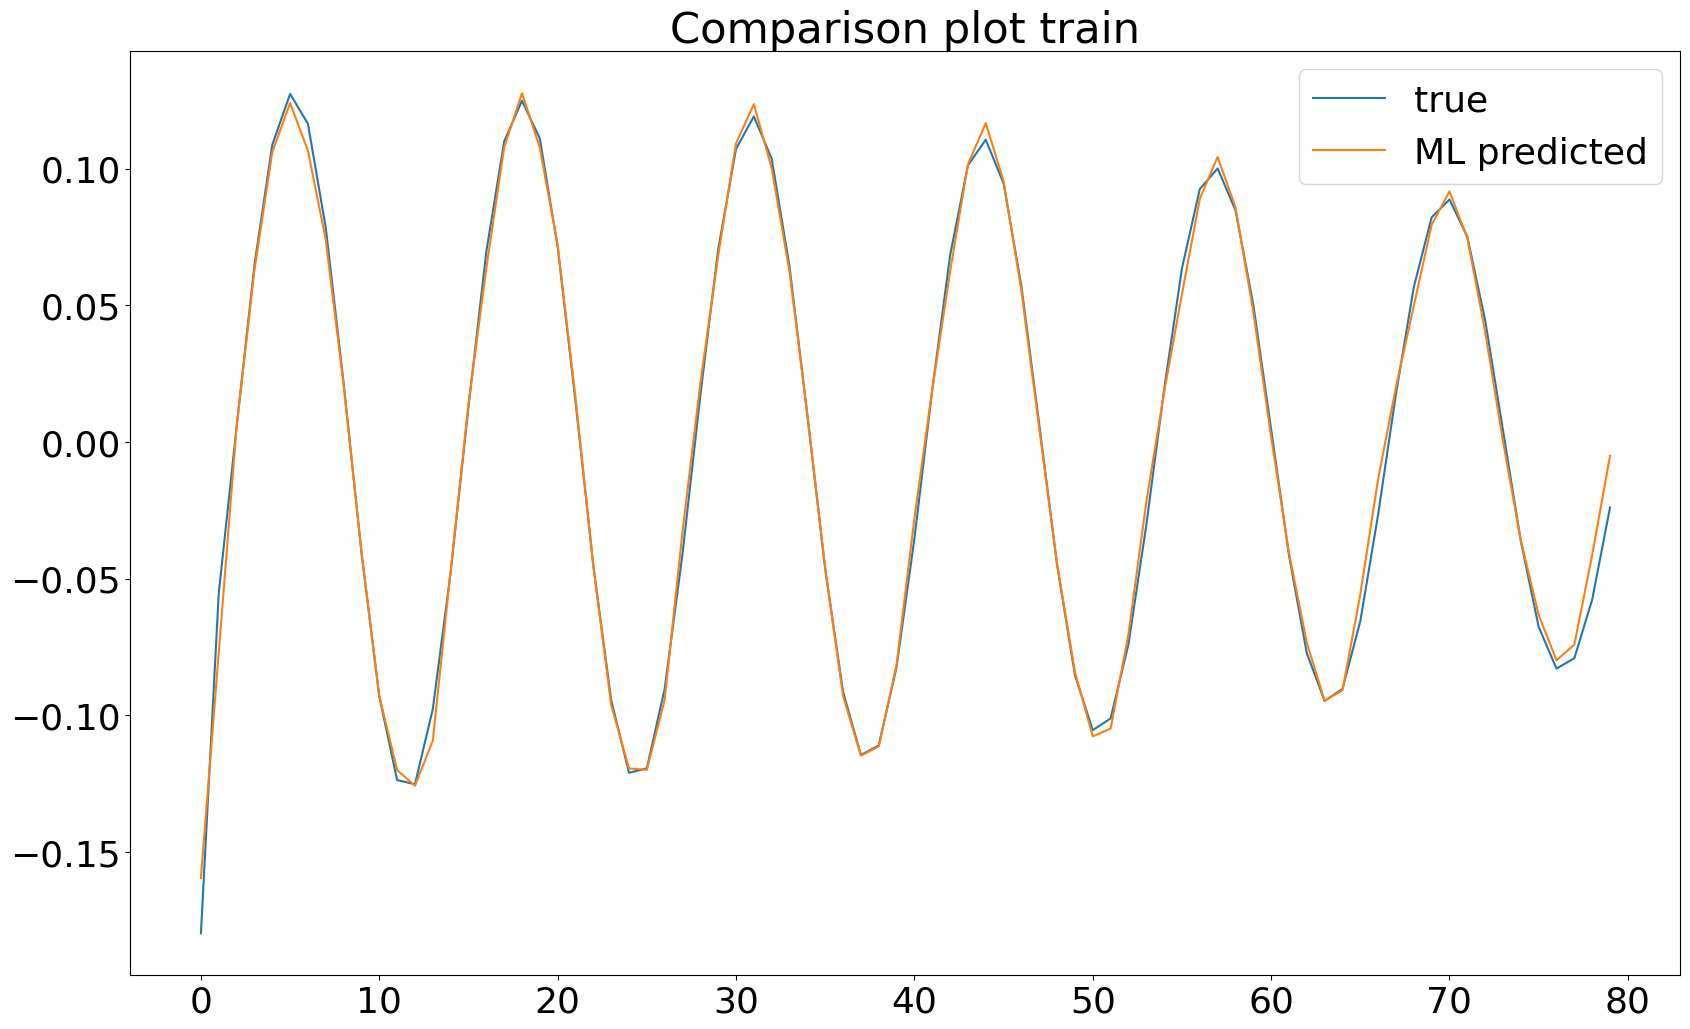

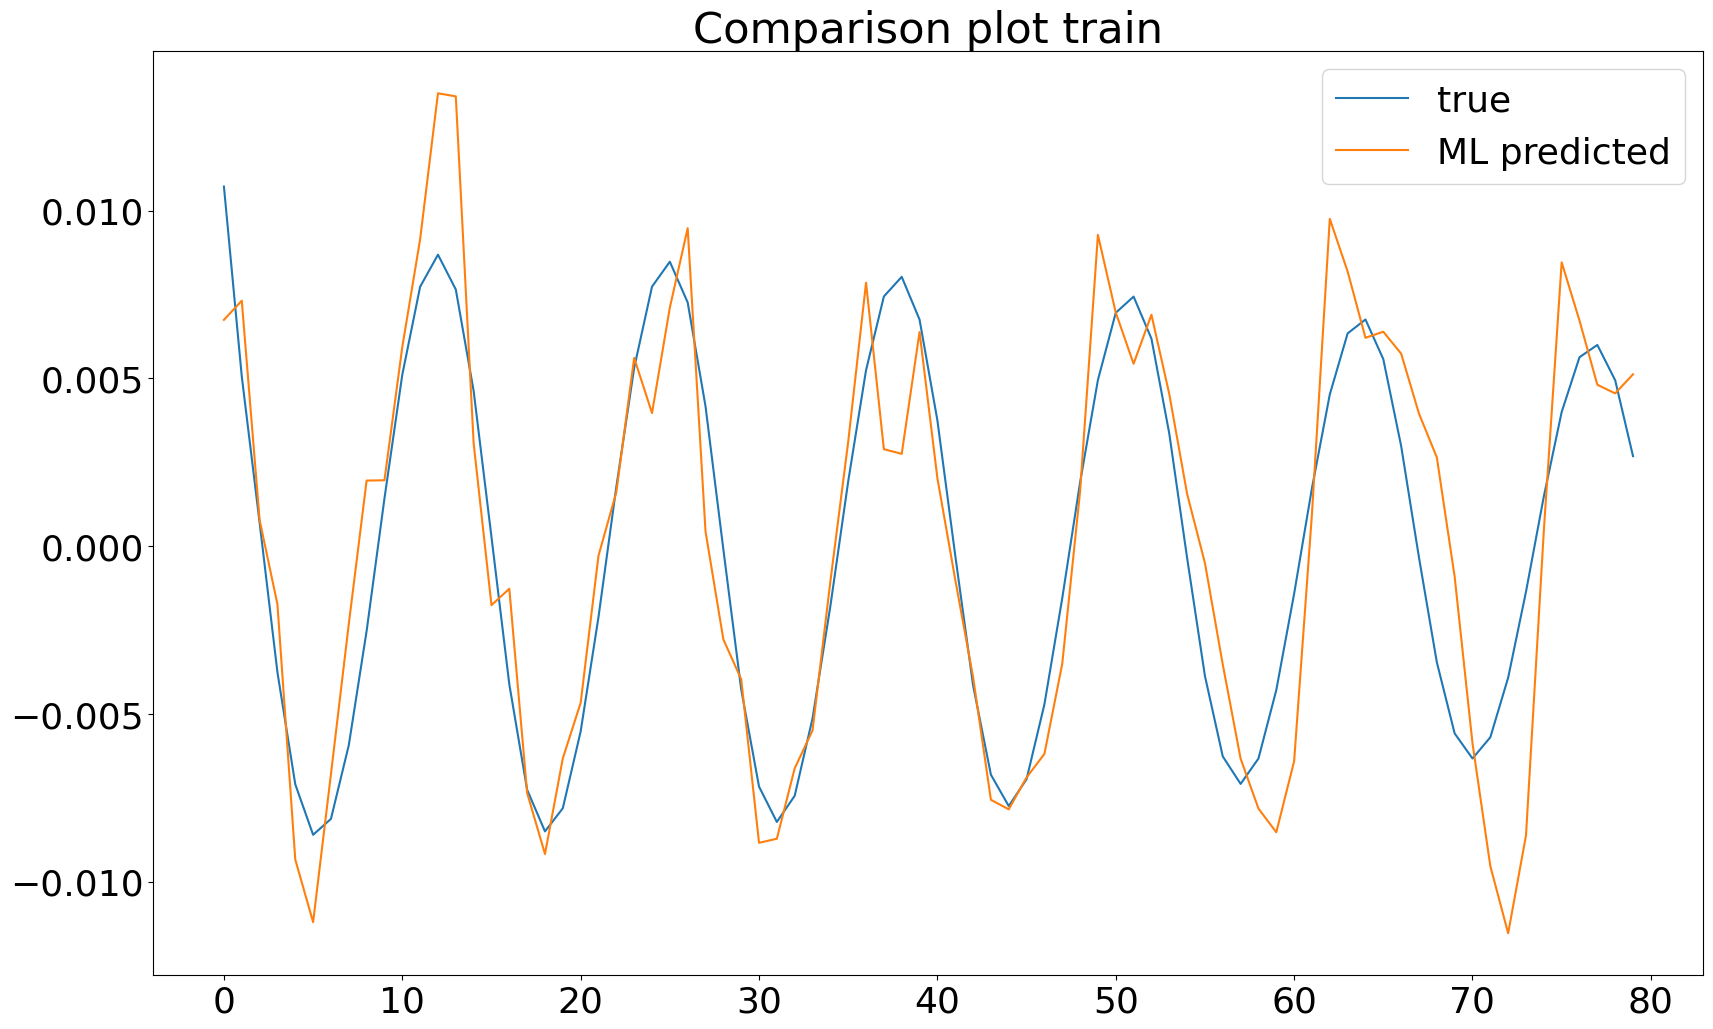

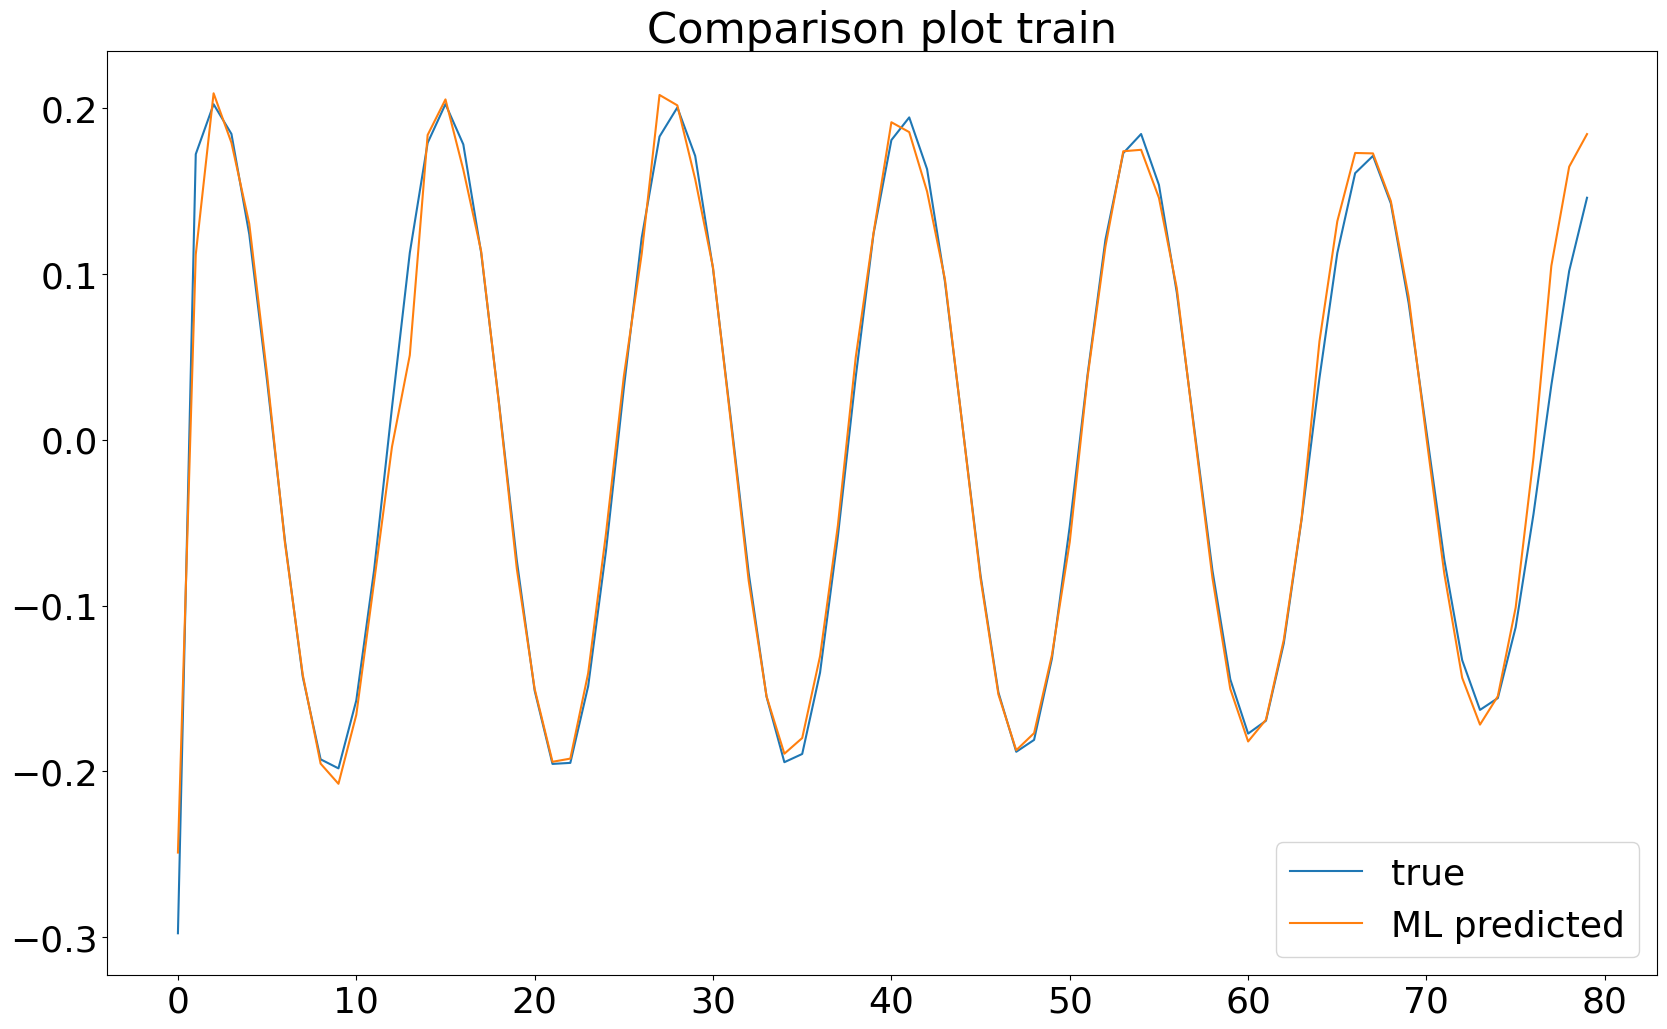

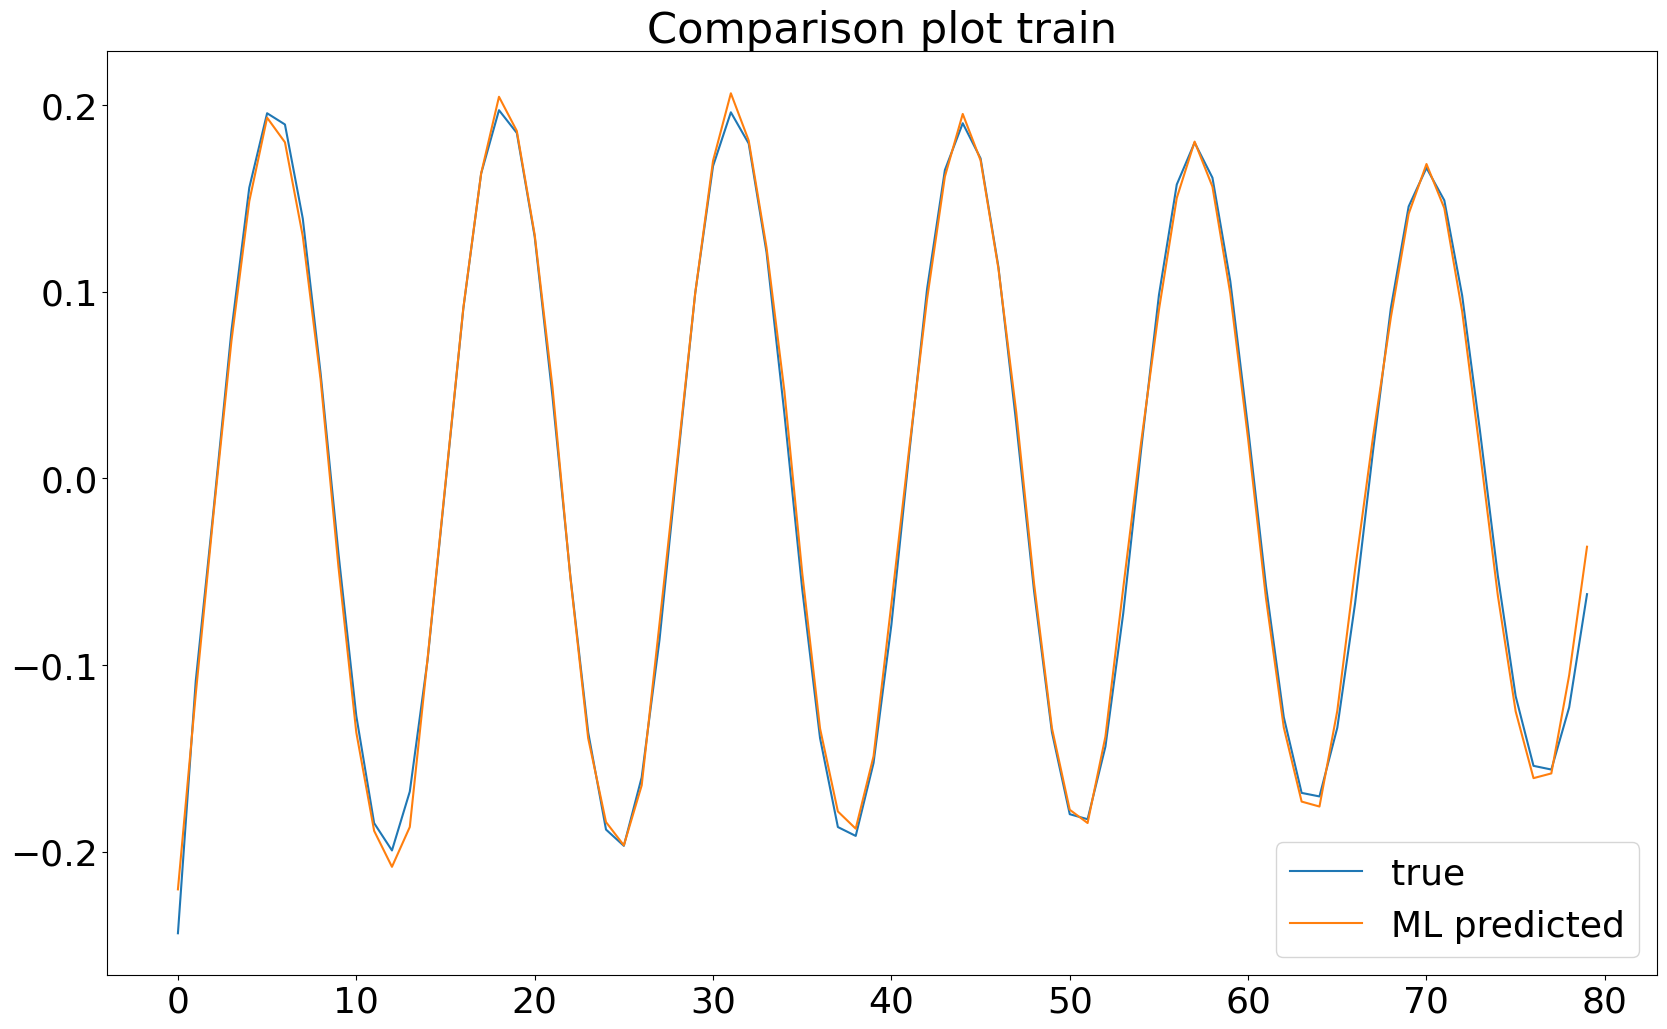

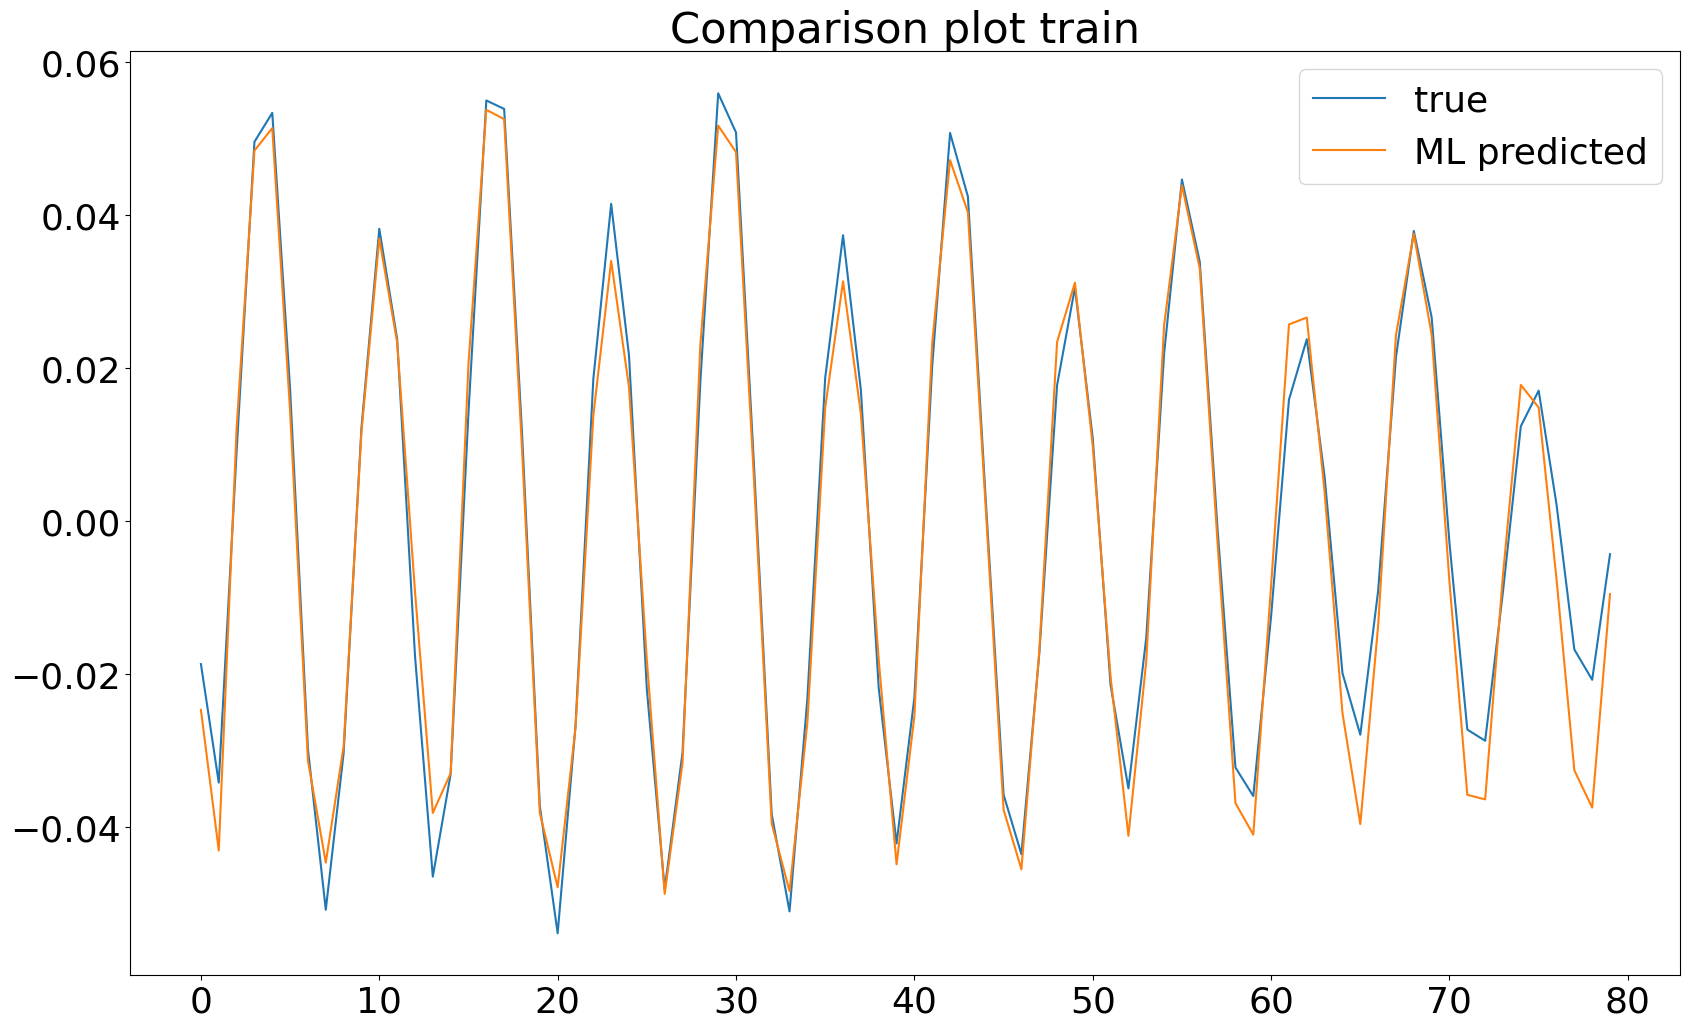

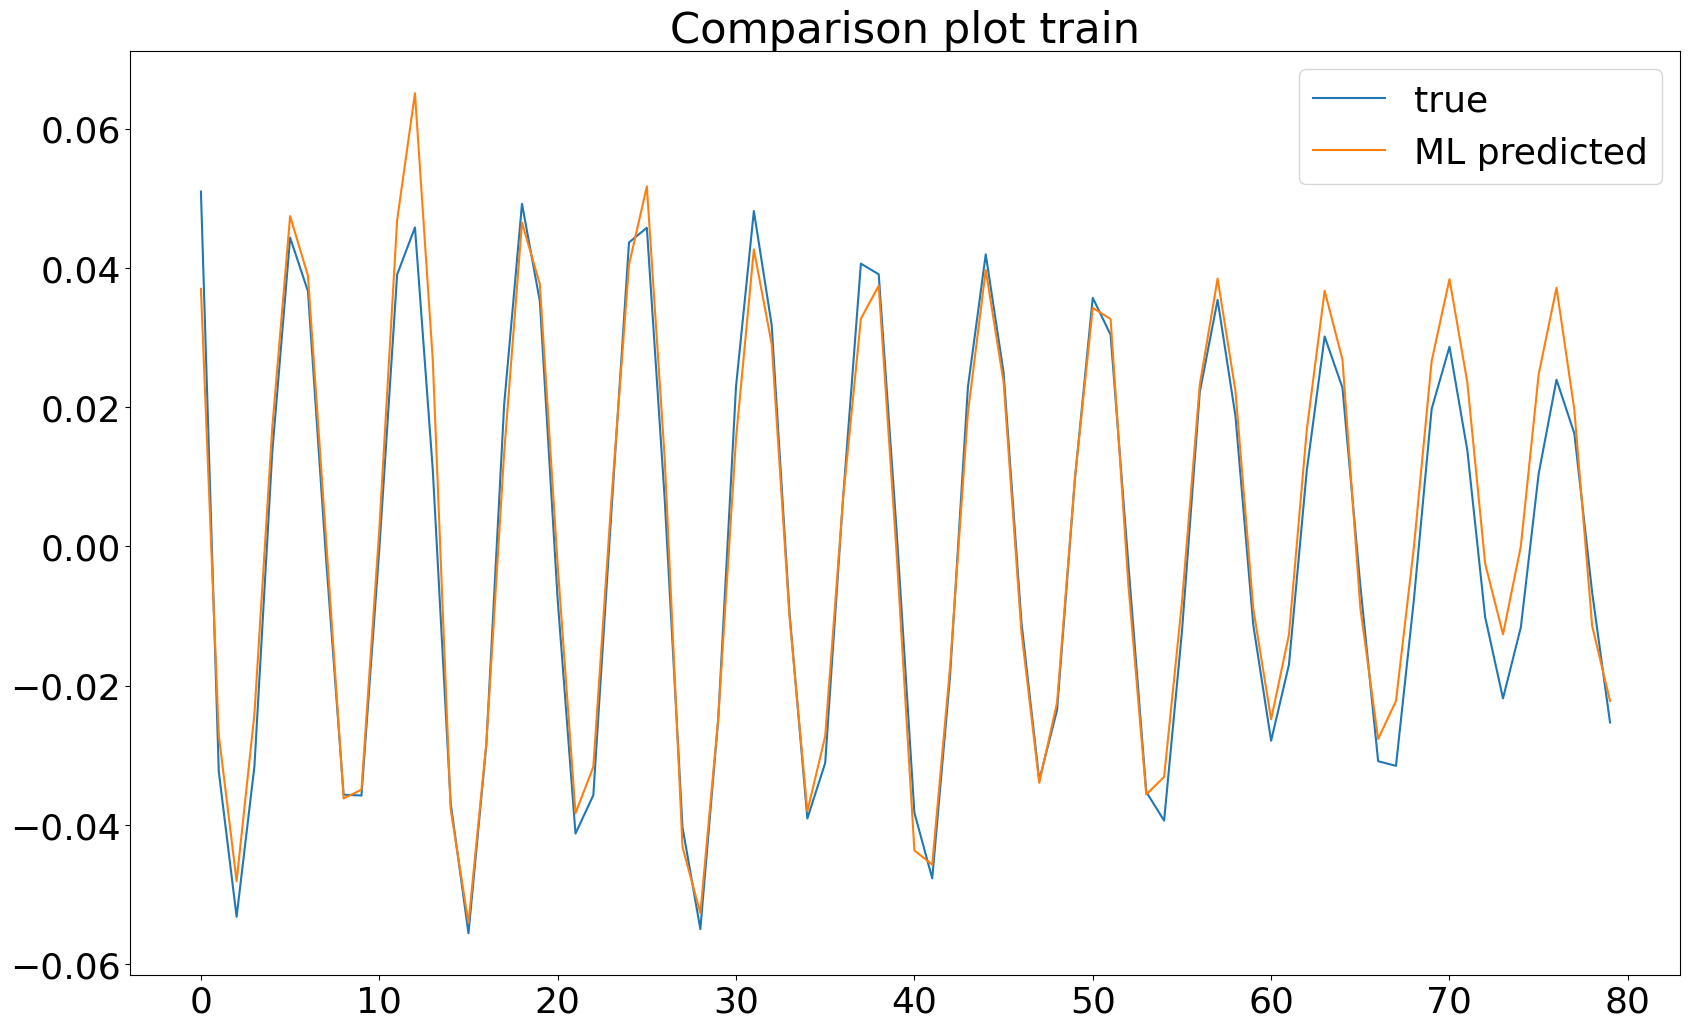

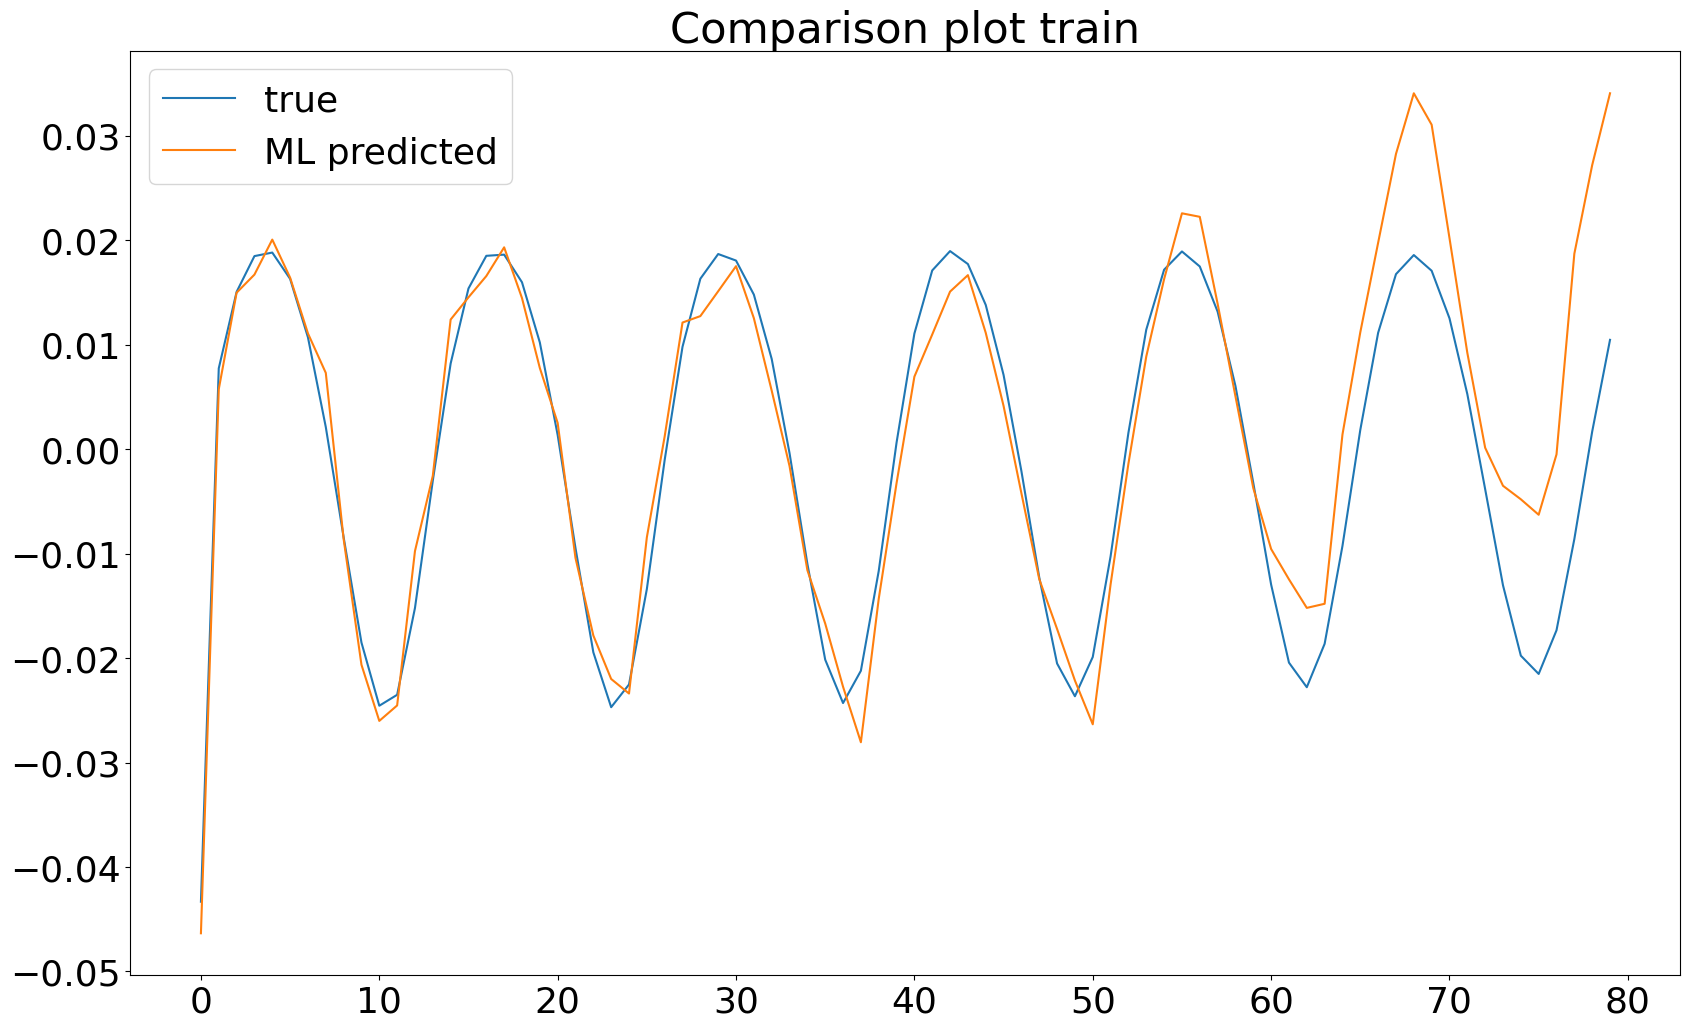

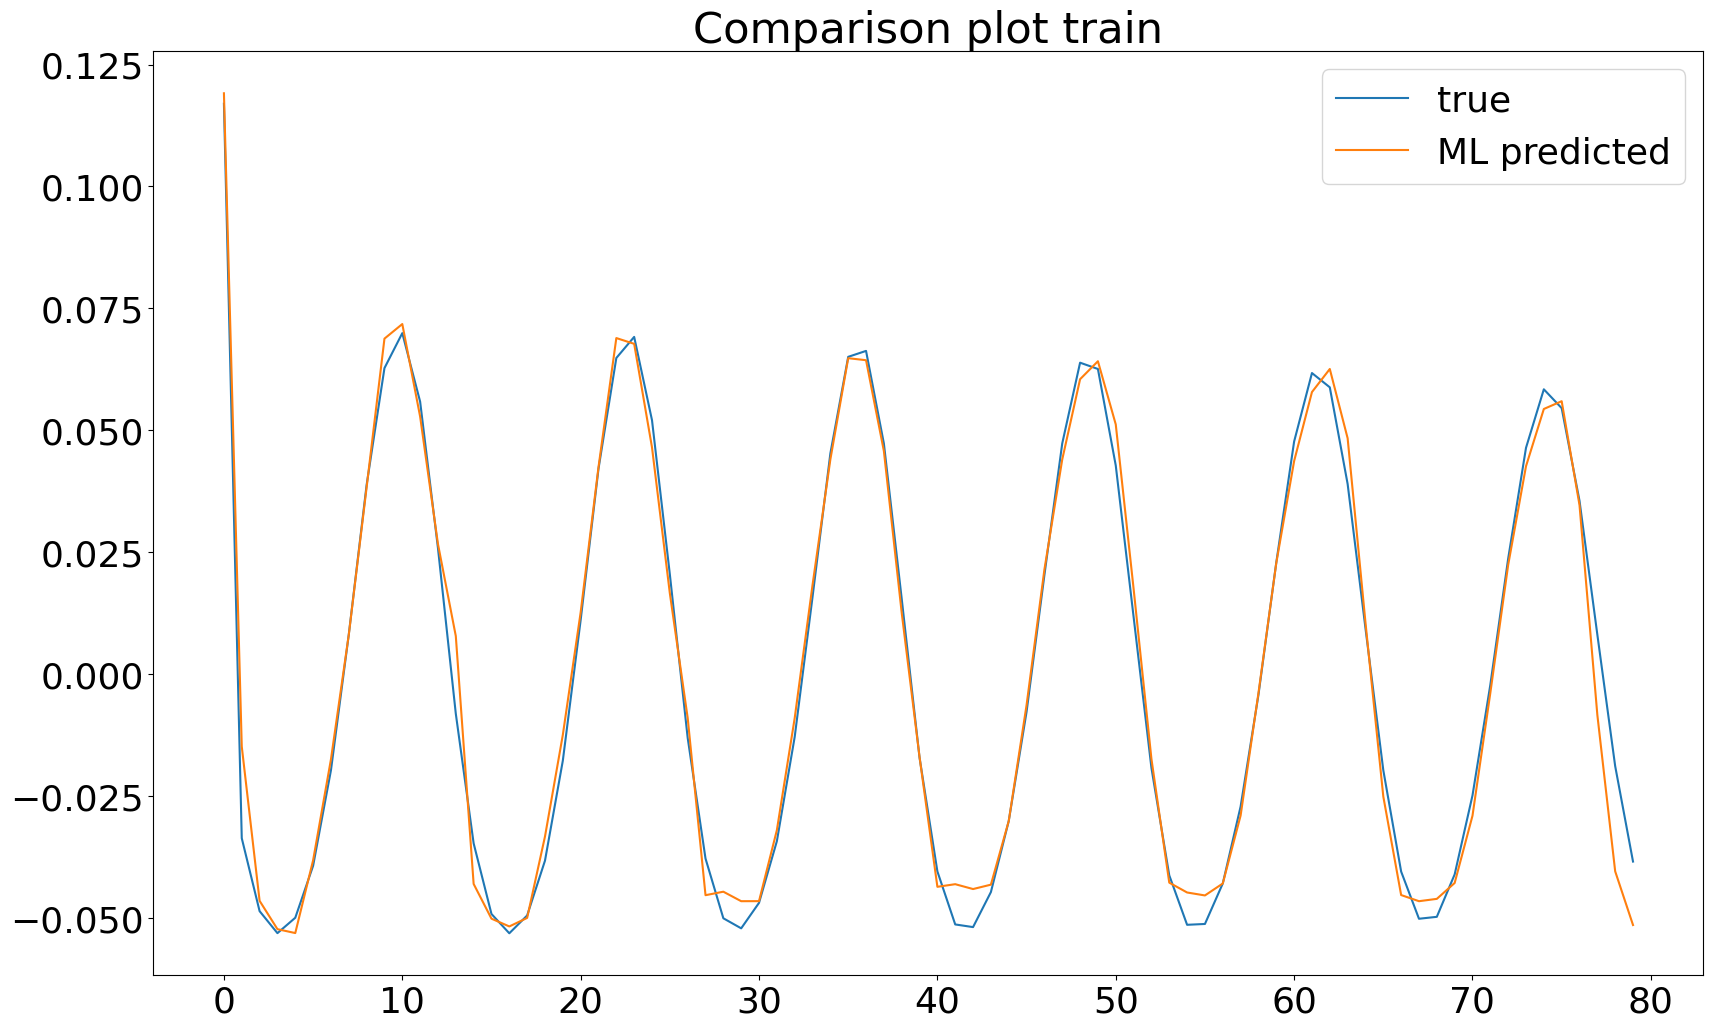

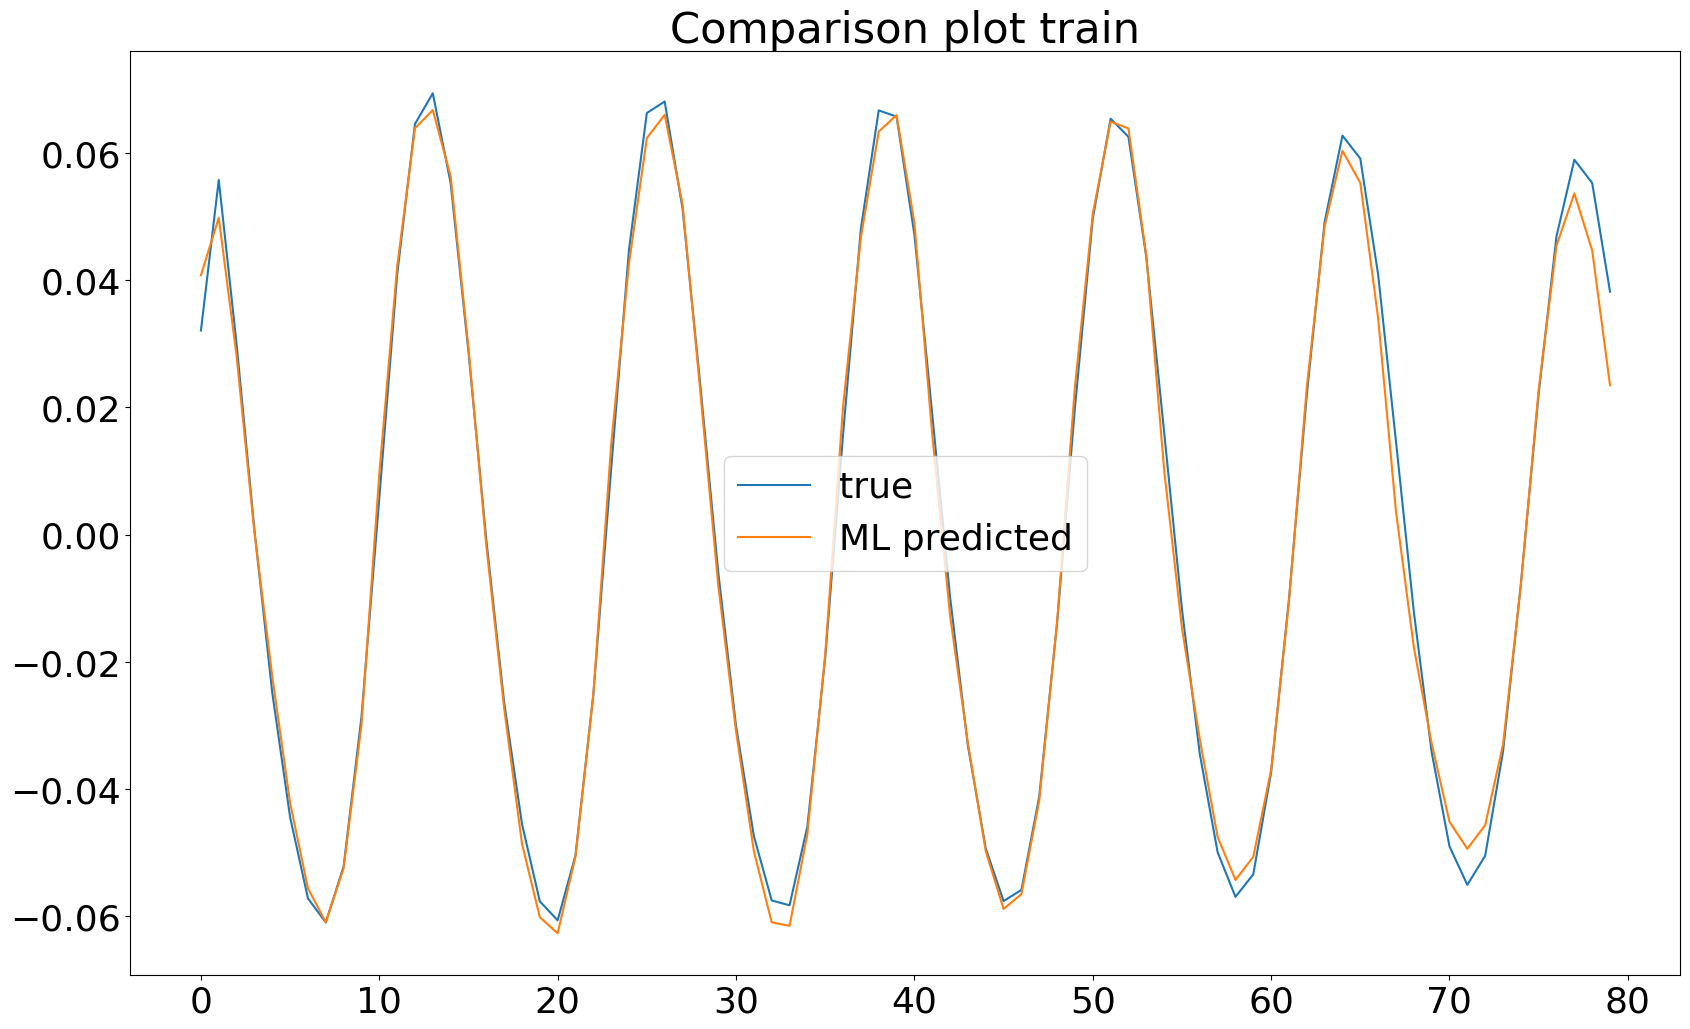

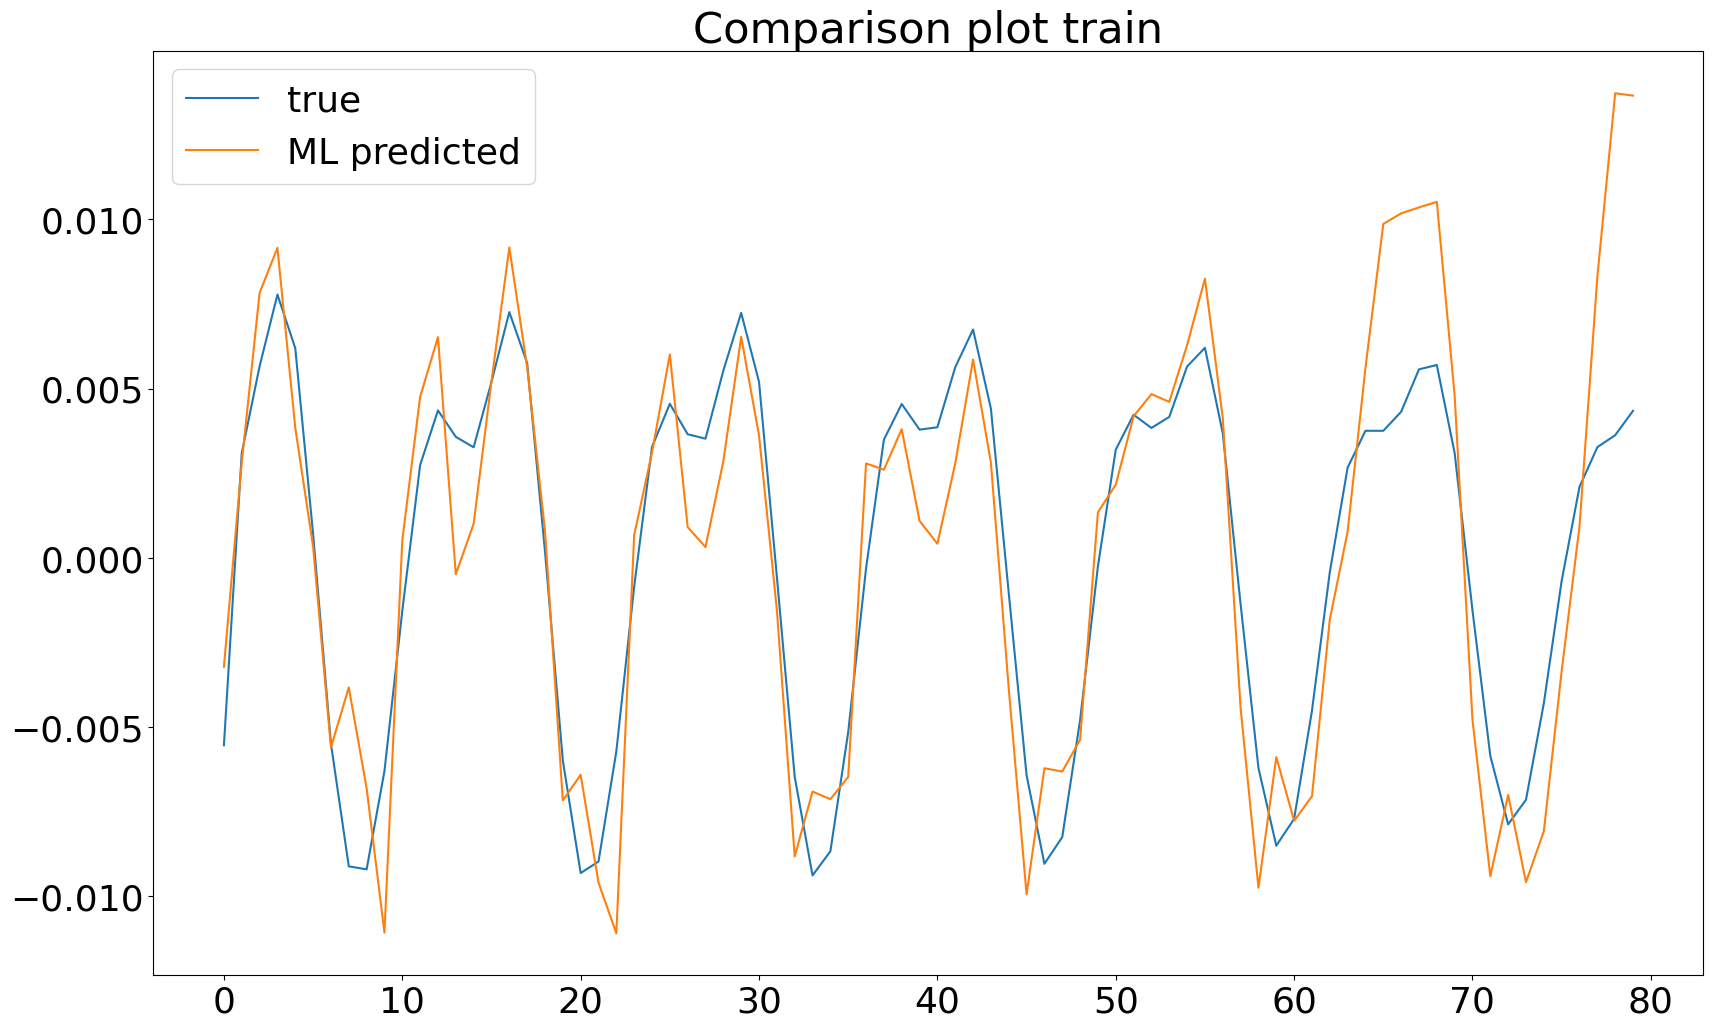

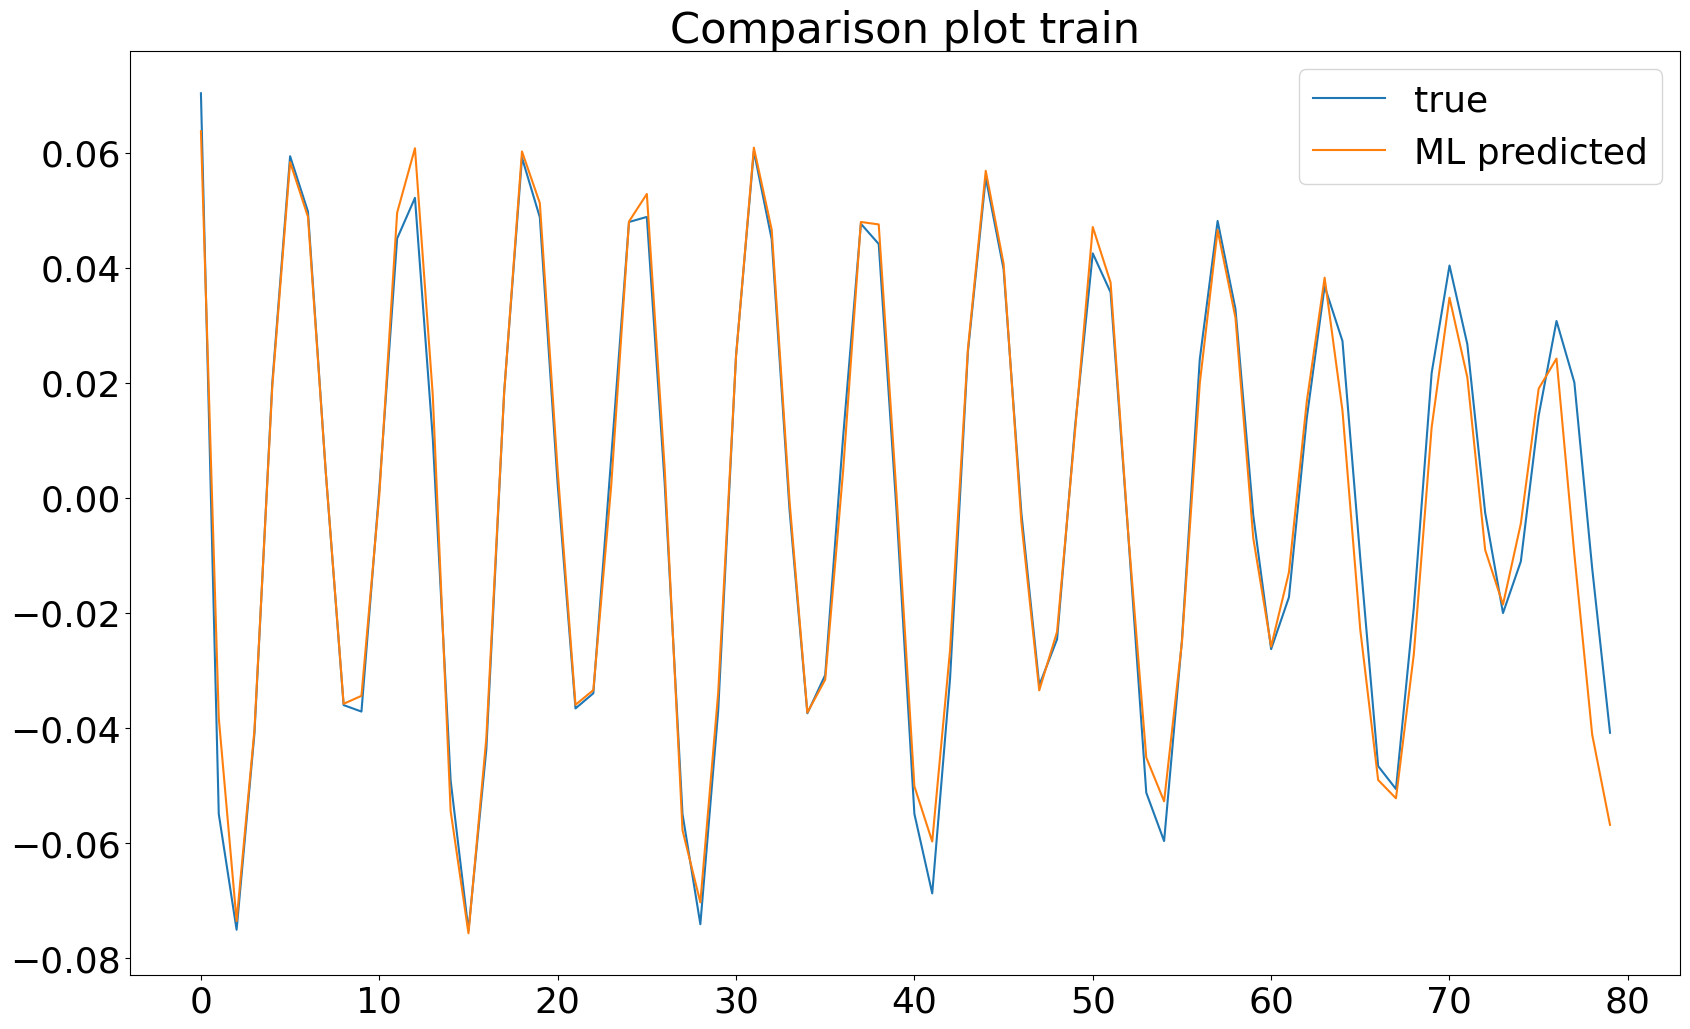

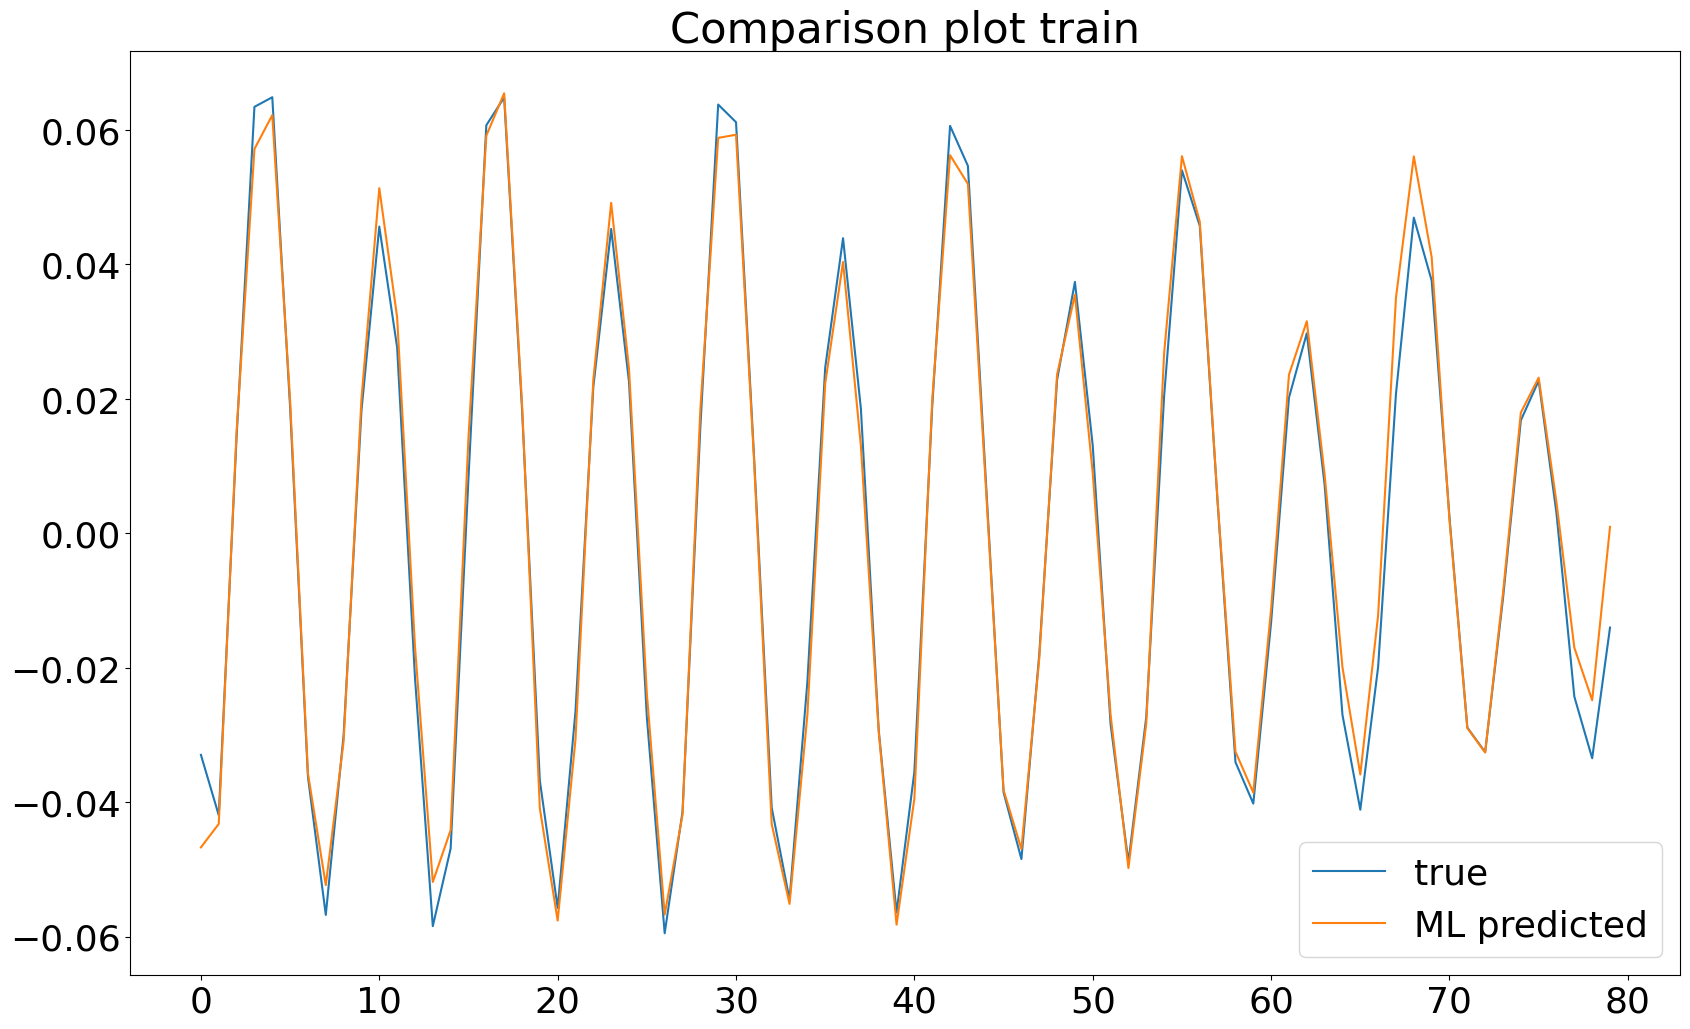

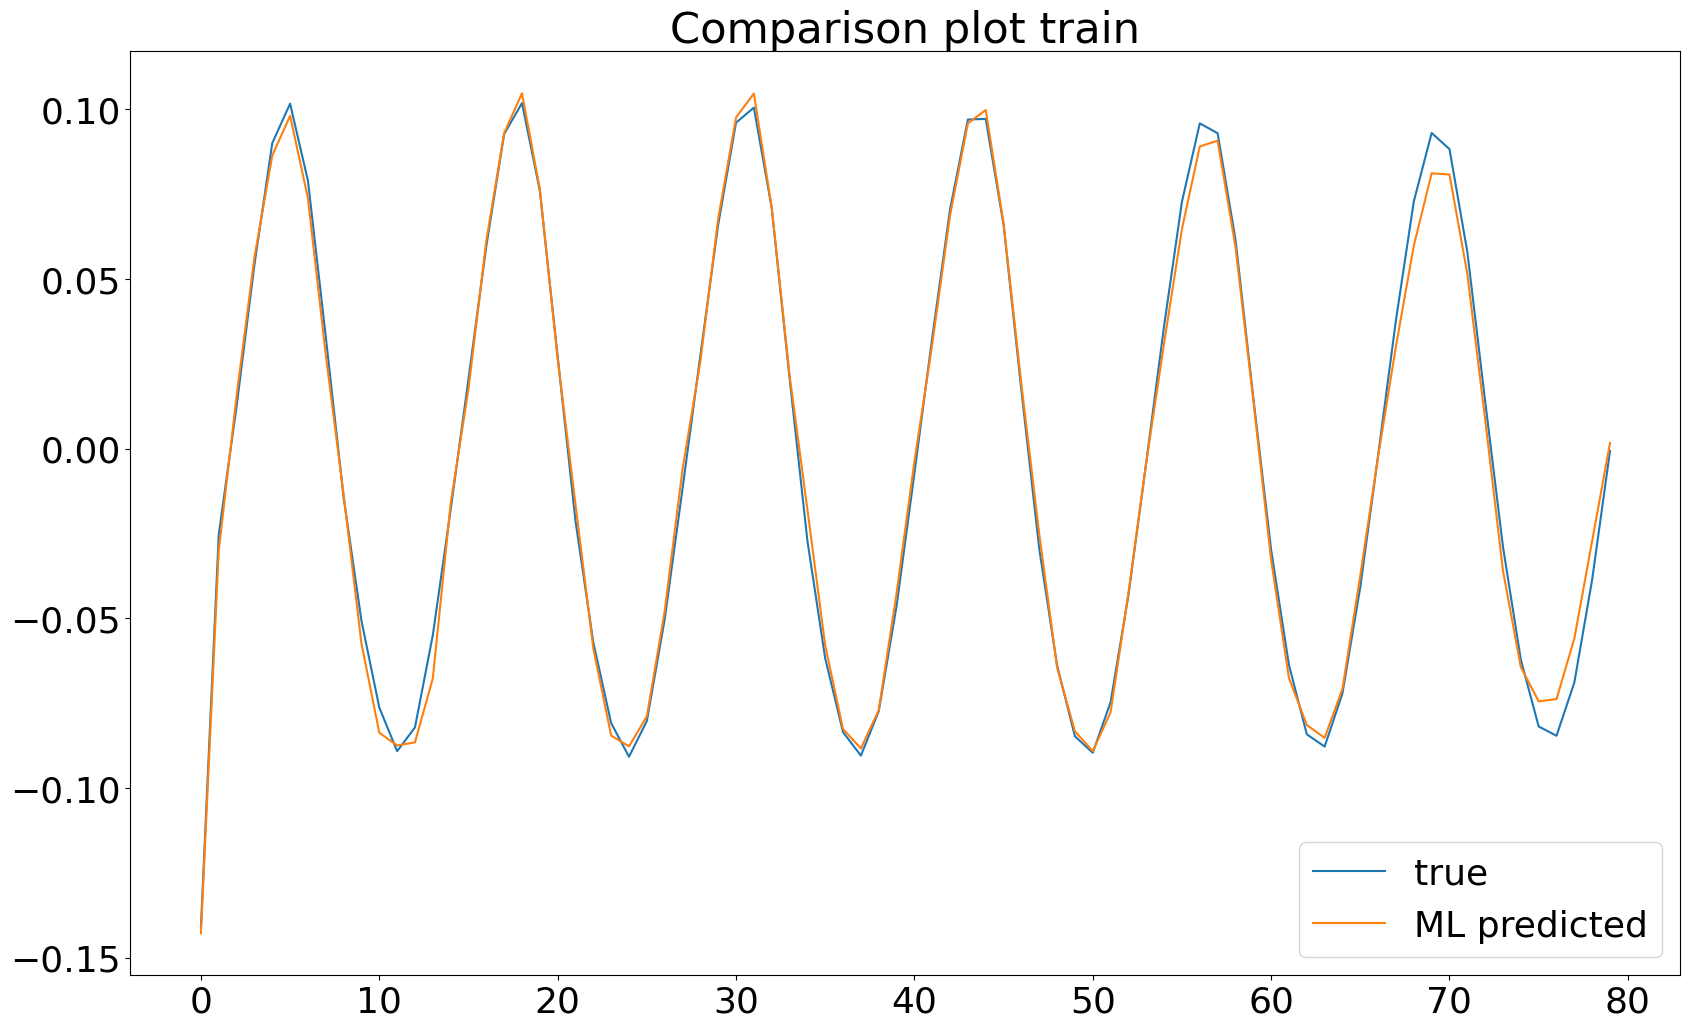

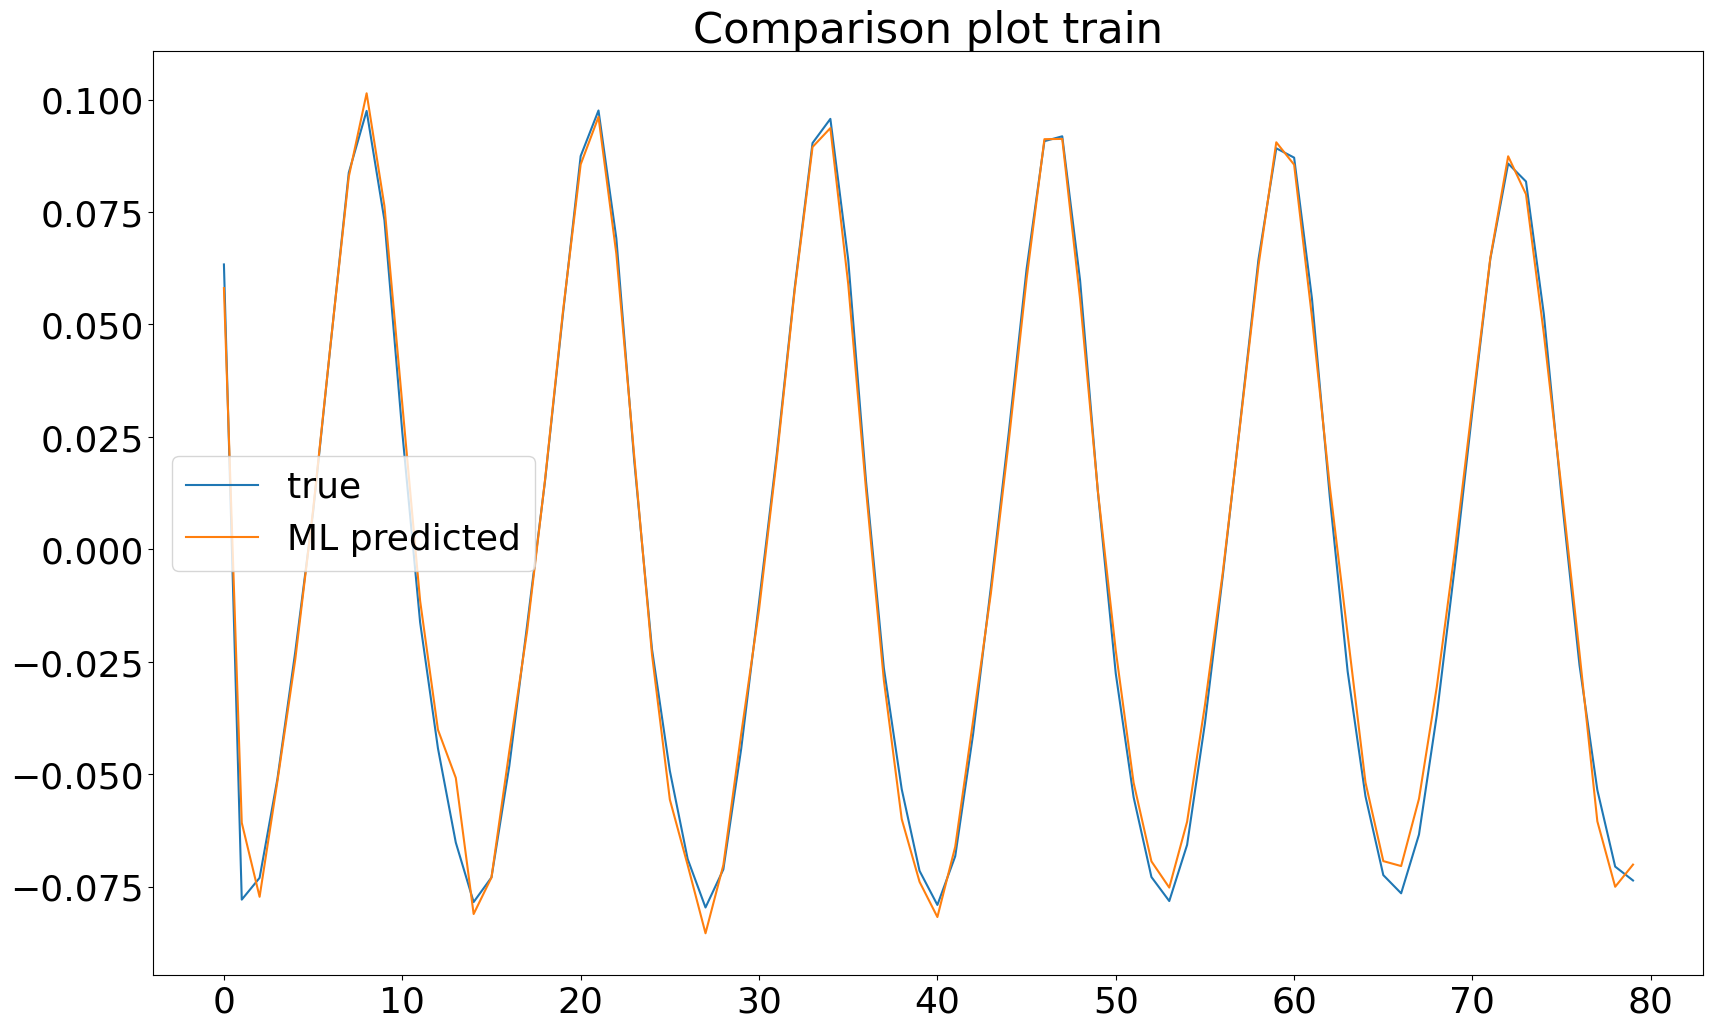

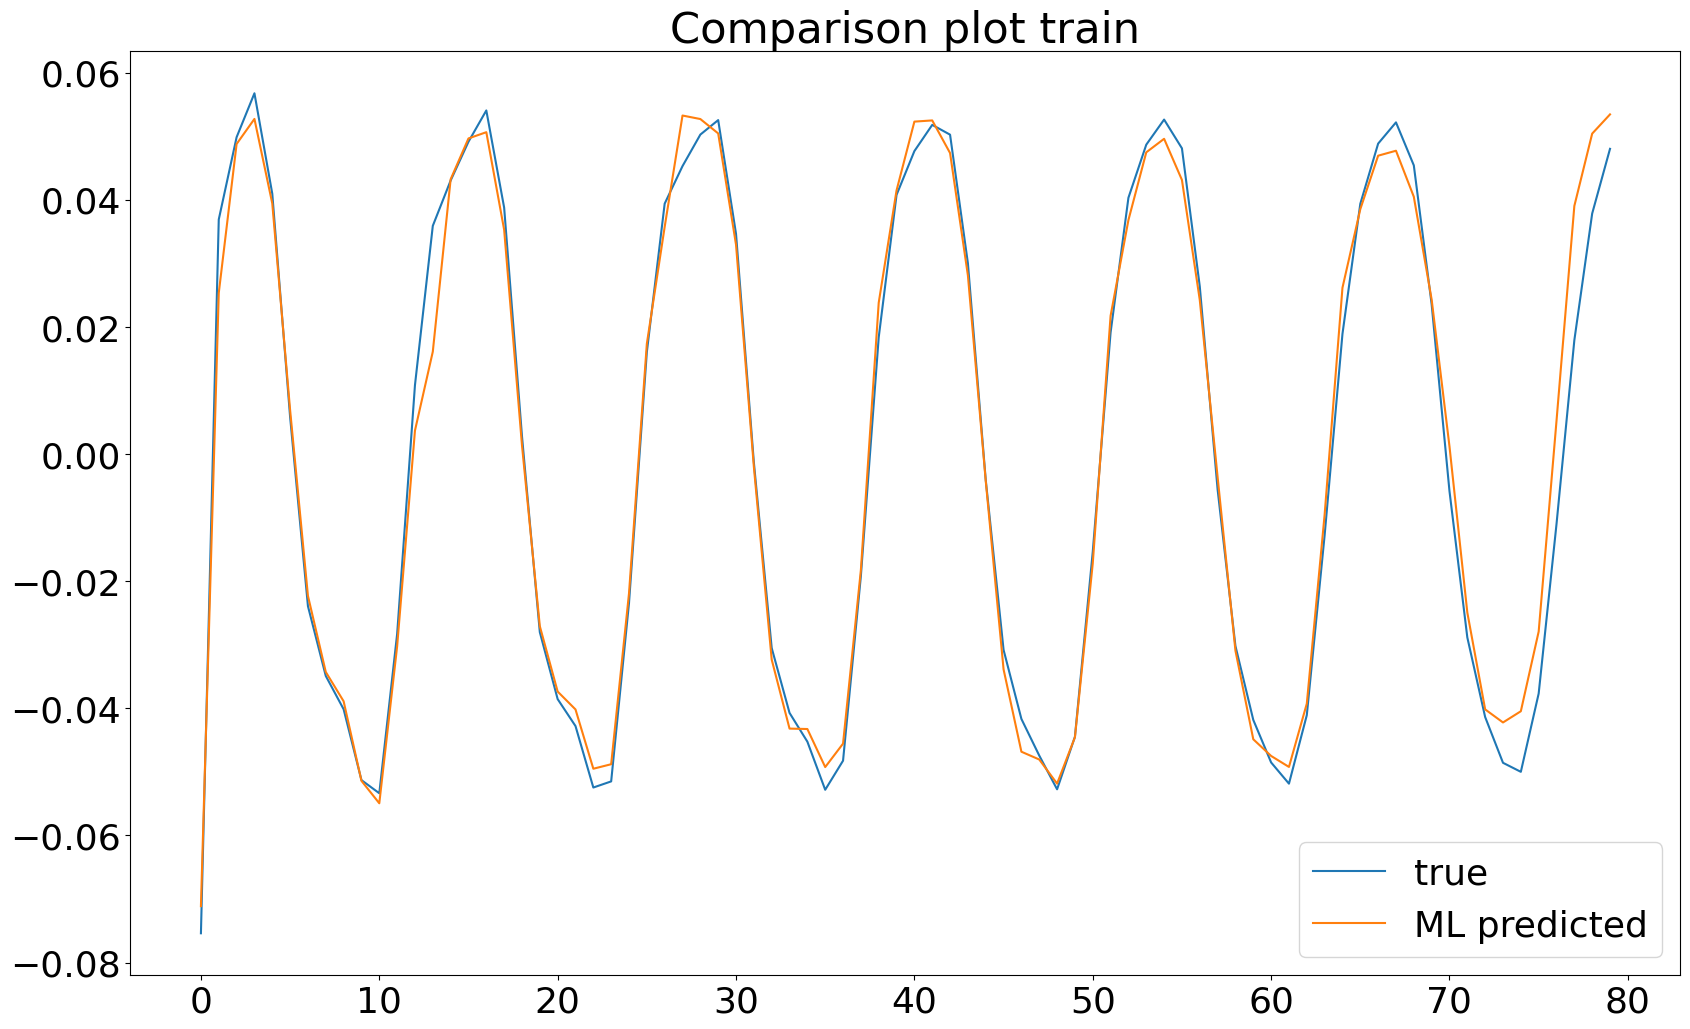

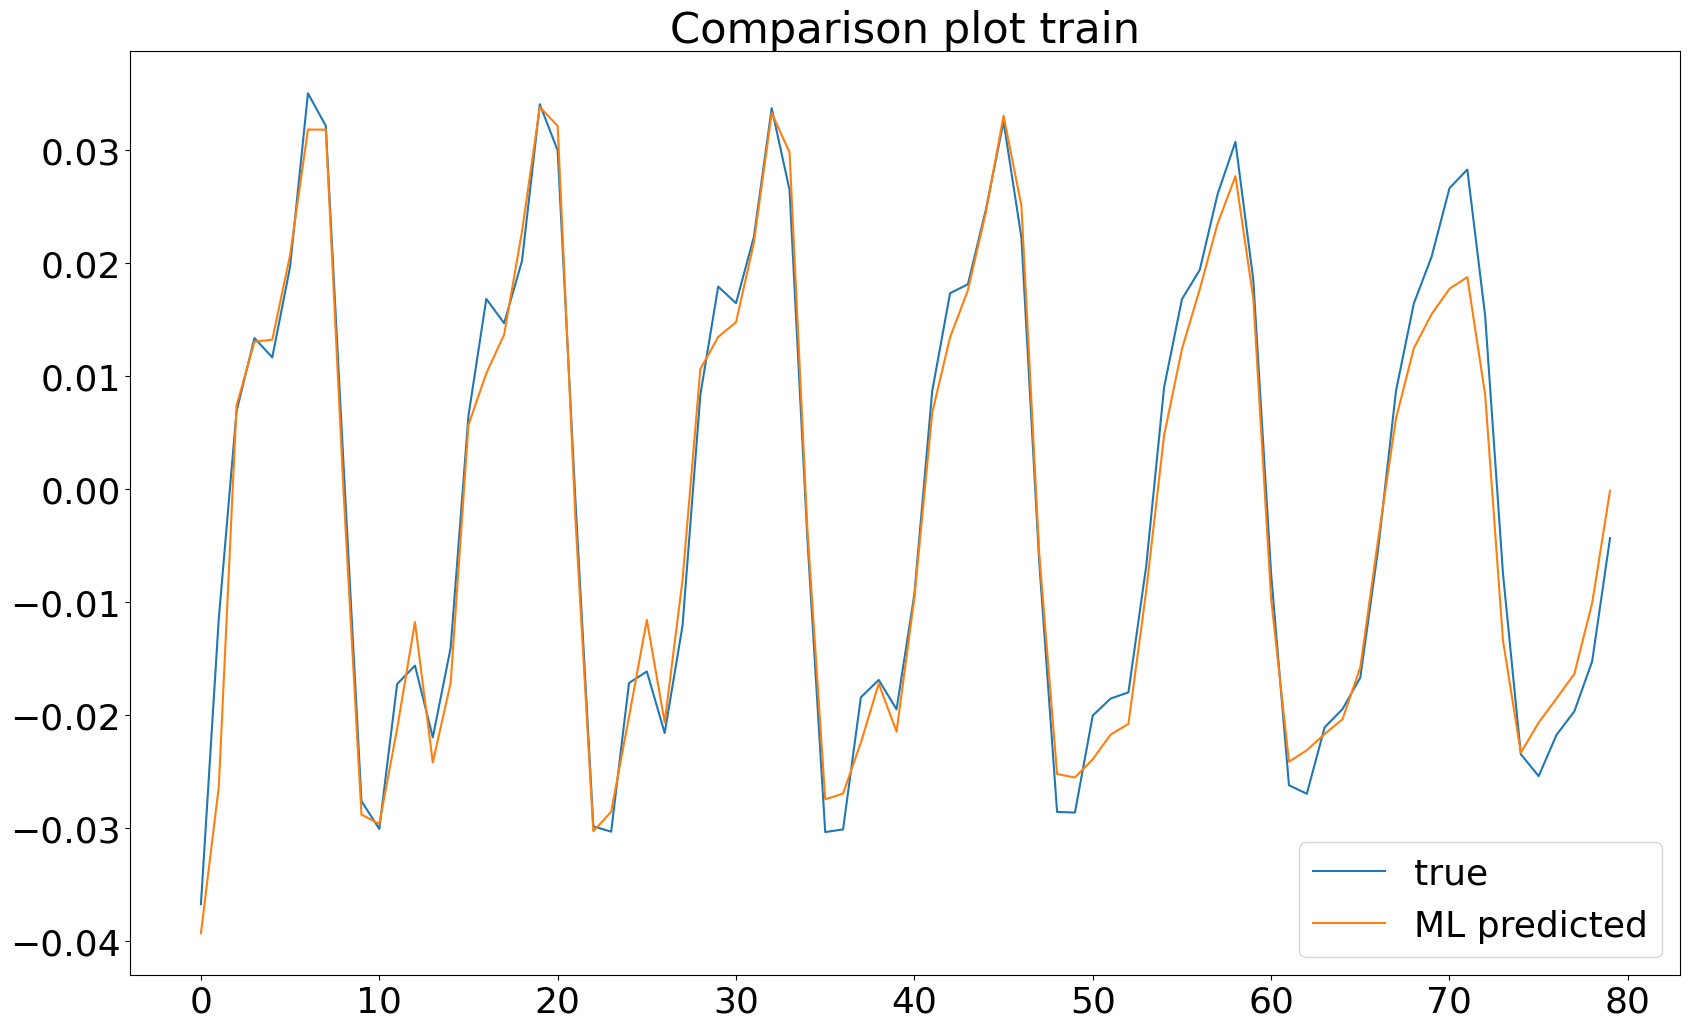

In [30]:
#Predict model
addcorrection_train=model3.predict(norm_train_features)

#Compare with ytest
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(addcorrection_train,ytrain)
print(f"Mean Absolute Error LSTM ensemble {mae}")
mse = mean_squared_error(addcorrection_train,ytrain)
print(f"Mean Squared Error LSTM ensemble: {mse}")
mape = mean_absolute_percentage_error(addcorrection_train,ytrain)
print(f"Mean Absolute Percentage Error LSTM ensemble: {mape}")

for i in range(addcorrection.shape[1]):
    kpn.plt.figure(figsize=(20,12))
    kpn.plt.plot(ytrain[:,i],label='true')
    kpn.plt.plot(addcorrection_train[:,i],label='ML predicted')
    kpn.plt.title('Comparison plot train')
    kpn.plt.legend()
    filename = f'Comparison plot_TRAIN_{i}.png'
    kpn.plt.savefig(os.path.abspath(dirFile_result+'/'+filename), dpi = 200)
    kpn.plt.show()  


-  # DATA PREPROCESSING HAS ENDED. TRAINING BEGINS. 
- Find demonstration in the TRAINING NOTEBOOK. 